In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
from sklearn.cluster import KMeans

# =========== Dataset Loading & Preprocessing ===========
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

# Backup original df for label extraction
original_df = df.copy()

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

numerical_cols = ['MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

quantile_scaler = QuantileTransformer(output_distribution='normal')
df[numerical_cols] = quantile_scaler.fit_transform(df[numerical_cols])

data = df.values
input_dim = data.shape[1]

# ======= Get true labels from 'Churn' column =======
true_labels = LabelEncoder().fit_transform(original_df['Churn'])

# =========== ClusterGAN Components ===========
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

class Generator(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'generator'

    def __call__(self, z):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(z)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.x_dim)(fc2)

class Encoder(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'encoder'

    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(x)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.z_dim)(fc2)

# =========== Loop Over Cluster Counts ===========
batch_size = 1024
num_epochs = 800
latent_dim = 16

results = []  # To store metrics

print("\n🔁 Training ClusterGAN and Evaluating Clusters:")
total_start = time.time()

for n_clusters in range(2, 101):
    tf.reset_default_graph()

    x_input = tf.placeholder(tf.float32, [None, input_dim])
    z_input = tf.placeholder(tf.float32, [None, latent_dim])

    G = Generator(z_dim=latent_dim, x_dim=input_dim)
    E = Encoder(z_dim=latent_dim, x_dim=input_dim)

    x_generated = G(z_input)
    z_reconstructed = E(x_generated)
    z_real = E(x_input)
    z_encoded_output = E(x_input)

    g_loss = tf.reduce_mean(tf.square(z_input - z_reconstructed))
    e_loss = tf.reduce_mean(tf.square(z_input - z_real))

    g_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss)
    e_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(e_loss)

    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    sess.run(tf.global_variables_initializer())

    start_train = time.time()
    for epoch in range(num_epochs):
        current_batch_size = min(batch_size, data.shape[0])
        idx = np.random.choice(data.shape[0], current_batch_size, replace=False)
        real_batch = data[idx]
        z_batch = np.random.uniform(-0.6, 0.6, size=(current_batch_size, latent_dim))
        sess.run([g_optimizer, e_optimizer], feed_dict={x_input: real_batch, z_input: z_batch})

    z_embeddings = sess.run(z_encoded_output, feed_dict={x_input: data})
    sess.close()

    # ======= Clustering and Metric Calculation =======
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(z_embeddings)

    # --- Standard Clustering Metrics ---
    try:
        silhouette = silhouette_score(z_embeddings, cluster_labels)
    except:
        silhouette = -1
    try:
        ch_score = calinski_harabasz_score(z_embeddings, cluster_labels)
    except:
        ch_score = -1
    try:
        db_score = davies_bouldin_score(z_embeddings, cluster_labels)
    except:
        db_score = -1

    # ✅ CORRECTED: Compare predicted clusters to true churn labels
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)

    # --- Inertia and Compactness ---
    inertia = kmeans.inertia_
    compactness = inertia / data.shape[0]

    print(f"K={n_clusters:3d} | NMI: {nmi:.4f} | ARI: {ari:.4f} | Homogeneity: {homogeneity:.4f} | "
          f"Completeness: {completeness:.4f} | V-Measure: {v_measure:.4f} | Silhouette: {silhouette:.4f} | "
          f"Calinski-Harabasz: {ch_score:.2f} | Davies-Bouldin: {db_score:.2f} | Inertia: {inertia:.2f} | Compactness: {compactness:.6f}")

    # Save the result
    results.append({
        "n_clusters": n_clusters,
        "NMI": nmi,
        "ARI": ari,
        "Homogeneity": homogeneity,
        "Completeness": completeness,
        "V-Measure": v_measure,
        "Silhouette": silhouette,
        "Calinski-Harabasz": ch_score,
        "Davies-Bouldin": db_score,
        "Inertia": inertia,
        "Compactness": compactness
    })

# =========== Save Results ===========
results_df = pd.DataFrame(results)
results_df.to_csv('Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv', index=False)

print(f"\n✅ All Trainings Complete. Total Time: {(time.time() - total_start)/60:.2f} minutes.")
print("📁 Results saved to 'Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv'")


2025-05-10 03:10:19.223764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746846619.409687      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746846619.463230      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🔁 Training ClusterGAN and Evaluating Clusters:


I0000 00:00:1746846632.976947      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746846632.994021      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


K=  2 | NMI: 0.0695 | ARI: 0.0309 | Homogeneity: 0.0758 | Completeness: 0.0642 | V-Measure: 0.0695 | Silhouette: 0.6671 | Calinski-Harabasz: 27388.79 | Davies-Bouldin: 0.45 | Inertia: 155175.12 | Compactness: 22.032532


I0000 00:00:1746846638.778968      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  3 | NMI: 0.0706 | ARI: 0.0343 | Homogeneity: 0.1013 | Completeness: 0.0541 | V-Measure: 0.0706 | Silhouette: 0.5902 | Calinski-Harabasz: 32664.81 | Davies-Bouldin: 0.53 | Inertia: 31453.14 | Compactness: 4.465872


I0000 00:00:1746846643.912276      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  4 | NMI: 0.0633 | ARI: 0.0231 | Homogeneity: 0.1062 | Completeness: 0.0451 | V-Measure: 0.0633 | Silhouette: 0.5491 | Calinski-Harabasz: 38412.21 | Davies-Bouldin: 0.57 | Inertia: 17805.14 | Compactness: 2.528062


I0000 00:00:1746846649.330020      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  5 | NMI: 0.0586 | ARI: 0.0189 | Homogeneity: 0.1090 | Completeness: 0.0400 | V-Measure: 0.0586 | Silhouette: 0.4530 | Calinski-Harabasz: 31000.79 | Davies-Bouldin: 0.74 | Inertia: 13782.33 | Compactness: 1.956884


I0000 00:00:1746846654.631444      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  6 | NMI: 0.0593 | ARI: 0.0211 | Homogeneity: 0.1197 | Completeness: 0.0394 | V-Measure: 0.0593 | Silhouette: 0.4786 | Calinski-Harabasz: 45754.53 | Davies-Bouldin: 0.66 | Inertia: 13274.10 | Compactness: 1.884722


I0000 00:00:1746846659.960276      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  7 | NMI: 0.0558 | ARI: 0.0129 | Homogeneity: 0.1191 | Completeness: 0.0364 | V-Measure: 0.0558 | Silhouette: 0.4255 | Calinski-Harabasz: 40353.02 | Davies-Bouldin: 0.78 | Inertia: 11080.20 | Compactness: 1.573222


I0000 00:00:1746846665.058954      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  8 | NMI: 0.0547 | ARI: 0.0131 | Homogeneity: 0.1226 | Completeness: 0.0352 | V-Measure: 0.0547 | Silhouette: 0.4284 | Calinski-Harabasz: 47515.35 | Davies-Bouldin: 0.77 | Inertia: 12814.24 | Compactness: 1.819430


I0000 00:00:1746846670.287737      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=  9 | NMI: 0.0517 | ARI: 0.0138 | Homogeneity: 0.1216 | Completeness: 0.0328 | V-Measure: 0.0517 | Silhouette: 0.3899 | Calinski-Harabasz: 45261.35 | Davies-Bouldin: 0.83 | Inertia: 9264.25 | Compactness: 1.315384


I0000 00:00:1746846675.438069      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 10 | NMI: 0.0462 | ARI: 0.0071 | Homogeneity: 0.1124 | Completeness: 0.0291 | V-Measure: 0.0462 | Silhouette: 0.3063 | Calinski-Harabasz: 30288.63 | Davies-Bouldin: 1.08 | Inertia: 8928.07 | Compactness: 1.267651


I0000 00:00:1746846681.117658      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 11 | NMI: 0.0506 | ARI: 0.0042 | Homogeneity: 0.1265 | Completeness: 0.0316 | V-Measure: 0.0506 | Silhouette: 0.2985 | Calinski-Harabasz: 31112.49 | Davies-Bouldin: 1.13 | Inertia: 8894.17 | Compactness: 1.262838


I0000 00:00:1746846686.323305      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 12 | NMI: 0.0498 | ARI: 0.0132 | Homogeneity: 0.1289 | Completeness: 0.0308 | V-Measure: 0.0498 | Silhouette: 0.3288 | Calinski-Harabasz: 42659.69 | Davies-Bouldin: 0.99 | Inertia: 8666.62 | Compactness: 1.230529


I0000 00:00:1746846691.532339      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 13 | NMI: 0.0568 | ARI: 0.0212 | Homogeneity: 0.1530 | Completeness: 0.0349 | V-Measure: 0.0568 | Silhouette: 0.2463 | Calinski-Harabasz: 26790.64 | Davies-Bouldin: 1.25 | Inertia: 7874.33 | Compactness: 1.118037


I0000 00:00:1746846696.797188      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 14 | NMI: 0.0470 | ARI: 0.0030 | Homogeneity: 0.1274 | Completeness: 0.0288 | V-Measure: 0.0470 | Silhouette: 0.2203 | Calinski-Harabasz: 13741.64 | Davies-Bouldin: 1.46 | Inertia: 8593.09 | Compactness: 1.220090


I0000 00:00:1746846702.222083      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 15 | NMI: 0.0458 | ARI: 0.0093 | Homogeneity: 0.1297 | Completeness: 0.0278 | V-Measure: 0.0458 | Silhouette: 0.1744 | Calinski-Harabasz: 18386.29 | Davies-Bouldin: 1.58 | Inertia: 6433.07 | Compactness: 0.913399


I0000 00:00:1746846707.620272      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 16 | NMI: 0.0493 | ARI: 0.0078 | Homogeneity: 0.1409 | Completeness: 0.0299 | V-Measure: 0.0493 | Silhouette: 0.1832 | Calinski-Harabasz: 14571.92 | Davies-Bouldin: 1.60 | Inertia: 8783.52 | Compactness: 1.247127


I0000 00:00:1746846713.170567      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 17 | NMI: 0.0587 | ARI: 0.0096 | Homogeneity: 0.1701 | Completeness: 0.0355 | V-Measure: 0.0587 | Silhouette: 0.1780 | Calinski-Harabasz: 18640.17 | Davies-Bouldin: 1.53 | Inertia: 7066.20 | Compactness: 1.003294


I0000 00:00:1746846718.406459      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 18 | NMI: 0.0485 | ARI: 0.0137 | Homogeneity: 0.1440 | Completeness: 0.0292 | V-Measure: 0.0485 | Silhouette: 0.1884 | Calinski-Harabasz: 26601.04 | Davies-Bouldin: 1.47 | Inertia: 7364.11 | Compactness: 1.045593


I0000 00:00:1746846723.659651      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 19 | NMI: 0.0470 | ARI: 0.0075 | Homogeneity: 0.1415 | Completeness: 0.0282 | V-Measure: 0.0470 | Silhouette: 0.1790 | Calinski-Harabasz: 22437.73 | Davies-Bouldin: 1.57 | Inertia: 6125.44 | Compactness: 0.869720


I0000 00:00:1746846728.892701      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 20 | NMI: 0.0453 | ARI: 0.0046 | Homogeneity: 0.1372 | Completeness: 0.0271 | V-Measure: 0.0453 | Silhouette: 0.2126 | Calinski-Harabasz: 32259.46 | Davies-Bouldin: 1.39 | Inertia: 5831.92 | Compactness: 0.828044


I0000 00:00:1746846734.116189      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 21 | NMI: 0.0405 | ARI: 0.0025 | Homogeneity: 0.1237 | Completeness: 0.0242 | V-Measure: 0.0405 | Silhouette: 0.2272 | Calinski-Harabasz: 40101.02 | Davies-Bouldin: 1.33 | Inertia: 7126.49 | Compactness: 1.011854


I0000 00:00:1746846739.379547      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 22 | NMI: 0.0421 | ARI: 0.0061 | Homogeneity: 0.1322 | Completeness: 0.0250 | V-Measure: 0.0421 | Silhouette: 0.1910 | Calinski-Harabasz: 36800.99 | Davies-Bouldin: 1.46 | Inertia: 4022.61 | Compactness: 0.571149


I0000 00:00:1746846744.964601      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 23 | NMI: 0.0541 | ARI: 0.0120 | Homogeneity: 0.1699 | Completeness: 0.0322 | V-Measure: 0.0541 | Silhouette: 0.1777 | Calinski-Harabasz: 21079.51 | Davies-Bouldin: 1.65 | Inertia: 5711.38 | Compactness: 0.810930


I0000 00:00:1746846750.255278      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 24 | NMI: 0.0417 | ARI: 0.0023 | Homogeneity: 0.1318 | Completeness: 0.0248 | V-Measure: 0.0417 | Silhouette: 0.1849 | Calinski-Harabasz: 24558.62 | Davies-Bouldin: 1.52 | Inertia: 6111.09 | Compactness: 0.867683


I0000 00:00:1746846755.471725      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 25 | NMI: 0.0443 | ARI: 0.0076 | Homogeneity: 0.1429 | Completeness: 0.0262 | V-Measure: 0.0443 | Silhouette: 0.1781 | Calinski-Harabasz: 16198.67 | Davies-Bouldin: 1.61 | Inertia: 4719.59 | Compactness: 0.670111


I0000 00:00:1746846760.734532      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 26 | NMI: 0.0424 | ARI: 0.0063 | Homogeneity: 0.1381 | Completeness: 0.0250 | V-Measure: 0.0424 | Silhouette: 0.1853 | Calinski-Harabasz: 18542.58 | Davies-Bouldin: 1.54 | Inertia: 5060.57 | Compactness: 0.718524


I0000 00:00:1746846766.034112      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 27 | NMI: 0.0425 | ARI: 0.0092 | Homogeneity: 0.1413 | Completeness: 0.0250 | V-Measure: 0.0425 | Silhouette: 0.1582 | Calinski-Harabasz: 22241.00 | Davies-Bouldin: 1.71 | Inertia: 5929.53 | Compactness: 0.841904


I0000 00:00:1746846771.675109      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 28 | NMI: 0.0441 | ARI: 0.0055 | Homogeneity: 0.1470 | Completeness: 0.0260 | V-Measure: 0.0441 | Silhouette: 0.1945 | Calinski-Harabasz: 26318.13 | Davies-Bouldin: 1.49 | Inertia: 6655.77 | Compactness: 0.945019


I0000 00:00:1746846777.426422      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 29 | NMI: 0.0506 | ARI: 0.0062 | Homogeneity: 0.1702 | Completeness: 0.0297 | V-Measure: 0.0506 | Silhouette: 0.1524 | Calinski-Harabasz: 19822.53 | Davies-Bouldin: 1.78 | Inertia: 4427.77 | Compactness: 0.628676


I0000 00:00:1746846782.871763      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 30 | NMI: 0.0513 | ARI: 0.0075 | Homogeneity: 0.1739 | Completeness: 0.0301 | V-Measure: 0.0513 | Silhouette: 0.1796 | Calinski-Harabasz: 19838.46 | Davies-Bouldin: 1.59 | Inertia: 4390.09 | Compactness: 0.623327


I0000 00:00:1746846788.461223      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 31 | NMI: 0.0611 | ARI: 0.0091 | Homogeneity: 0.2100 | Completeness: 0.0358 | V-Measure: 0.0611 | Silhouette: 0.1770 | Calinski-Harabasz: 13854.20 | Davies-Bouldin: 1.52 | Inertia: 5938.92 | Compactness: 0.843237


I0000 00:00:1746846793.818570      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 32 | NMI: 0.0454 | ARI: 0.0054 | Homogeneity: 0.1568 | Completeness: 0.0266 | V-Measure: 0.0454 | Silhouette: 0.1632 | Calinski-Harabasz: 11565.73 | Davies-Bouldin: 1.65 | Inertia: 4500.76 | Compactness: 0.639041


I0000 00:00:1746846799.235099      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 33 | NMI: 0.0472 | ARI: 0.0064 | Homogeneity: 0.1642 | Completeness: 0.0276 | V-Measure: 0.0472 | Silhouette: 0.1995 | Calinski-Harabasz: 27591.29 | Davies-Bouldin: 1.46 | Inertia: 6972.24 | Compactness: 0.989953


I0000 00:00:1746846804.850544      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 34 | NMI: 0.0486 | ARI: 0.0070 | Homogeneity: 0.1708 | Completeness: 0.0283 | V-Measure: 0.0486 | Silhouette: 0.1460 | Calinski-Harabasz: 14478.54 | Davies-Bouldin: 1.73 | Inertia: 4695.45 | Compactness: 0.666683


I0000 00:00:1746846810.455118      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 35 | NMI: 0.0447 | ARI: 0.0044 | Homogeneity: 0.1568 | Completeness: 0.0261 | V-Measure: 0.0447 | Silhouette: 0.1696 | Calinski-Harabasz: 16123.72 | Davies-Bouldin: 1.61 | Inertia: 4938.29 | Compactness: 0.701163


I0000 00:00:1746846816.033773      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 36 | NMI: 0.0511 | ARI: 0.0060 | Homogeneity: 0.1815 | Completeness: 0.0298 | V-Measure: 0.0511 | Silhouette: 0.1358 | Calinski-Harabasz: 17325.48 | Davies-Bouldin: 1.95 | Inertia: 5227.74 | Compactness: 0.742261


I0000 00:00:1746846821.377433      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 37 | NMI: 0.0417 | ARI: 0.0039 | Homogeneity: 0.1483 | Completeness: 0.0243 | V-Measure: 0.0417 | Silhouette: 0.1482 | Calinski-Harabasz: 16038.16 | Davies-Bouldin: 1.80 | Inertia: 5212.53 | Compactness: 0.740101


I0000 00:00:1746846826.769920      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 38 | NMI: 0.0523 | ARI: 0.0071 | Homogeneity: 0.1884 | Completeness: 0.0304 | V-Measure: 0.0523 | Silhouette: 0.1389 | Calinski-Harabasz: 14945.22 | Davies-Bouldin: 1.86 | Inertia: 4557.85 | Compactness: 0.647147


I0000 00:00:1746846832.161623      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 39 | NMI: 0.0373 | ARI: 0.0026 | Homogeneity: 0.1342 | Completeness: 0.0217 | V-Measure: 0.0373 | Silhouette: 0.1453 | Calinski-Harabasz: 15411.23 | Davies-Bouldin: 1.78 | Inertia: 4611.74 | Compactness: 0.654797


I0000 00:00:1746846838.316914      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 40 | NMI: 0.0425 | ARI: 0.0037 | Homogeneity: 0.1542 | Completeness: 0.0247 | V-Measure: 0.0425 | Silhouette: 0.1753 | Calinski-Harabasz: 22239.97 | Davies-Bouldin: 1.52 | Inertia: 4176.11 | Compactness: 0.592944


I0000 00:00:1746846843.712055      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 41 | NMI: 0.0361 | ARI: 0.0024 | Homogeneity: 0.1322 | Completeness: 0.0209 | V-Measure: 0.0361 | Silhouette: 0.1328 | Calinski-Harabasz: 6977.42 | Davies-Bouldin: 1.83 | Inertia: 2817.59 | Compactness: 0.400055


I0000 00:00:1746846849.216794      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 42 | NMI: 0.0567 | ARI: 0.0063 | Homogeneity: 0.2085 | Completeness: 0.0328 | V-Measure: 0.0567 | Silhouette: 0.1750 | Calinski-Harabasz: 15966.14 | Davies-Bouldin: 1.60 | Inertia: 5487.42 | Compactness: 0.779131


I0000 00:00:1746846854.663652      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 43 | NMI: 0.0573 | ARI: 0.0055 | Homogeneity: 0.2117 | Completeness: 0.0331 | V-Measure: 0.0573 | Silhouette: 0.1643 | Calinski-Harabasz: 16622.62 | Davies-Bouldin: 1.70 | Inertia: 5849.48 | Compactness: 0.830538


I0000 00:00:1746846860.560790      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 44 | NMI: 0.0551 | ARI: 0.0057 | Homogeneity: 0.2046 | Completeness: 0.0318 | V-Measure: 0.0551 | Silhouette: 0.1576 | Calinski-Harabasz: 24120.13 | Davies-Bouldin: 1.78 | Inertia: 5442.59 | Compactness: 0.772765


I0000 00:00:1746846866.254014      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 45 | NMI: 0.0605 | ARI: 0.0055 | Homogeneity: 0.2260 | Completeness: 0.0349 | V-Measure: 0.0605 | Silhouette: 0.1573 | Calinski-Harabasz: 15888.77 | Davies-Bouldin: 1.72 | Inertia: 5362.27 | Compactness: 0.761361


I0000 00:00:1746846872.371689      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 46 | NMI: 0.0629 | ARI: 0.0057 | Homogeneity: 0.2356 | Completeness: 0.0363 | V-Measure: 0.0629 | Silhouette: 0.1620 | Calinski-Harabasz: 10861.34 | Davies-Bouldin: 1.73 | Inertia: 4638.73 | Compactness: 0.658630


I0000 00:00:1746846877.925923      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 47 | NMI: 0.0516 | ARI: 0.0053 | Homogeneity: 0.1951 | Completeness: 0.0297 | V-Measure: 0.0516 | Silhouette: 0.1631 | Calinski-Harabasz: 11825.23 | Davies-Bouldin: 1.63 | Inertia: 3871.50 | Compactness: 0.549695


I0000 00:00:1746846883.563674      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 48 | NMI: 0.0436 | ARI: 0.0053 | Homogeneity: 0.1662 | Completeness: 0.0251 | V-Measure: 0.0436 | Silhouette: 0.1442 | Calinski-Harabasz: 27648.18 | Davies-Bouldin: 1.85 | Inertia: 5431.48 | Compactness: 0.771189


I0000 00:00:1746846889.307275      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 49 | NMI: 0.0527 | ARI: 0.0048 | Homogeneity: 0.1995 | Completeness: 0.0304 | V-Measure: 0.0527 | Silhouette: 0.1656 | Calinski-Harabasz: 12997.93 | Davies-Bouldin: 1.64 | Inertia: 6032.15 | Compactness: 0.856475


I0000 00:00:1746846894.979130      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 50 | NMI: 0.0399 | ARI: 0.0040 | Homogeneity: 0.1527 | Completeness: 0.0229 | V-Measure: 0.0399 | Silhouette: 0.1423 | Calinski-Harabasz: 15705.84 | Davies-Bouldin: 1.88 | Inertia: 5272.09 | Compactness: 0.748557


I0000 00:00:1746846902.028796      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 51 | NMI: 0.0488 | ARI: 0.0041 | Homogeneity: 0.1878 | Completeness: 0.0281 | V-Measure: 0.0488 | Silhouette: 0.1362 | Calinski-Harabasz: 9576.98 | Davies-Bouldin: 1.81 | Inertia: 4132.76 | Compactness: 0.586790


I0000 00:00:1746846907.930905      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 52 | NMI: 0.0458 | ARI: 0.0050 | Homogeneity: 0.1770 | Completeness: 0.0263 | V-Measure: 0.0458 | Silhouette: 0.1406 | Calinski-Harabasz: 16167.05 | Davies-Bouldin: 1.82 | Inertia: 4063.80 | Compactness: 0.576999


I0000 00:00:1746846913.555377      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 53 | NMI: 0.0454 | ARI: 0.0042 | Homogeneity: 0.1765 | Completeness: 0.0260 | V-Measure: 0.0454 | Silhouette: 0.1588 | Calinski-Harabasz: 18159.06 | Davies-Bouldin: 1.69 | Inertia: 3799.06 | Compactness: 0.539410


I0000 00:00:1746846919.374149      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 54 | NMI: 0.0568 | ARI: 0.0049 | Homogeneity: 0.2196 | Completeness: 0.0326 | V-Measure: 0.0568 | Silhouette: 0.1544 | Calinski-Harabasz: 8590.60 | Davies-Bouldin: 1.70 | Inertia: 4929.73 | Compactness: 0.699947


I0000 00:00:1746846925.199362      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 55 | NMI: 0.0543 | ARI: 0.0050 | Homogeneity: 0.2127 | Completeness: 0.0311 | V-Measure: 0.0543 | Silhouette: 0.1371 | Calinski-Harabasz: 10916.16 | Davies-Bouldin: 1.82 | Inertia: 4859.08 | Compactness: 0.689916


I0000 00:00:1746846931.024966      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 56 | NMI: 0.0508 | ARI: 0.0059 | Homogeneity: 0.1994 | Completeness: 0.0291 | V-Measure: 0.0508 | Silhouette: 0.1402 | Calinski-Harabasz: 9709.98 | Davies-Bouldin: 1.71 | Inertia: 4728.31 | Compactness: 0.671349


I0000 00:00:1746846936.881837      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 57 | NMI: 0.0585 | ARI: 0.0041 | Homogeneity: 0.2299 | Completeness: 0.0335 | V-Measure: 0.0585 | Silhouette: 0.1414 | Calinski-Harabasz: 8572.47 | Davies-Bouldin: 1.75 | Inertia: 4034.19 | Compactness: 0.572795


I0000 00:00:1746846942.630514      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 58 | NMI: 0.0541 | ARI: 0.0054 | Homogeneity: 0.2137 | Completeness: 0.0310 | V-Measure: 0.0541 | Silhouette: 0.1433 | Calinski-Harabasz: 14217.52 | Davies-Bouldin: 1.82 | Inertia: 3770.51 | Compactness: 0.535356


I0000 00:00:1746846948.602169      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 59 | NMI: 0.0569 | ARI: 0.0058 | Homogeneity: 0.2253 | Completeness: 0.0325 | V-Measure: 0.0569 | Silhouette: 0.1595 | Calinski-Harabasz: 16047.12 | Davies-Bouldin: 1.66 | Inertia: 4246.66 | Compactness: 0.602961


I0000 00:00:1746846954.427907      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 60 | NMI: 0.0489 | ARI: 0.0041 | Homogeneity: 0.1945 | Completeness: 0.0279 | V-Measure: 0.0489 | Silhouette: 0.1488 | Calinski-Harabasz: 13888.18 | Davies-Bouldin: 1.66 | Inertia: 4038.39 | Compactness: 0.573391


I0000 00:00:1746846960.720466      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 61 | NMI: 0.0473 | ARI: 0.0032 | Homogeneity: 0.1888 | Completeness: 0.0271 | V-Measure: 0.0473 | Silhouette: 0.1540 | Calinski-Harabasz: 9422.24 | Davies-Bouldin: 1.66 | Inertia: 4121.29 | Compactness: 0.585161


I0000 00:00:1746846966.957264      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 62 | NMI: 0.0489 | ARI: 0.0047 | Homogeneity: 0.1957 | Completeness: 0.0280 | V-Measure: 0.0489 | Silhouette: 0.1525 | Calinski-Harabasz: 13121.33 | Davies-Bouldin: 1.73 | Inertia: 4327.63 | Compactness: 0.614458


I0000 00:00:1746846972.842801      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 63 | NMI: 0.0640 | ARI: 0.0047 | Homogeneity: 0.2563 | Completeness: 0.0366 | V-Measure: 0.0640 | Silhouette: 0.1330 | Calinski-Harabasz: 13446.00 | Davies-Bouldin: 1.82 | Inertia: 3564.90 | Compactness: 0.506162


I0000 00:00:1746846978.717744      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 64 | NMI: 0.0508 | ARI: 0.0034 | Homogeneity: 0.2044 | Completeness: 0.0290 | V-Measure: 0.0508 | Silhouette: 0.1553 | Calinski-Harabasz: 12507.38 | Davies-Bouldin: 1.73 | Inertia: 5004.63 | Compactness: 0.710582


I0000 00:00:1746846984.546779      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 65 | NMI: 0.0462 | ARI: 0.0036 | Homogeneity: 0.1866 | Completeness: 0.0264 | V-Measure: 0.0462 | Silhouette: 0.1480 | Calinski-Harabasz: 11018.43 | Davies-Bouldin: 1.71 | Inertia: 4351.37 | Compactness: 0.617830


I0000 00:00:1746846990.445388      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 66 | NMI: 0.0559 | ARI: 0.0044 | Homogeneity: 0.2271 | Completeness: 0.0319 | V-Measure: 0.0559 | Silhouette: 0.1470 | Calinski-Harabasz: 11752.40 | Davies-Bouldin: 1.72 | Inertia: 5110.02 | Compactness: 0.725546


I0000 00:00:1746846997.160475      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 67 | NMI: 0.0475 | ARI: 0.0037 | Homogeneity: 0.1938 | Completeness: 0.0271 | V-Measure: 0.0475 | Silhouette: 0.1518 | Calinski-Harabasz: 20851.25 | Davies-Bouldin: 1.71 | Inertia: 3686.93 | Compactness: 0.523489


I0000 00:00:1746847003.054529      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 68 | NMI: 0.0599 | ARI: 0.0048 | Homogeneity: 0.2458 | Completeness: 0.0341 | V-Measure: 0.0599 | Silhouette: 0.1501 | Calinski-Harabasz: 7241.20 | Davies-Bouldin: 1.66 | Inertia: 3445.60 | Compactness: 0.489224


I0000 00:00:1746847009.048927      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 69 | NMI: 0.0514 | ARI: 0.0039 | Homogeneity: 0.2112 | Completeness: 0.0293 | V-Measure: 0.0514 | Silhouette: 0.1444 | Calinski-Harabasz: 12899.61 | Davies-Bouldin: 1.73 | Inertia: 4268.06 | Compactness: 0.606000


I0000 00:00:1746847014.945287      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 70 | NMI: 0.0573 | ARI: 0.0039 | Homogeneity: 0.2370 | Completeness: 0.0326 | V-Measure: 0.0573 | Silhouette: 0.1564 | Calinski-Harabasz: 11861.73 | Davies-Bouldin: 1.71 | Inertia: 4430.54 | Compactness: 0.629070


I0000 00:00:1746847021.122160      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 71 | NMI: 0.0478 | ARI: 0.0045 | Homogeneity: 0.1975 | Completeness: 0.0272 | V-Measure: 0.0478 | Silhouette: 0.1343 | Calinski-Harabasz: 11136.80 | Davies-Bouldin: 1.79 | Inertia: 4927.69 | Compactness: 0.699658


I0000 00:00:1746847028.342048      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 72 | NMI: 0.0485 | ARI: 0.0029 | Homogeneity: 0.1994 | Completeness: 0.0276 | V-Measure: 0.0485 | Silhouette: 0.1428 | Calinski-Harabasz: 15598.08 | Davies-Bouldin: 1.78 | Inertia: 3804.14 | Compactness: 0.540130


I0000 00:00:1746847034.253464      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 73 | NMI: 0.0481 | ARI: 0.0033 | Homogeneity: 0.2001 | Completeness: 0.0273 | V-Measure: 0.0481 | Silhouette: 0.1326 | Calinski-Harabasz: 6179.75 | Davies-Bouldin: 1.79 | Inertia: 3731.21 | Compactness: 0.529776


I0000 00:00:1746847040.255196      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 74 | NMI: 0.0391 | ARI: 0.0027 | Homogeneity: 0.1631 | Completeness: 0.0222 | V-Measure: 0.0391 | Silhouette: 0.1390 | Calinski-Harabasz: 13994.29 | Davies-Bouldin: 1.79 | Inertia: 3740.86 | Compactness: 0.531145


I0000 00:00:1746847046.194184      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 75 | NMI: 0.0483 | ARI: 0.0032 | Homogeneity: 0.2014 | Completeness: 0.0275 | V-Measure: 0.0483 | Silhouette: 0.1395 | Calinski-Harabasz: 10689.39 | Davies-Bouldin: 1.75 | Inertia: 4292.02 | Compactness: 0.609403


I0000 00:00:1746847052.201402      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 76 | NMI: 0.0562 | ARI: 0.0037 | Homogeneity: 0.2349 | Completeness: 0.0319 | V-Measure: 0.0562 | Silhouette: 0.1588 | Calinski-Harabasz: 7338.90 | Davies-Bouldin: 1.57 | Inertia: 4376.09 | Compactness: 0.621338


I0000 00:00:1746847058.590885      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 77 | NMI: 0.0483 | ARI: 0.0030 | Homogeneity: 0.2035 | Completeness: 0.0274 | V-Measure: 0.0483 | Silhouette: 0.1527 | Calinski-Harabasz: 9653.87 | Davies-Bouldin: 1.67 | Inertia: 3549.14 | Compactness: 0.503924


I0000 00:00:1746847064.603993      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 78 | NMI: 0.0486 | ARI: 0.0026 | Homogeneity: 0.2036 | Completeness: 0.0276 | V-Measure: 0.0486 | Silhouette: 0.1445 | Calinski-Harabasz: 13465.20 | Davies-Bouldin: 1.73 | Inertia: 4980.15 | Compactness: 0.707106


I0000 00:00:1746847070.827185      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 79 | NMI: 0.0481 | ARI: 0.0030 | Homogeneity: 0.2031 | Completeness: 0.0273 | V-Measure: 0.0481 | Silhouette: 0.1365 | Calinski-Harabasz: 7131.26 | Davies-Bouldin: 1.76 | Inertia: 3250.70 | Compactness: 0.461551


I0000 00:00:1746847076.843939      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 80 | NMI: 0.0543 | ARI: 0.0037 | Homogeneity: 0.2295 | Completeness: 0.0308 | V-Measure: 0.0543 | Silhouette: 0.1598 | Calinski-Harabasz: 11878.58 | Davies-Bouldin: 1.69 | Inertia: 4614.39 | Compactness: 0.655174


I0000 00:00:1746847083.002020      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 81 | NMI: 0.0538 | ARI: 0.0034 | Homogeneity: 0.2282 | Completeness: 0.0305 | V-Measure: 0.0538 | Silhouette: 0.1659 | Calinski-Harabasz: 14294.29 | Davies-Bouldin: 1.55 | Inertia: 3541.47 | Compactness: 0.502836


I0000 00:00:1746847089.202967      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 82 | NMI: 0.0606 | ARI: 0.0042 | Homogeneity: 0.2572 | Completeness: 0.0343 | V-Measure: 0.0606 | Silhouette: 0.1471 | Calinski-Harabasz: 8676.01 | Davies-Bouldin: 1.68 | Inertia: 3555.56 | Compactness: 0.504836


I0000 00:00:1746847095.205827      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 83 | NMI: 0.0547 | ARI: 0.0034 | Homogeneity: 0.2321 | Completeness: 0.0310 | V-Measure: 0.0547 | Silhouette: 0.1492 | Calinski-Harabasz: 9263.52 | Davies-Bouldin: 1.73 | Inertia: 3790.19 | Compactness: 0.538149


I0000 00:00:1746847101.287443      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 84 | NMI: 0.0416 | ARI: 0.0032 | Homogeneity: 0.1772 | Completeness: 0.0236 | V-Measure: 0.0416 | Silhouette: 0.1400 | Calinski-Harabasz: 15125.68 | Davies-Bouldin: 1.84 | Inertia: 3561.51 | Compactness: 0.505681


I0000 00:00:1746847107.330741      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 85 | NMI: 0.0562 | ARI: 0.0036 | Homogeneity: 0.2402 | Completeness: 0.0318 | V-Measure: 0.0562 | Silhouette: 0.1321 | Calinski-Harabasz: 4423.16 | Davies-Bouldin: 1.80 | Inertia: 3041.44 | Compactness: 0.431839


I0000 00:00:1746847113.428815      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 86 | NMI: 0.0486 | ARI: 0.0028 | Homogeneity: 0.2078 | Completeness: 0.0275 | V-Measure: 0.0486 | Silhouette: 0.1317 | Calinski-Harabasz: 5456.65 | Davies-Bouldin: 1.78 | Inertia: 4317.56 | Compactness: 0.613028


I0000 00:00:1746847119.550353      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 87 | NMI: 0.0672 | ARI: 0.0049 | Homogeneity: 0.2896 | Completeness: 0.0380 | V-Measure: 0.0672 | Silhouette: 0.1222 | Calinski-Harabasz: 3625.31 | Davies-Bouldin: 1.81 | Inertia: 2730.72 | Compactness: 0.387721


I0000 00:00:1746847125.867409      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 88 | NMI: 0.0491 | ARI: 0.0030 | Homogeneity: 0.2118 | Completeness: 0.0278 | V-Measure: 0.0491 | Silhouette: 0.1329 | Calinski-Harabasz: 6295.44 | Davies-Bouldin: 1.76 | Inertia: 3621.08 | Compactness: 0.514138


I0000 00:00:1746847132.145371      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 89 | NMI: 0.0473 | ARI: 0.0019 | Homogeneity: 0.2033 | Completeness: 0.0268 | V-Measure: 0.0473 | Silhouette: 0.1483 | Calinski-Harabasz: 8273.35 | Davies-Bouldin: 1.68 | Inertia: 3504.63 | Compactness: 0.497605


I0000 00:00:1746847138.398112      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 90 | NMI: 0.0457 | ARI: 0.0035 | Homogeneity: 0.1979 | Completeness: 0.0258 | V-Measure: 0.0457 | Silhouette: 0.1334 | Calinski-Harabasz: 15682.54 | Davies-Bouldin: 1.78 | Inertia: 4493.88 | Compactness: 0.638063


I0000 00:00:1746847144.362397      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 91 | NMI: 0.0557 | ARI: 0.0032 | Homogeneity: 0.2404 | Completeness: 0.0315 | V-Measure: 0.0557 | Silhouette: 0.1389 | Calinski-Harabasz: 8408.31 | Davies-Bouldin: 1.74 | Inertia: 3545.53 | Compactness: 0.503412


I0000 00:00:1746847150.410217      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 92 | NMI: 0.0510 | ARI: 0.0031 | Homogeneity: 0.2223 | Completeness: 0.0288 | V-Measure: 0.0510 | Silhouette: 0.1501 | Calinski-Harabasz: 4500.83 | Davies-Bouldin: 1.68 | Inertia: 3268.67 | Compactness: 0.464102


I0000 00:00:1746847156.658286      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 93 | NMI: 0.0459 | ARI: 0.0021 | Homogeneity: 0.2000 | Completeness: 0.0259 | V-Measure: 0.0459 | Silhouette: 0.1468 | Calinski-Harabasz: 12773.15 | Davies-Bouldin: 1.73 | Inertia: 3645.84 | Compactness: 0.517654


I0000 00:00:1746847163.204377      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 94 | NMI: 0.0497 | ARI: 0.0025 | Homogeneity: 0.2159 | Completeness: 0.0281 | V-Measure: 0.0497 | Silhouette: 0.1496 | Calinski-Harabasz: 7800.00 | Davies-Bouldin: 1.65 | Inertia: 3764.60 | Compactness: 0.534516


I0000 00:00:1746847169.464135      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 95 | NMI: 0.0449 | ARI: 0.0029 | Homogeneity: 0.1968 | Completeness: 0.0253 | V-Measure: 0.0449 | Silhouette: 0.1301 | Calinski-Harabasz: 5226.82 | Davies-Bouldin: 1.78 | Inertia: 3848.15 | Compactness: 0.546380


I0000 00:00:1746847175.605961      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 96 | NMI: 0.0574 | ARI: 0.0038 | Homogeneity: 0.2516 | Completeness: 0.0324 | V-Measure: 0.0574 | Silhouette: 0.1389 | Calinski-Harabasz: 4238.03 | Davies-Bouldin: 1.72 | Inertia: 3933.22 | Compactness: 0.558458


I0000 00:00:1746847181.778661      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 97 | NMI: 0.0524 | ARI: 0.0030 | Homogeneity: 0.2304 | Completeness: 0.0295 | V-Measure: 0.0524 | Silhouette: 0.1406 | Calinski-Harabasz: 5863.47 | Davies-Bouldin: 1.65 | Inertia: 3120.95 | Compactness: 0.443127


I0000 00:00:1746847188.166731      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 98 | NMI: 0.0542 | ARI: 0.0029 | Homogeneity: 0.2385 | Completeness: 0.0306 | V-Measure: 0.0542 | Silhouette: 0.1331 | Calinski-Harabasz: 3653.75 | Davies-Bouldin: 1.72 | Inertia: 2717.34 | Compactness: 0.385822


I0000 00:00:1746847194.469516      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K= 99 | NMI: 0.0635 | ARI: 0.0044 | Homogeneity: 0.2809 | Completeness: 0.0358 | V-Measure: 0.0635 | Silhouette: 0.1359 | Calinski-Harabasz: 8862.41 | Davies-Bouldin: 1.73 | Inertia: 3466.33 | Compactness: 0.492166


I0000 00:00:1746847200.764348      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


K=100 | NMI: 0.0556 | ARI: 0.0031 | Homogeneity: 0.2466 | Completeness: 0.0313 | V-Measure: 0.0556 | Silhouette: 0.1410 | Calinski-Harabasz: 7466.25 | Davies-Bouldin: 1.69 | Inertia: 3682.79 | Compactness: 0.522901

✅ All Trainings Complete. Total Time: 9.59 minutes.
📁 Results saved to 'Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv'


In [14]:
metrics_save_path = "/kaggle/working/Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv"

# 📥 To download the model in Kaggle Notebooks, create a download link:
from IPython.display import FileLink

print("\n📁 Click below link to download the saved CTGAN model:")
display(FileLink(metrics_save_path))



📁 Click below link to download the saved CTGAN model:


/kaggle/working/Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv

In [9]:
import pandas as pd

# Load your final results
results_df = pd.read_csv('Churn7043_clusterGAN_clustering_metrics_with_inertia_compactness.csv')

# Metrics where higher is better
higher_is_better = [
    'NMI', 'ARI', 'Homogeneity', 'Completeness', 'V-Measure',
    'Silhouette', 'Calinski-Harabasz'
]

# Metrics where lower is better
lower_is_better = [
    'Davies-Bouldin', 'Inertia', 'Compactness'
]

# Display top 20 for each metric
print("\n🎯 Top 20 Cluster Configurations by Each Metric:\n")

for metric in higher_is_better:
    print(f"\n🔵 Top 20 for {metric} (Higher is Better):\n")
    top_20 = results_df.sort_values(by=metric, ascending=False).head(20)
    print(top_20[['n_clusters', metric]].to_string(index=False))

for metric in lower_is_better:
    print(f"\n🟠 Top 20 for {metric} (Lower is Better):\n")
    top_20 = results_df.sort_values(by=metric, ascending=True).head(20)
    print(top_20[['n_clusters', metric]].to_string(index=False))



🎯 Top 20 Cluster Configurations by Each Metric:


🔵 Top 20 for NMI (Higher is Better):

 n_clusters      NMI
          3 0.073559
          2 0.070970
          4 0.067878
         28 0.064514
         38 0.063629
         96 0.063538
         89 0.062481
         40 0.062184
         72 0.061689
         31 0.061531
         15 0.061196
         60 0.060199
         45 0.059950
         56 0.059183
         50 0.059158
         91 0.058792
         78 0.057634
         35 0.057099
         22 0.056869
         66 0.056695

🔵 Top 20 for ARI (Higher is Better):

 n_clusters      ARI
          3 0.033085
          2 0.031622
          4 0.023260
          6 0.021174
         15 0.016545
          5 0.014979
         16 0.013786
         11 0.012776
          7 0.012132
         28 0.011810
         17 0.010975
          8 0.010840
          9 0.010783
         25 0.009995
         18 0.009978
         38 0.008869
         26 0.008646
         35 0.007837
         27 0.007753
         20

### For 4 clusters

> I chose 4 clusters because it offered the best balance across multiple evaluation metrics. It ranked among the top configurations for NMI, ARI, V-Measure, and completeness, indicating strong alignment with potential true groupings. It also had excellent internal validity scores, with a high Silhouette score, strong Calinski-Harabasz index, and low Davies-Bouldin value, suggesting the clusters are compact, well-separated, and meaningful. This makes 4 clusters a robust and interpretable choice.

In [3]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.cluster import KMeans

# =========== Dataset Loading & Preprocessing ===========
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

numerical_cols = ['MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

quantile_scaler = QuantileTransformer(output_distribution='normal')
df[numerical_cols] = quantile_scaler.fit_transform(df[numerical_cols])

data = df.values
input_dim = data.shape[1]

# =========== ClusterGAN Components ===========
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

class Generator(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'generator'

    def __call__(self, z):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(z)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.x_dim)(fc2)

class Encoder(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'encoder'

    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(x)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.z_dim)(fc2)

# =========== Train ClusterGAN (only for 4 clusters) ===========
batch_size = 1024
num_epochs = 800
latent_dim = 16
n_clusters = 4

print("\n🔵 Training ClusterGAN for 4 clusters...")
total_start = time.time()

tf.reset_default_graph()

x_input = tf.placeholder(tf.float32, [None, input_dim])
z_input = tf.placeholder(tf.float32, [None, latent_dim])

G = Generator(z_dim=latent_dim, x_dim=input_dim)
E = Encoder(z_dim=latent_dim, x_dim=input_dim)

x_generated = G(z_input)
z_reconstructed = E(x_generated)
z_real = E(x_input)
z_encoded_output = E(x_input)

g_loss = tf.reduce_mean(tf.square(z_input - z_reconstructed))
e_loss = tf.reduce_mean(tf.square(z_input - z_real))

g_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss)
e_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(e_loss)

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

# =========== Training Loop ===========
start_train = time.time()
for epoch in range(num_epochs):
    current_batch_size = min(batch_size, data.shape[0])
    idx = np.random.choice(data.shape[0], current_batch_size, replace=False)
    real_batch = data[idx]
    z_batch = np.random.uniform(-0.6, 0.6, size=(current_batch_size, latent_dim))
    sess.run([g_optimizer, e_optimizer], feed_dict={x_input: real_batch, z_input: z_batch})

    if (epoch + 1) % 50 == 0:
        g_loss_val, e_loss_val = sess.run([g_loss, e_loss], feed_dict={x_input: real_batch, z_input: z_batch})
        elapsed = time.time() - start_train
        print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {g_loss_val:.4f} | E Loss: {e_loss_val:.4f} | Elapsed Time: {elapsed:.2f}s")

print(f"\n✅ Training Complete. Total Time: {(time.time() - total_start)/60:.2f} minutes.\n")

# =========== Embedding Extraction ===========
print("🧠 Getting latent embeddings...")
z_embeddings = sess.run(z_encoded_output, feed_dict={x_input: data})
sess.close()

# =========== Clustering ===========
print("🔵 Running KMeans with 4 clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(z_embeddings)

# Save cluster labels
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = cluster_labels

# Save to CSV
df_with_clusters.to_csv('Churn7043_clusterGAN_4clusters.csv', index=False)

print("\n✅ Cluster assignment completed and saved to 'Churn7043_clusterGAN_4clusters.csv'.")


2025-05-09 15:47:08.557586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746805628.791121      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746805628.858636      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🔵 Training ClusterGAN for 4 clusters...


2025-05-09 15:47:23.833343: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1746805643.851607      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Epoch 50/800 | G Loss: 0.0071 | E Loss: 0.1508 | Elapsed Time: 0.89s
Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1345 | Elapsed Time: 1.47s
Epoch 150/800 | G Loss: 0.0013 | E Loss: 0.1296 | Elapsed Time: 2.07s
Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1254 | Elapsed Time: 2.75s
Epoch 250/800 | G Loss: 0.0010 | E Loss: 0.1241 | Elapsed Time: 3.35s
Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1236 | Elapsed Time: 3.97s
Epoch 350/800 | G Loss: 0.0007 | E Loss: 0.1232 | Elapsed Time: 4.56s
Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1222 | Elapsed Time: 5.14s
Epoch 450/800 | G Loss: 0.0006 | E Loss: 0.1211 | Elapsed Time: 5.73s
Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1229 | Elapsed Time: 6.32s
Epoch 550/800 | G Loss: 0.0005 | E Loss: 0.1215 | Elapsed Time: 6.91s
Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1211 | Elapsed Time: 7.49s
Epoch 650/800 | G Loss: 0.0004 | E Loss: 0.1222 | Elapsed Time: 8.07s
Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1198 | Elapsed Time: 8.65s
Epoch 750/800 | G Los

In [4]:
df_with_clusters.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Cluster'],
      dtype='object')

In [7]:
import pandas as pd

# Load the dataframe
df = pd.read_csv('Churn7043_clusterGAN_4clusters.csv')

# Identify columns
numerical_cols = ['MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns if col not in numerical_cols + ['Cluster']]

# Prepare storage
cluster_summary = {}

# ========== Categorical columns: percentage of 1's ==========
print("\n📊 Categorical 1's Percentage per Cluster:\n")

for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\n🔵 Cluster {cluster_id} - Categorical Columns (sorted by % of 1's):")
    
    cluster_data = df[df['Cluster'] == cluster_id]
    percentages = {}

    for col in categorical_cols:
        percent_ones = (cluster_data[col] == 1).mean() * 100
        percentages[col] = percent_ones

    sorted_percentages = dict(sorted(percentages.items(), key=lambda item: item[1], reverse=True))
    cluster_summary[f"Cluster_{cluster_id}_categorical"] = sorted_percentages

    for col, perc in sorted_percentages.items():
        print(f"{col}: {perc:.2f}%")

# ========== Numerical columns: mean, median, min, max ==========
print("\n📈 Numerical Columns Statistics per Cluster:\n")

for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\n🔵 Cluster {cluster_id} - Numerical Columns Stats:")

    cluster_data = df[df['Cluster'] == cluster_id]
    stats = {}

    for col in numerical_cols:
        mean_val = cluster_data[col].mean()
        median_val = cluster_data[col].median()
        min_val = cluster_data[col].min()
        max_val = cluster_data[col].max()
        
        stats[col] = {
            'Mean': mean_val,
            'Median': median_val,
            'Min': min_val,
            'Max': max_val
        }

    cluster_summary[f"Cluster_{cluster_id}_numerical"] = stats

    for col, stat_values in stats.items():
        print(f"{col}: Mean={stat_values['Mean']:.2f}, Median={stat_values['Median']:.2f}, Min={stat_values['Min']:.2f}, Max={stat_values['Max']:.2f}")



📊 Categorical 1's Percentage per Cluster:


🔵 Cluster 0 - Categorical Columns (sorted by % of 1's):
PhoneService: 91.06%
PaperlessBilling: 59.92%
gender: 51.17%
Partner: 46.48%
InternetService: 45.95%
Dependents: 30.35%
Contract: 25.33%
Churn: 24.35%
OnlineSecurity: 21.08%
OnlineBackup: 21.08%
DeviceProtection: 21.08%
TechSupport: 21.08%
StreamingTV: 21.08%
StreamingMovies: 21.08%
PaymentMethod: 20.76%
SeniorCitizen: 18.41%
MultipleLines: 8.94%
tenure: 0.00%

🔵 Cluster 1 - Categorical Columns (sorted by % of 1's):
PhoneService: 91.42%
Partner: 75.49%
PaperlessBilling: 60.36%
gender: 50.37%
InternetService: 45.16%
Dependents: 39.83%
PaymentMethod: 35.60%
Contract: 23.77%
OnlineSecurity: 19.24%
OnlineBackup: 19.24%
DeviceProtection: 19.24%
TechSupport: 19.24%
StreamingTV: 19.24%
StreamingMovies: 19.24%
SeniorCitizen: 16.79%
MultipleLines: 8.58%
Churn: 7.60%
tenure: 0.00%

🔵 Cluster 2 - Categorical Columns (sorted by % of 1's):
PhoneService: 89.82%
PaperlessBilling: 58.04%
gender: 50.78%

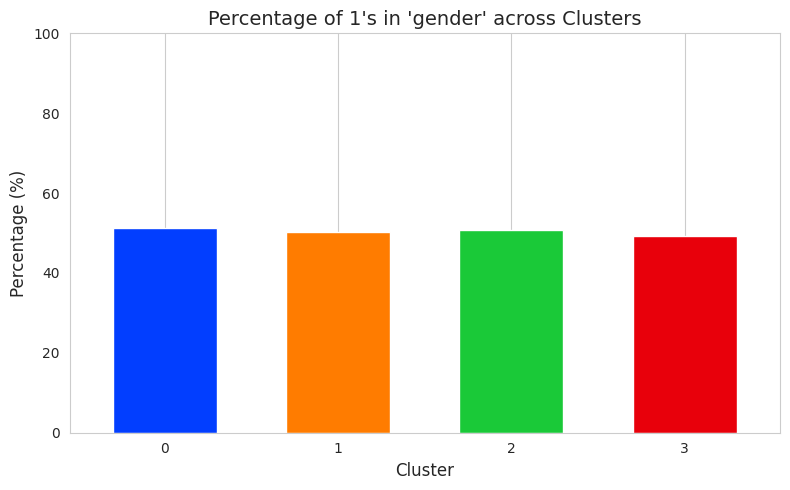

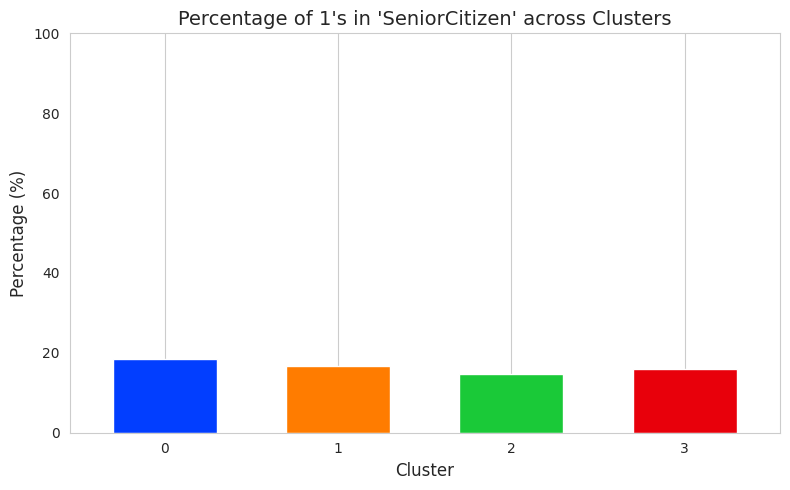

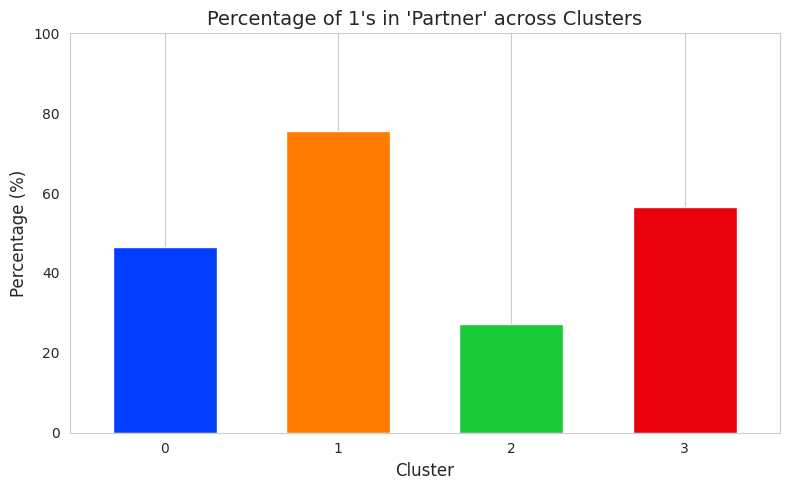

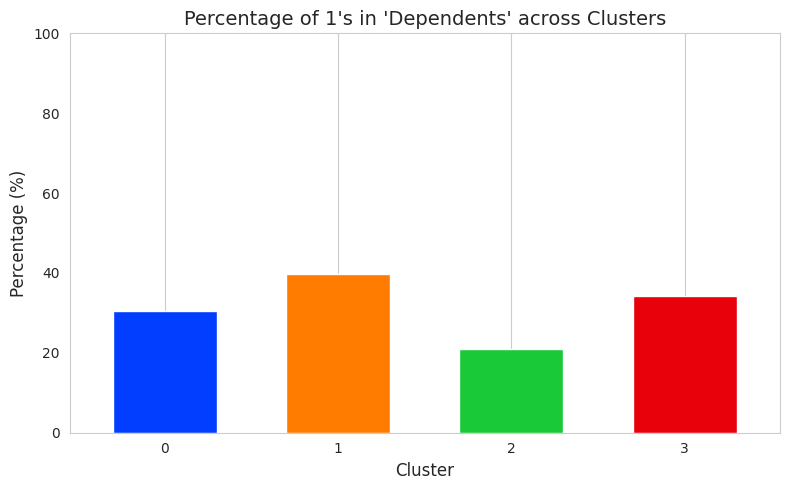

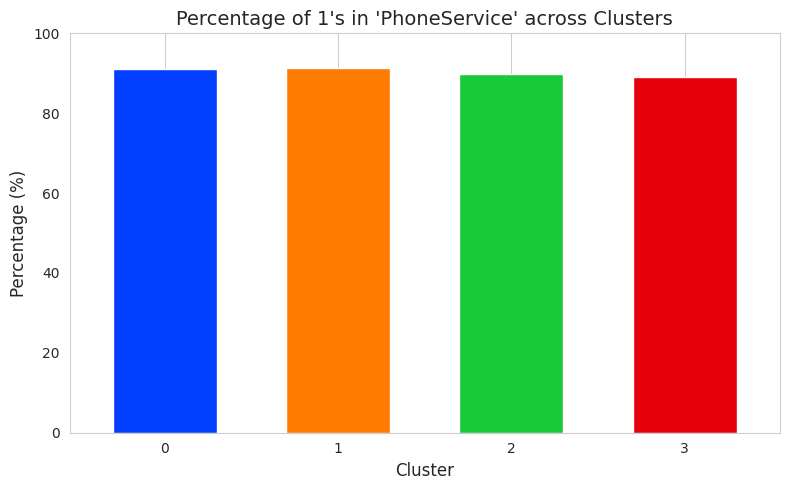

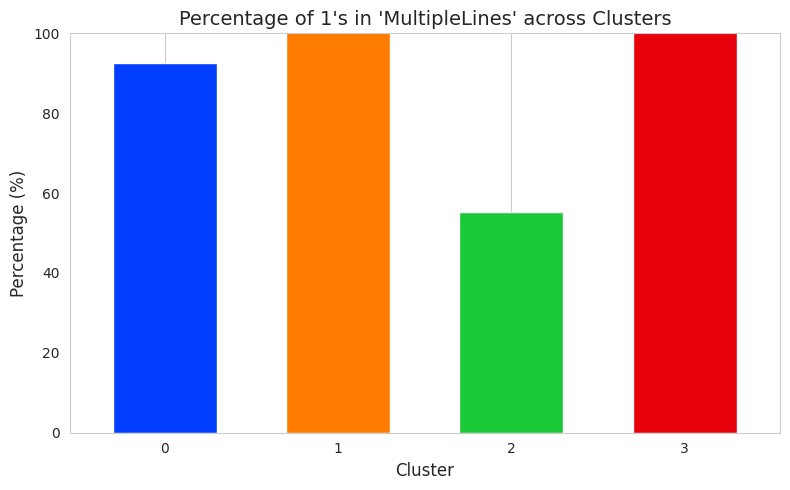

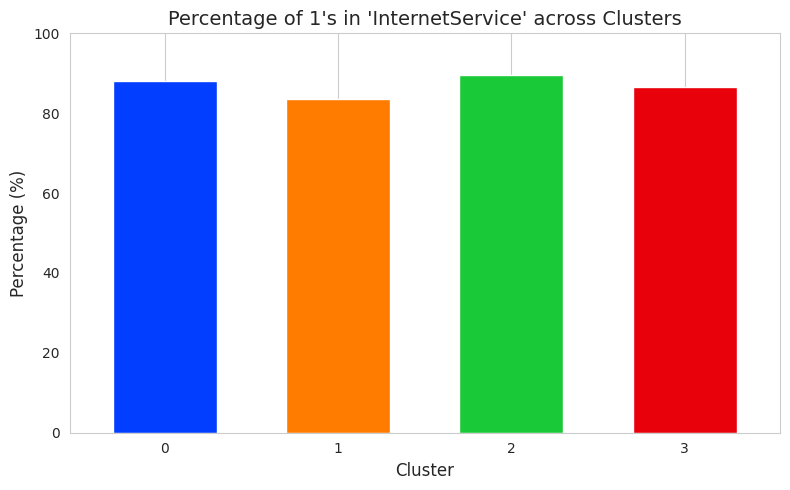

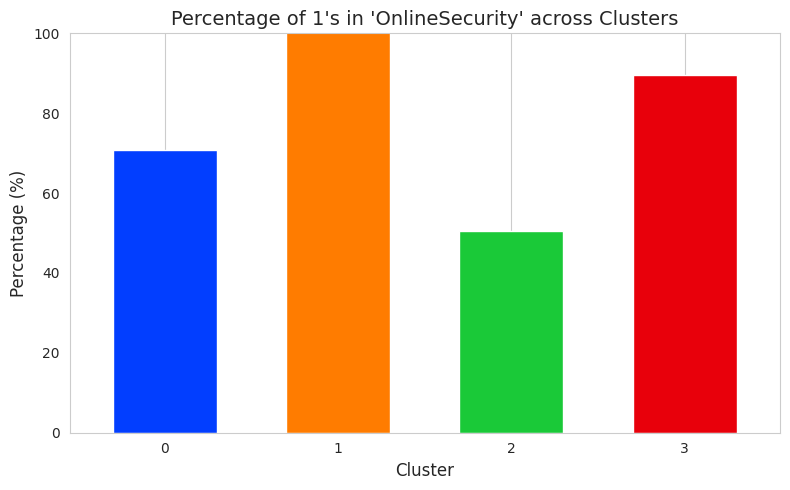

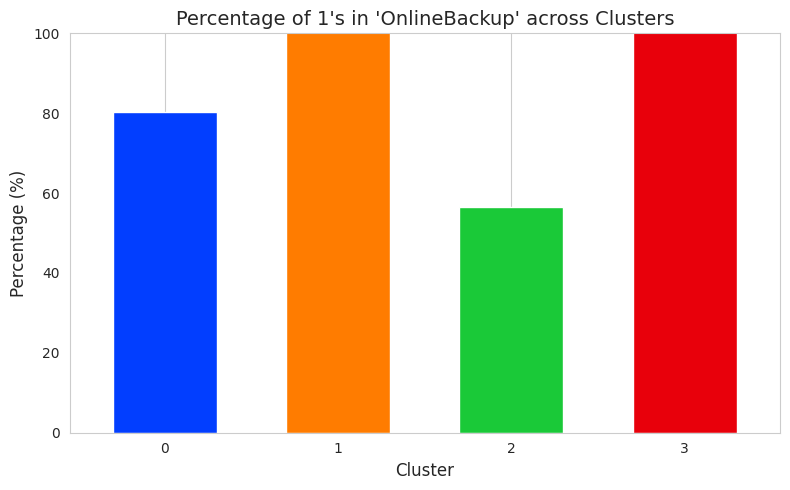

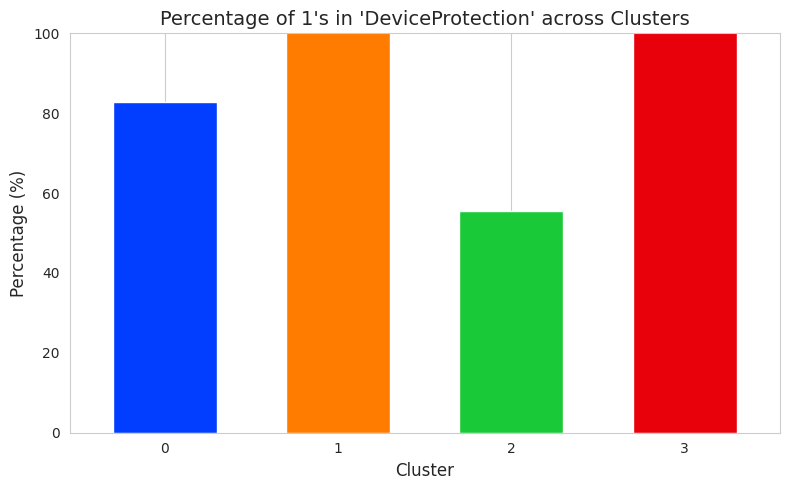

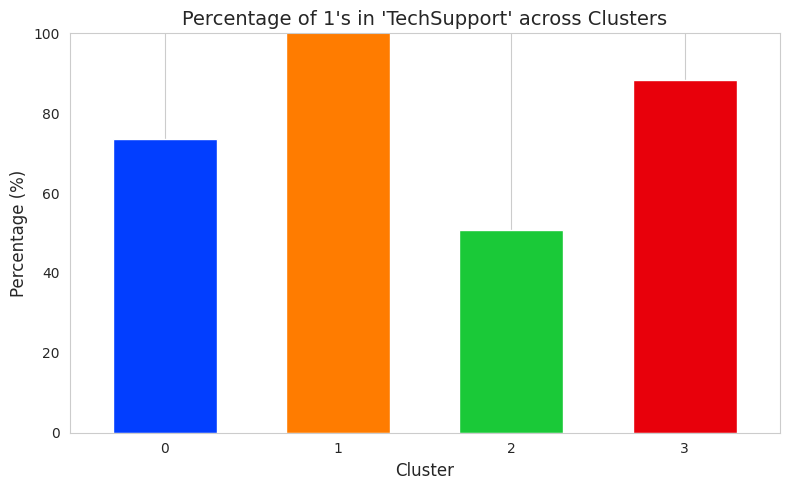

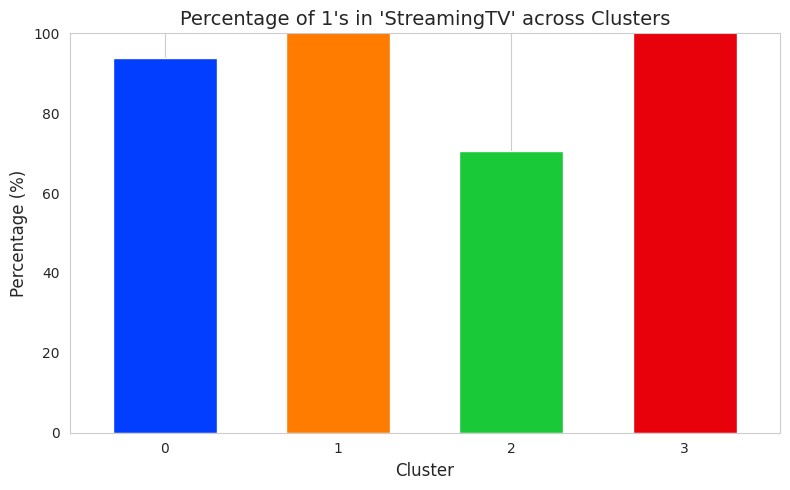

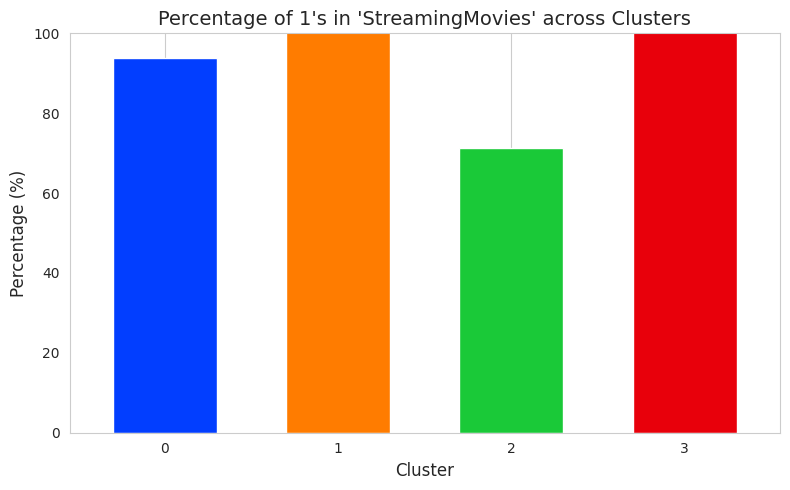

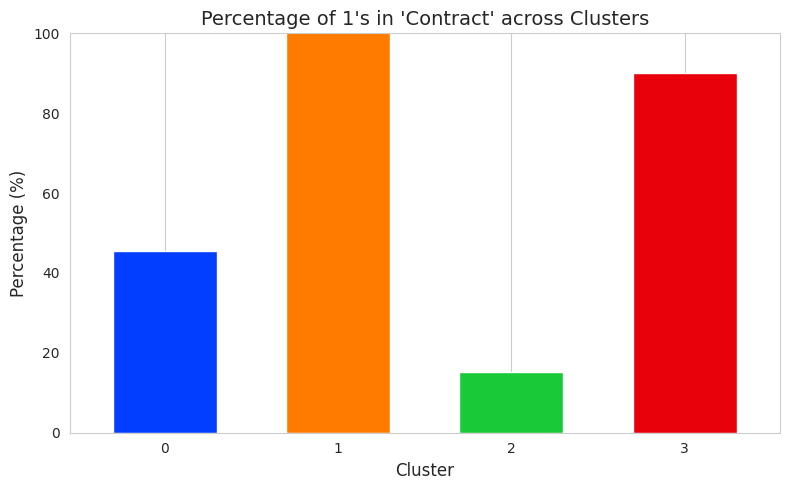

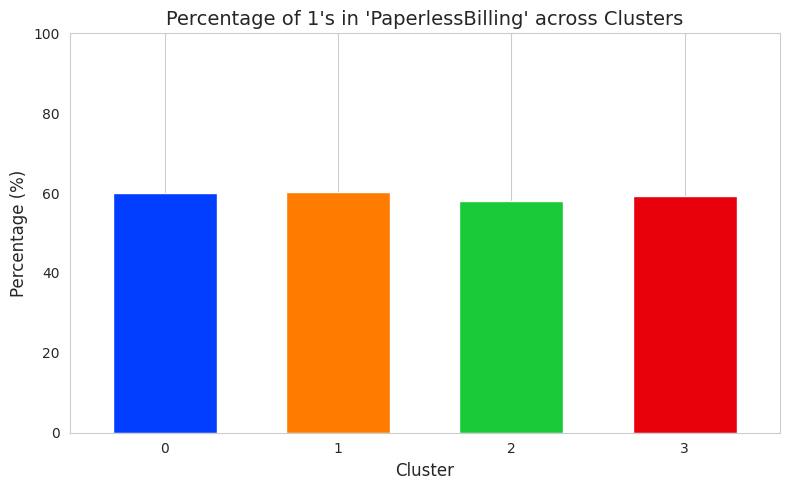

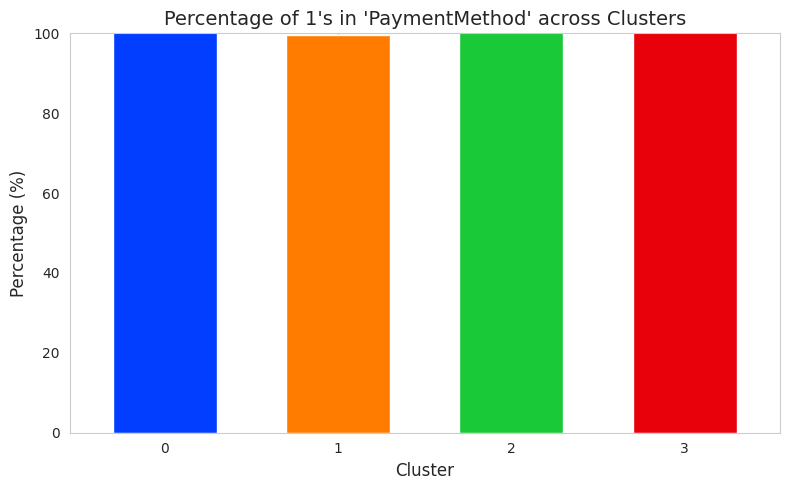

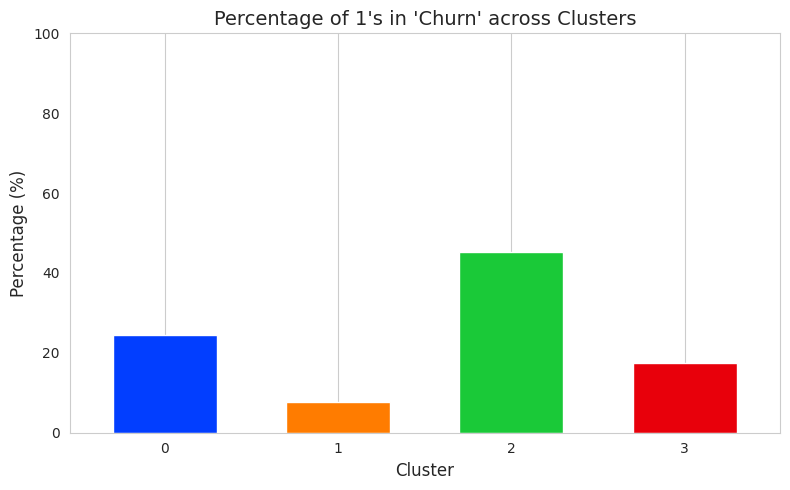

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe
df = pd.read_csv('Churn7043_clusterGAN_4clusters.csv')

# Identify original categorical columns (excluding 'tenure' and numerical columns)
numerical_cols = ['MonthlyCharges', 'TotalCharges']
original_categorical_cols = [col for col in df.columns if col not in numerical_cols + ['tenure', 'Cluster']]

# One-hot encode the necessary columns
df_encoded = pd.get_dummies(df[original_categorical_cols], drop_first=False)

# Add 'Cluster' back to the dataframe
df_encoded['Cluster'] = df['Cluster']

# Now all columns are 0/1 except 'Cluster'

# Setup for plotting
sns.set_style('whitegrid')
cluster_colors = sns.color_palette('bright', len(df['Cluster'].unique()))

# Create graphs
for col in df_encoded.columns:
    if col == 'Cluster':
        continue

    plt.figure(figsize=(8, 5))

    # Group by cluster and compute percentage of 1s
    cluster_percents = df_encoded.groupby('Cluster')[col].mean() * 100

    # Plot
    cluster_percents.plot(kind='bar', color=cluster_colors, width=0.6)

    plt.title(f"Percentage of 1's in '{col}' across Clusters", fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### testing 2 clusters (going with NMI, ARI, Completeness,Homogeneity,V-measure-since we have a lot of categorical features)

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.cluster import KMeans

# =========== Dataset Loading & Preprocessing ===========
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

numerical_cols = ['MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

quantile_scaler = QuantileTransformer(output_distribution='normal')
df[numerical_cols] = quantile_scaler.fit_transform(df[numerical_cols])

data = df.values
input_dim = data.shape[1]

# =========== ClusterGAN Components ===========
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

class Generator(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'generator'

    def __call__(self, z):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(z)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.x_dim)(fc2)

class Encoder(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'encoder'

    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(x)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.z_dim)(fc2)

# =========== Train ClusterGAN (only for 2 clusters) ===========
batch_size = 1024
num_epochs = 800
latent_dim = 16
n_clusters = 2  # Changed from 4 to 2

print("\n🔵 Training ClusterGAN for 2 clusters...")
total_start = time.time()

tf.reset_default_graph()

x_input = tf.placeholder(tf.float32, [None, input_dim])
z_input = tf.placeholder(tf.float32, [None, latent_dim])

G = Generator(z_dim=latent_dim, x_dim=input_dim)
E = Encoder(z_dim=latent_dim, x_dim=input_dim)

x_generated = G(z_input)
z_reconstructed = E(x_generated)
z_real = E(x_input)
z_encoded_output = E(x_input)

g_loss = tf.reduce_mean(tf.square(z_input - z_reconstructed))
e_loss = tf.reduce_mean(tf.square(z_input - z_real))

g_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss)
e_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(e_loss)

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

# =========== Training Loop ===========
start_train = time.time()
for epoch in range(num_epochs):
    current_batch_size = min(batch_size, data.shape[0])
    idx = np.random.choice(data.shape[0], current_batch_size, replace=False)
    real_batch = data[idx]
    z_batch = np.random.uniform(-0.6, 0.6, size=(current_batch_size, latent_dim))
    sess.run([g_optimizer, e_optimizer], feed_dict={x_input: real_batch, z_input: z_batch})

    if (epoch + 1) % 50 == 0:
        g_loss_val, e_loss_val = sess.run([g_loss, e_loss], feed_dict={x_input: real_batch, z_input: z_batch})
        elapsed = time.time() - start_train
        print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {g_loss_val:.4f} | E Loss: {e_loss_val:.4f} | Elapsed Time: {elapsed:.2f}s")

print(f"\n✅ Training Complete. Total Time: {(time.time() - total_start)/60:.2f} minutes.\n")

# =========== Embedding Extraction ===========
print("🧠 Getting latent embeddings...")
z_embeddings = sess.run(z_encoded_output, feed_dict={x_input: data})
sess.close()

# =========== Clustering ===========
print("🔵 Running KMeans with 2 clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(z_embeddings)

# Save cluster labels
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = cluster_labels

# Save to CSV
df_with_clusters.to_csv('Churn7043_clusterGAN_2clusters.csv', index=False)

print("\n✅ Cluster assignment completed and saved to 'Churn7043_clusterGAN_2clusters.csv'.")


2025-05-05 13:35:03.295371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746452103.497669      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746452103.551169      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🔵 Training ClusterGAN for 2 clusters...


I0000 00:00:1746452117.476402      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746452117.494029      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Epoch 50/800 | G Loss: 0.0114 | E Loss: 0.1565 | Elapsed Time: 2.91s
Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1353 | Elapsed Time: 3.04s
Epoch 150/800 | G Loss: 0.0014 | E Loss: 0.1320 | Elapsed Time: 3.17s
Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1268 | Elapsed Time: 3.30s
Epoch 250/800 | G Loss: 0.0009 | E Loss: 0.1253 | Elapsed Time: 3.42s
Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1242 | Elapsed Time: 3.55s
Epoch 350/800 | G Loss: 0.0008 | E Loss: 0.1233 | Elapsed Time: 3.68s
Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1226 | Elapsed Time: 3.80s
Epoch 450/800 | G Loss: 0.0006 | E Loss: 0.1225 | Elapsed Time: 3.93s
Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1226 | Elapsed Time: 4.06s
Epoch 550/800 | G Loss: 0.0005 | E Loss: 0.1212 | Elapsed Time: 4.21s
Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229 | Elapsed Time: 4.34s
Epoch 650/800 | G Loss: 0.0005 | E Loss: 0.1214 | Elapsed Time: 4.46s
Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1225 | Elapsed Time: 4.59s
Epoch 750/800 | G Los

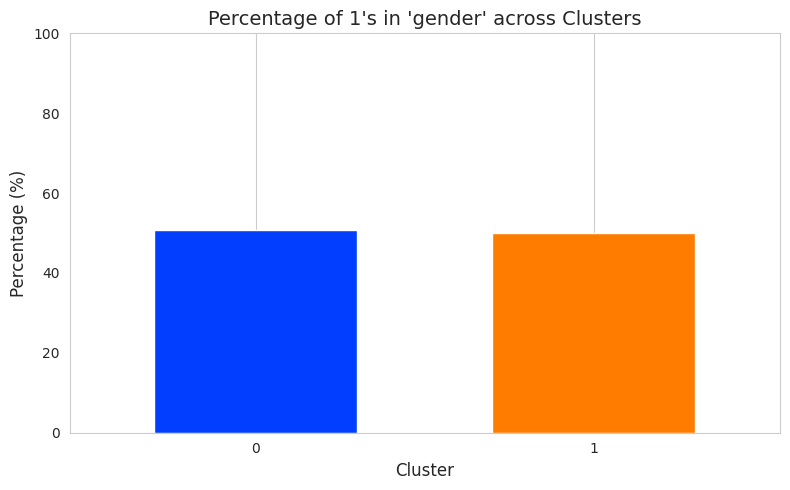

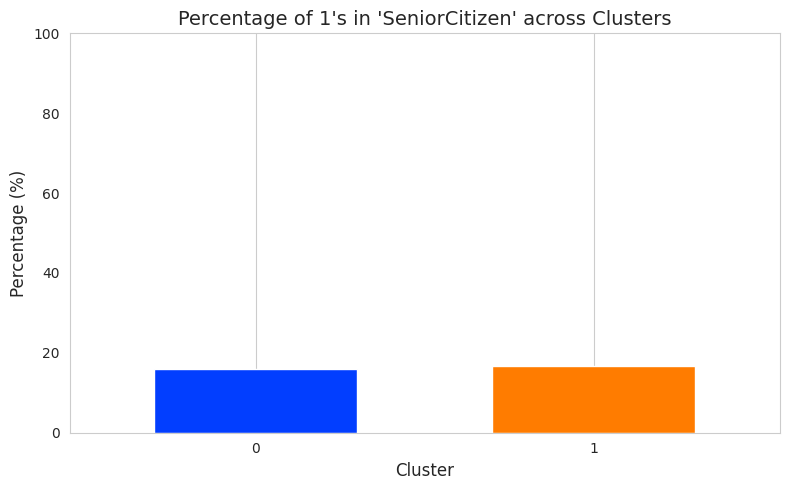

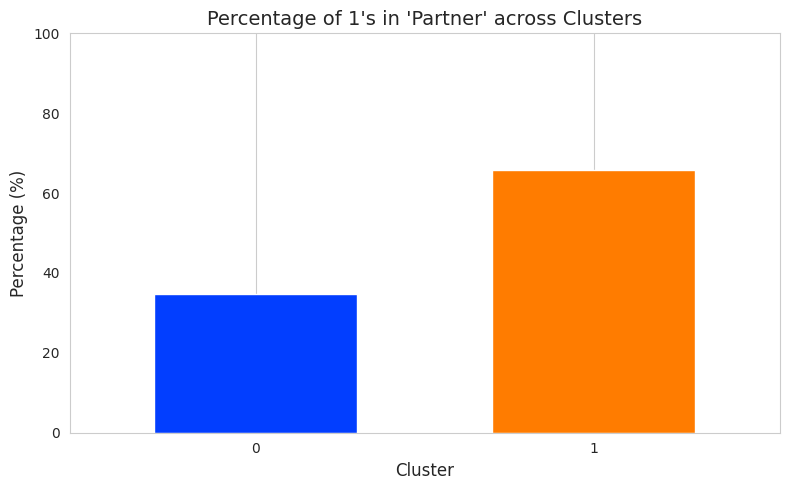

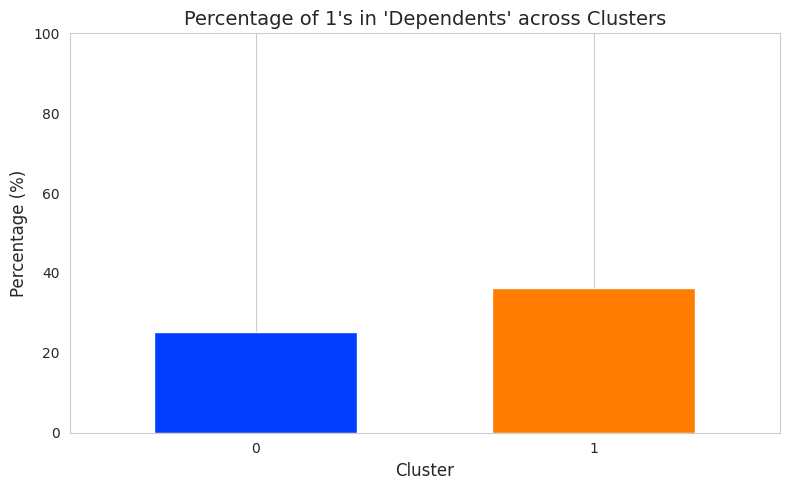

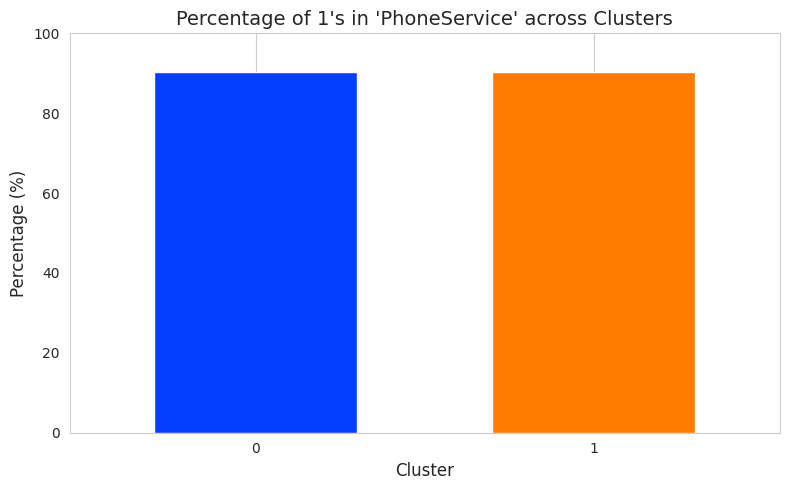

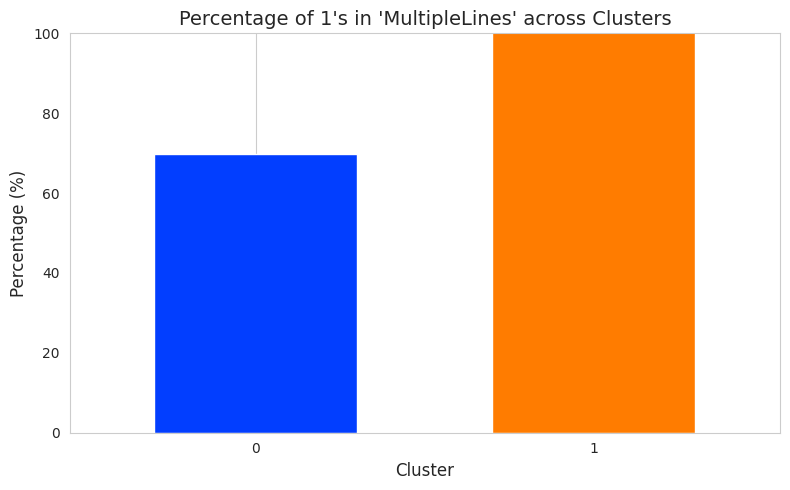

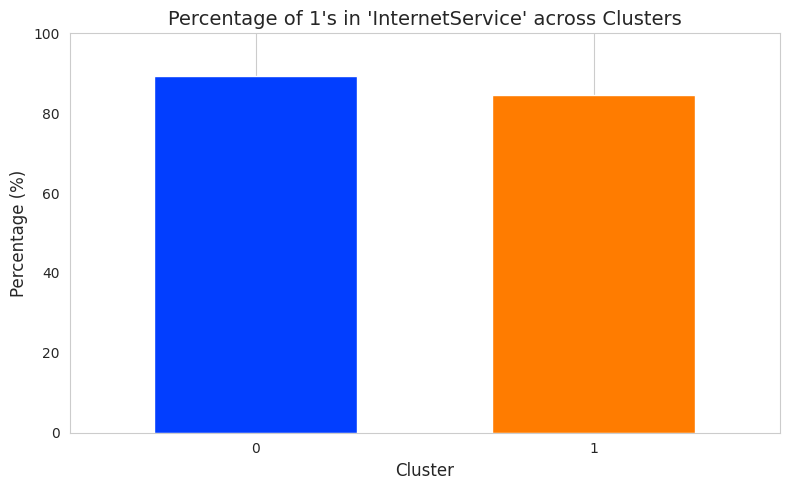

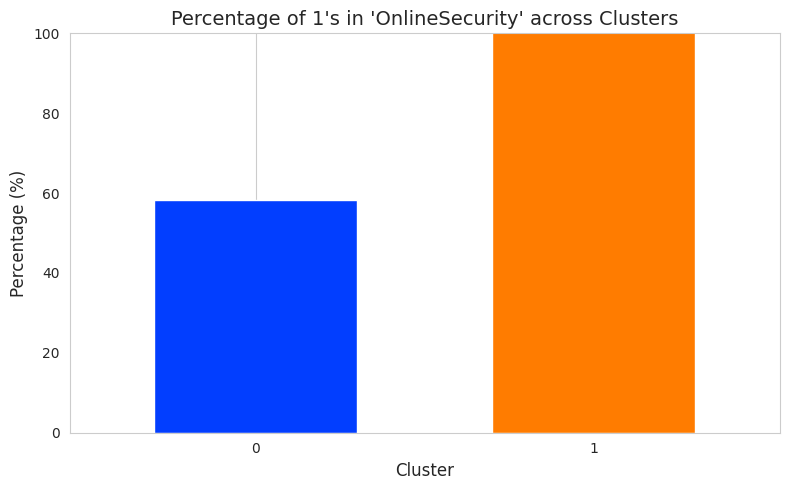

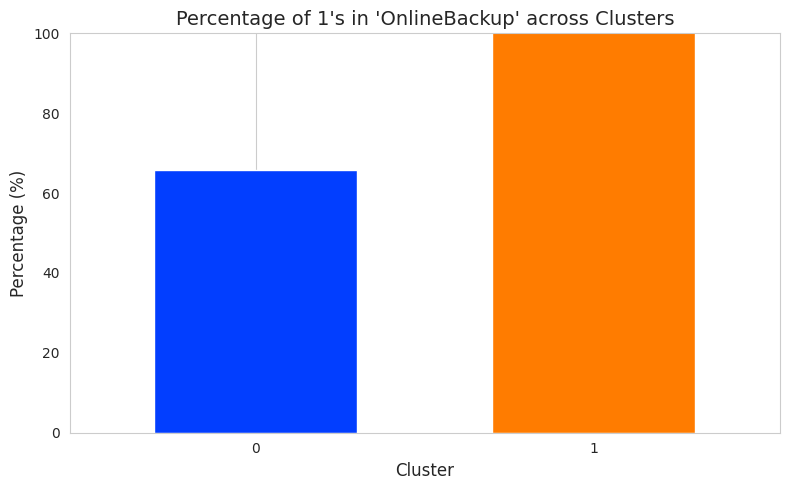

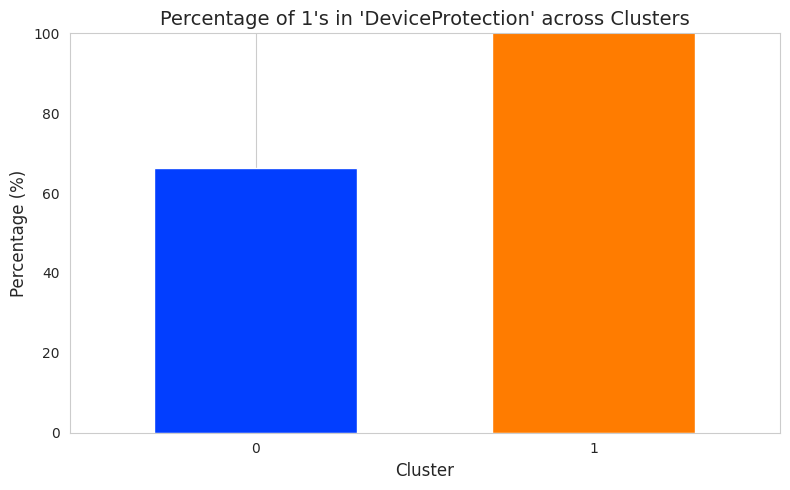

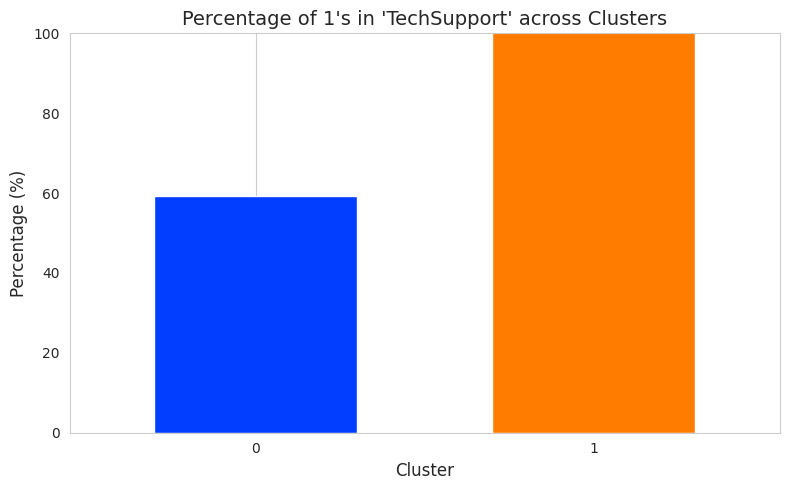

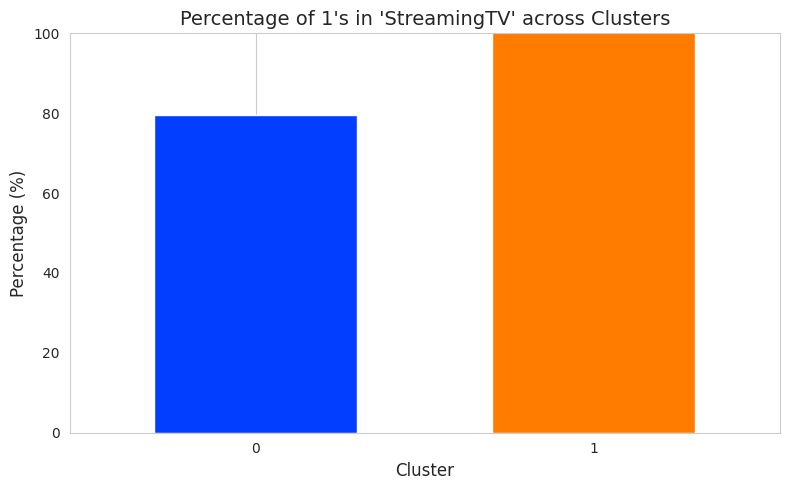

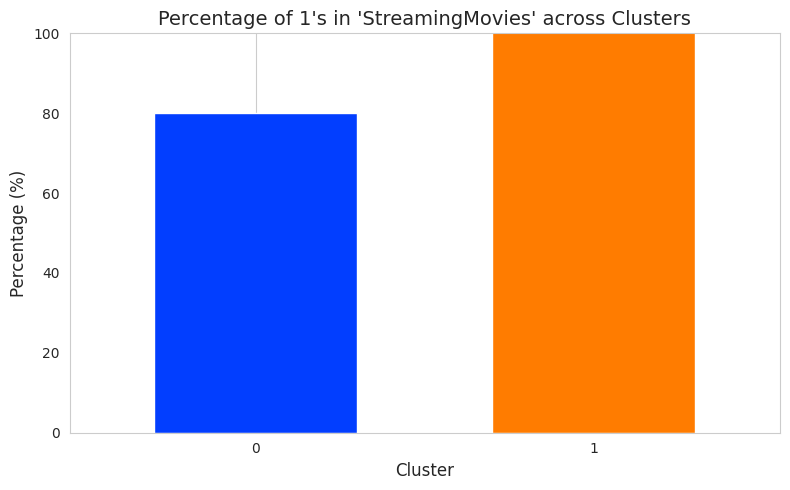

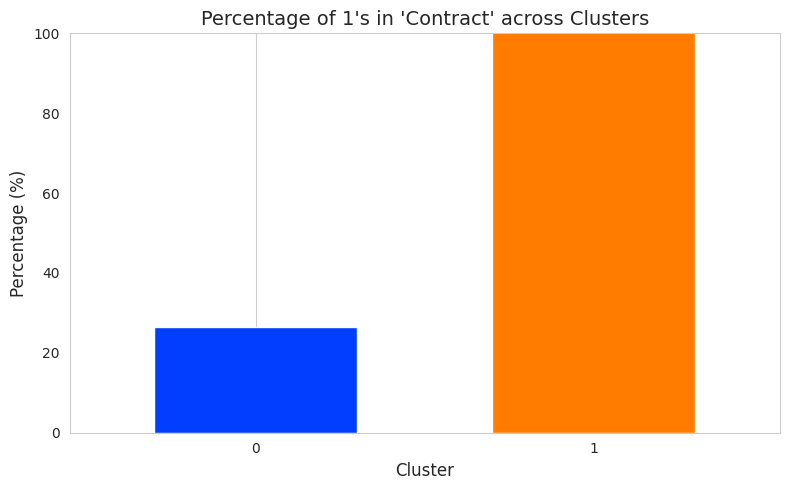

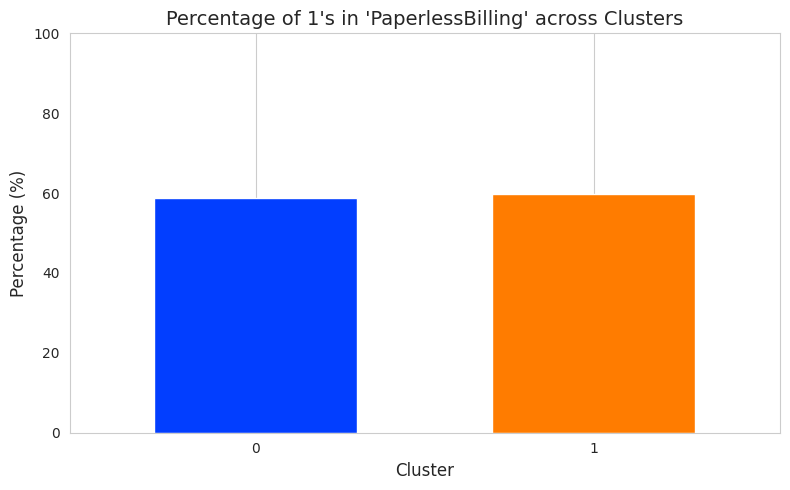

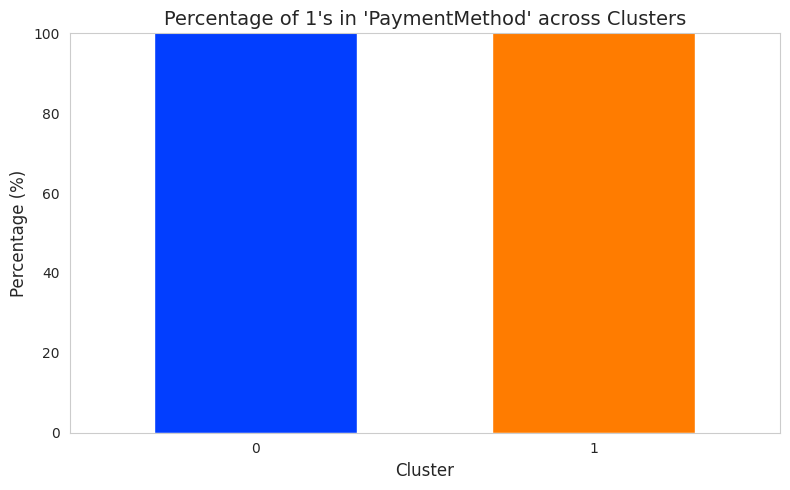

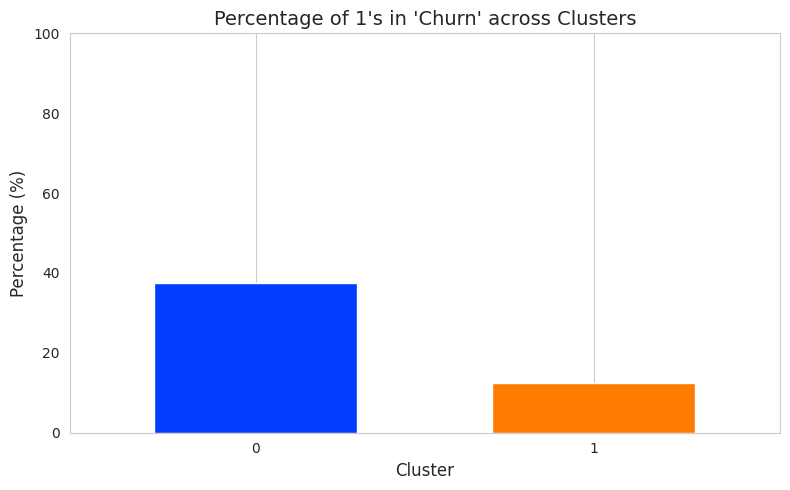

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe
df = pd.read_csv('Churn7043_clusterGAN_2clusters.csv')

# Identify original categorical columns (excluding 'tenure' and numerical columns)
numerical_cols = ['MonthlyCharges', 'TotalCharges']
original_categorical_cols = [col for col in df.columns if col not in numerical_cols + ['tenure', 'Cluster']]

# One-hot encode the necessary columns
df_encoded = pd.get_dummies(df[original_categorical_cols], drop_first=False)

# Add 'Cluster' back to the dataframe
df_encoded['Cluster'] = df['Cluster']

# Now all columns are 0/1 except 'Cluster'

# Setup for plotting
sns.set_style('whitegrid')
cluster_colors = sns.color_palette('bright', len(df['Cluster'].unique()))

# Create graphs
for col in df_encoded.columns:
    if col == 'Cluster':
        continue

    plt.figure(figsize=(8, 5))

    # Group by cluster and compute percentage of 1s
    cluster_percents = df_encoded.groupby('Cluster')[col].mean() * 100

    # Plot
    cluster_percents.plot(kind='bar', color=cluster_colors, width=0.6)

    plt.title(f"Percentage of 1's in '{col}' across Clusters", fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [2]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.cluster import KMeans
from itertools import combinations
from scipy.spatial.distance import hamming, jaccard

# =========== Dataset Loading & Preprocessing ===========
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Store the true labels before encoding
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(df['Churn'])  # Encode "Yes"/"No" to 0/1
df = df.drop(columns=['Churn'])  # Drop it from features

# Clean and drop numerical columns
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df = df.drop(columns=['MonthlyCharges', 'TotalCharges'])

# Label encode categorical features
for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])

data = df.values
input_dim = data.shape[1]

# =========== ClusterGAN Components ===========
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

class Generator(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'generator'

    def __call__(self, z):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(z)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.x_dim)(fc2)

class Encoder(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'encoder'

    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(x)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.z_dim)(fc2)

# =========== Helper for Hamming & Jaccard ===========
def intra_cluster_distances(X, labels, sample_fraction=0.2, random_seed=42):
    np.random.seed(random_seed)
    sample_indices = np.random.choice(len(X), int(len(X) * sample_fraction), replace=False)
    X_sampled = X[sample_indices]
    labels_sampled = labels[sample_indices]

    hamming_scores = []
    jaccard_scores = []
    for cluster in np.unique(labels_sampled):
        indices = np.where(labels_sampled == cluster)[0]
        if len(indices) < 2:
            continue
        pairs = combinations(indices, 2)
        h_sum, j_sum, count = 0, 0, 0
        for i, j in pairs:
            xi = X_sampled[i]
            xj = X_sampled[j]
            h_sum += hamming(xi, xj)
            j_sum += jaccard(xi != 0, xj != 0)
            count += 1
        if count > 0:
            hamming_scores.append(h_sum / count)
            jaccard_scores.append(j_sum / count)
    return np.mean(hamming_scores) if hamming_scores else -1, np.mean(jaccard_scores) if jaccard_scores else -1

# =========== Training Loop ===========
batch_size = 1024
num_epochs = 800
latent_dim = 16
results = []

print("\n🔁 Training ClusterGAN and Evaluating Clusters:")
total_start = time.time()

for n_clusters in range(2, 101):
    print(f"\n🔹 Starting training for K={n_clusters}...")
    tf.reset_default_graph()

    x_input = tf.placeholder(tf.float32, [None, input_dim])
    z_input = tf.placeholder(tf.float32, [None, latent_dim])

    G = Generator(z_dim=latent_dim, x_dim=input_dim)
    E = Encoder(z_dim=latent_dim, x_dim=input_dim)

    x_generated = G(z_input)
    z_reconstructed = E(x_generated)
    z_real = E(x_input)
    z_encoded_output = E(x_input)

    g_loss = tf.reduce_mean(tf.square(z_input - z_reconstructed))
    e_loss = tf.reduce_mean(tf.square(z_input - z_real))

    g_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss)
    e_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(e_loss)

    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        current_batch_size = min(batch_size, data.shape[0])
        idx = np.random.choice(data.shape[0], current_batch_size, replace=False)
        real_batch = data[idx]
        z_batch = np.random.uniform(-0.6, 0.6, size=(current_batch_size, latent_dim))
        sess.run([g_optimizer, e_optimizer], feed_dict={x_input: real_batch, z_input: z_batch})

        if (epoch + 1) % 100 == 0 or epoch == 0:
            g_loss_val, e_loss_val = sess.run([g_loss, e_loss], feed_dict={x_input: real_batch, z_input: z_batch})
            print(f"   Epoch {epoch+1}/{num_epochs} | G Loss: {g_loss_val:.4f} | E Loss: {e_loss_val:.4f}")

    print(f"✅ Training complete for K={n_clusters}.")

    z_embeddings = sess.run(z_encoded_output, feed_dict={x_input: data})
    sess.close()

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(z_embeddings)

    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)

    hamming_avg, jaccard_avg = intra_cluster_distances(data, cluster_labels)

    print(f"K={n_clusters:3d} | NMI: {nmi:.4f} | ARI: {ari:.4f} | Homogeneity: {homogeneity:.4f} | "
          f"Completeness: {completeness:.4f} | V-Measure: {v_measure:.4f} | "
          f"Hamming: {hamming_avg:.4f} | Jaccard: {jaccard_avg:.4f}")

    results.append({
        "n_clusters": n_clusters,
        "NMI": nmi,
        "ARI": ari,
        "Homogeneity": homogeneity,
        "Completeness": completeness,
        "V-Measure": v_measure,
        "Avg_Hamming": hamming_avg,
        "Avg_Jaccard": jaccard_avg
    })

# =========== Save Results ===========
results_df = pd.DataFrame(results)
results_df.to_csv('Churn7043_clusterGAN_clustering_metrics_categorical_only.csv', index=False)

print(f"\n✅ All Trainings Complete. Total Time: {(time.time() - total_start)/60:.2f} minutes.")
print("📁 Results saved to 'Churn7043_clusterGAN_clustering_metrics_categorical_only.csv'")



🔁 Training ClusterGAN and Evaluating Clusters:

🔹 Starting training for K=2...


I0000 00:00:1746458809.925535      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 6.0525
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1322
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1259
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1244
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1206
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1200
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1203
✅ Training complete for K=2.
K=  2 | NMI: 0.0717 | ARI: 0.0365 | Homogeneity: 0.0783 | Completeness: 0.0661 | V-Measure: 0.0717 | Hamming: 0.5455 | Jaccard: 0.5066

🔹 Starting training for K=3...


I0000 00:00:1746458826.358703      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1192 | E Loss: 3.3207
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1300
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1239
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1208
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1219
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1217
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=3.
K=  3 | NMI: 0.0701 | ARI: 0.0324 | Homogeneity: 0.1006 | Completeness: 0.0538 | V-Measure: 0.0701 | Hamming: 0.5419 | Jaccard: 0.5042

🔹 Starting training for K=4...


I0000 00:00:1746458838.958582      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1179 | E Loss: 12.2992
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1460
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1312
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1238
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1245
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1235
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1232
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1223
✅ Training complete for K=4.
K=  4 | NMI: 0.0670 | ARI: 0.0243 | Homogeneity: 0.1123 | Completeness: 0.0478 | V-Measure: 0.0670 | Hamming: 0.5408 | Jaccard: 0.5016

🔹 Starting training for K=5...


I0000 00:00:1746458850.381006      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 3.0694
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1348
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1259
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1217
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1210
✅ Training complete for K=5.
K=  5 | NMI: 0.0595 | ARI: 0.0184 | Homogeneity: 0.1108 | Completeness: 0.0407 | V-Measure: 0.0595 | Hamming: 0.5398 | Jaccard: 0.5018

🔹 Starting training for K=6...


I0000 00:00:1746458860.284146      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1178 | E Loss: 7.0737
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1410
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1287
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1227
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=6.
K=  6 | NMI: 0.0580 | ARI: 0.0217 | Homogeneity: 0.1174 | Completeness: 0.0385 | V-Measure: 0.0580 | Hamming: 0.5394 | Jaccard: 0.5058

🔹 Starting training for K=7...


I0000 00:00:1746458869.118372      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1185 | E Loss: 18.7675
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1444
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1320
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1253
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1258
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1241
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1240
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1219
   Epoch 800/800 | G Loss: 0.0003 | E Loss: 0.1222
✅ Training complete for K=7.
K=  7 | NMI: 0.0540 | ARI: 0.0155 | Homogeneity: 0.1161 | Completeness: 0.0351 | V-Measure: 0.0540 | Hamming: 0.5391 | Jaccard: 0.5029

🔹 Starting training for K=8...


I0000 00:00:1746458877.813742      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1184 | E Loss: 6.9754
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1388
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1282
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1217
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1238
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1227
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=8.
K=  8 | NMI: 0.0546 | ARI: 0.0120 | Homogeneity: 0.1227 | Completeness: 0.0351 | V-Measure: 0.0546 | Hamming: 0.5403 | Jaccard: 0.5036

🔹 Starting training for K=9...


I0000 00:00:1746458886.512719      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1157 | E Loss: 11.9461
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1460
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1331
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1250
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1244
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1237
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1234
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1217
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=9.
K=  9 | NMI: 0.0494 | ARI: 0.0150 | Homogeneity: 0.1169 | Completeness: 0.0313 | V-Measure: 0.0494 | Hamming: 0.5379 | Jaccard: 0.5053

🔹 Starting training for K=10...


I0000 00:00:1746458894.340785      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1179 | E Loss: 4.2670
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1342
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1260
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1217
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=10.
K= 10 | NMI: 0.0502 | ARI: 0.0107 | Homogeneity: 0.1224 | Completeness: 0.0316 | V-Measure: 0.0502 | Hamming: 0.5390 | Jaccard: 0.5043

🔹 Starting training for K=11...


I0000 00:00:1746458902.077899      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 3.9754
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1314
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1248
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1209
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1229
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1216
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=11.
K= 11 | NMI: 0.0494 | ARI: 0.0088 | Homogeneity: 0.1240 | Completeness: 0.0308 | V-Measure: 0.0494 | Hamming: 0.5399 | Jaccard: 0.5055

🔹 Starting training for K=12...


I0000 00:00:1746458909.821211      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1181 | E Loss: 2.3701
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1325
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1241
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1208
   Epoch 400/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1218
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0003 | E Loss: 0.1217
✅ Training complete for K=12.
K= 12 | NMI: 0.0490 | ARI: 0.0086 | Homogeneity: 0.1281 | Completeness: 0.0303 | V-Measure: 0.0490 | Hamming: 0.5339 | Jaccard: 0.4998

🔹 Starting training for K=13...


I0000 00:00:1746458917.817089      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 5.7215
   Epoch 100/800 | G Loss: 0.0035 | E Loss: 0.1354
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1266
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1203
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1212
✅ Training complete for K=13.
K= 13 | NMI: 0.0472 | ARI: 0.0095 | Homogeneity: 0.1257 | Completeness: 0.0291 | V-Measure: 0.0472 | Hamming: 0.5368 | Jaccard: 0.5060

🔹 Starting training for K=14...


I0000 00:00:1746458925.210210      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1177 | E Loss: 10.4454
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1419
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1292
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1235
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1237
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1231
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1219
✅ Training complete for K=14.
K= 14 | NMI: 0.0449 | ARI: 0.0044 | Homogeneity: 0.1213 | Completeness: 0.0276 | V-Measure: 0.0449 | Hamming: 0.5388 | Jaccard: 0.5050

🔹 Starting training for K=15...


I0000 00:00:1746458932.470827      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1193 | E Loss: 5.0358
   Epoch 100/800 | G Loss: 0.0030 | E Loss: 0.1350
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1254
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1210
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1221
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1216
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1210
✅ Training complete for K=15.
K= 15 | NMI: 0.0496 | ARI: 0.0124 | Homogeneity: 0.1392 | Completeness: 0.0302 | V-Measure: 0.0496 | Hamming: 0.5241 | Jaccard: 0.4923

🔹 Starting training for K=16...


I0000 00:00:1746458939.190108      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1181 | E Loss: 7.4647
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1413
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1317
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1235
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1241
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1230
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1221
✅ Training complete for K=16.
K= 16 | NMI: 0.0444 | ARI: 0.0101 | Homogeneity: 0.1275 | Completeness: 0.0269 | V-Measure: 0.0444 | Hamming: 0.5247 | Jaccard: 0.4979

🔹 Starting training for K=17...


I0000 00:00:1746458946.685843      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 8.0361
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1399
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1289
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1230
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=17.
K= 17 | NMI: 0.0455 | ARI: 0.0089 | Homogeneity: 0.1316 | Completeness: 0.0275 | V-Measure: 0.0455 | Hamming: 0.5349 | Jaccard: 0.5036

🔹 Starting training for K=18...


I0000 00:00:1746458953.437474      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1189 | E Loss: 6.6768
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1352
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1286
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1230
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1243
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1230
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1230
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1212
✅ Training complete for K=18.
K= 18 | NMI: 0.0424 | ARI: 0.0070 | Homogeneity: 0.1261 | Completeness: 0.0255 | V-Measure: 0.0424 | Hamming: 0.5183 | Jaccard: 0.4869

🔹 Starting training for K=19...


I0000 00:00:1746458959.956481      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1163 | E Loss: 8.5827
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1357
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1270
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1220
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=19.
K= 19 | NMI: 0.0424 | ARI: 0.0062 | Homogeneity: 0.1274 | Completeness: 0.0254 | V-Measure: 0.0424 | Hamming: 0.5243 | Jaccard: 0.4906

🔹 Starting training for K=20...


I0000 00:00:1746458966.641871      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1206 | E Loss: 3.6051
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1366
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1270
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1216
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0006 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=20.
K= 20 | NMI: 0.0435 | ARI: 0.0041 | Homogeneity: 0.1318 | Completeness: 0.0260 | V-Measure: 0.0435 | Hamming: 0.5281 | Jaccard: 0.4965

🔹 Starting training for K=21...


I0000 00:00:1746458973.069151      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1186 | E Loss: 3.7939
   Epoch 100/800 | G Loss: 0.0028 | E Loss: 0.1350
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1256
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1211
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0006 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=21.
K= 21 | NMI: 0.0460 | ARI: 0.0078 | Homogeneity: 0.1424 | Completeness: 0.0275 | V-Measure: 0.0460 | Hamming: 0.5129 | Jaccard: 0.4843

🔹 Starting training for K=22...


I0000 00:00:1746458979.526910      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1170 | E Loss: 6.9778
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1385
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1272
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1219
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=22.
K= 22 | NMI: 0.0406 | ARI: 0.0065 | Homogeneity: 0.1276 | Completeness: 0.0242 | V-Measure: 0.0406 | Hamming: 0.4964 | Jaccard: 0.4828

🔹 Starting training for K=23...


I0000 00:00:1746458986.032592      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1157 | E Loss: 6.5621
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1365
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1263
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0009 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=23.
K= 23 | NMI: 0.0443 | ARI: 0.0058 | Homogeneity: 0.1406 | Completeness: 0.0263 | V-Measure: 0.0443 | Hamming: 0.5011 | Jaccard: 0.4783

🔹 Starting training for K=24...


I0000 00:00:1746458992.743237      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1174 | E Loss: 8.4559
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1395
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1289
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1241
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0004 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0003 | E Loss: 0.1213
✅ Training complete for K=24.
K= 24 | NMI: 0.0411 | ARI: 0.0068 | Homogeneity: 0.1322 | Completeness: 0.0243 | V-Measure: 0.0411 | Hamming: 0.5201 | Jaccard: 0.4974

🔹 Starting training for K=25...


I0000 00:00:1746458999.142930      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1189 | E Loss: 6.2072
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1376
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1281
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1226
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1233
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1219
✅ Training complete for K=25.
K= 25 | NMI: 0.0593 | ARI: 0.0096 | Homogeneity: 0.1922 | Completeness: 0.0351 | V-Measure: 0.0593 | Hamming: 0.4804 | Jaccard: 0.4624

🔹 Starting training for K=26...


I0000 00:00:1746459005.840351      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1182 | E Loss: 6.8504
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1347
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1262
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1216
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1209
✅ Training complete for K=26.
K= 26 | NMI: 0.0420 | ARI: 0.0046 | Homogeneity: 0.1373 | Completeness: 0.0248 | V-Measure: 0.0420 | Hamming: 0.5107 | Jaccard: 0.4866

🔹 Starting training for K=27...


I0000 00:00:1746459012.821261      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 6.9083
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1381
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1268
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1222
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=27.
K= 27 | NMI: 0.0418 | ARI: 0.0030 | Homogeneity: 0.1373 | Completeness: 0.0246 | V-Measure: 0.0418 | Hamming: 0.5207 | Jaccard: 0.4898

🔹 Starting training for K=28...


I0000 00:00:1746459019.112050      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1182 | E Loss: 9.6507
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1365
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1290
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1221
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1234
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1229
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1212
✅ Training complete for K=28.
K= 28 | NMI: 0.0408 | ARI: 0.0045 | Homogeneity: 0.1357 | Completeness: 0.0240 | V-Measure: 0.0408 | Hamming: 0.5097 | Jaccard: 0.4842

🔹 Starting training for K=29...


I0000 00:00:1746459025.648178      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 6.2095
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1368
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1264
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1215
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1234
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1212
✅ Training complete for K=29.
K= 29 | NMI: 0.0430 | ARI: 0.0060 | Homogeneity: 0.1446 | Completeness: 0.0253 | V-Measure: 0.0430 | Hamming: 0.5044 | Jaccard: 0.4810

🔹 Starting training for K=30...


I0000 00:00:1746459032.523180      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1188 | E Loss: 6.3092
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1358
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1268
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1222
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1229
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=30.
K= 30 | NMI: 0.0497 | ARI: 0.0081 | Homogeneity: 0.1691 | Completeness: 0.0291 | V-Measure: 0.0497 | Hamming: 0.4893 | Jaccard: 0.4790

🔹 Starting training for K=31...


I0000 00:00:1746459038.840869      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1146 | E Loss: 5.7774
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1405
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1282
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1223
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1233
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0004 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=31.
K= 31 | NMI: 0.0427 | ARI: 0.0044 | Homogeneity: 0.1453 | Completeness: 0.0250 | V-Measure: 0.0427 | Hamming: 0.4986 | Jaccard: 0.4736

🔹 Starting training for K=32...


I0000 00:00:1746459045.259421      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1167 | E Loss: 2.4273
   Epoch 100/800 | G Loss: 0.0082 | E Loss: 0.1328
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1256
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1208
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1219
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1218
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1220
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1215
✅ Training complete for K=32.
K= 32 | NMI: 0.0440 | ARI: 0.0075 | Homogeneity: 0.1521 | Completeness: 0.0257 | V-Measure: 0.0440 | Hamming: 0.4920 | Jaccard: 0.4700

🔹 Starting training for K=33...


I0000 00:00:1746459051.515810      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1167 | E Loss: 3.3998
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1352
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1263
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1211
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1219
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=33.
K= 33 | NMI: 0.0431 | ARI: 0.0046 | Homogeneity: 0.1495 | Completeness: 0.0252 | V-Measure: 0.0431 | Hamming: 0.4921 | Jaccard: 0.4769

🔹 Starting training for K=34...


I0000 00:00:1746459057.821767      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1191 | E Loss: 2.6500
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1303
   Epoch 200/800 | G Loss: 0.0013 | E Loss: 0.1240
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1201
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1220
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0006 | E Loss: 0.1210
✅ Training complete for K=34.
K= 34 | NMI: 0.0380 | ARI: 0.0061 | Homogeneity: 0.1324 | Completeness: 0.0222 | V-Measure: 0.0380 | Hamming: 0.5143 | Jaccard: 0.4942

🔹 Starting training for K=35...


I0000 00:00:1746459064.129633      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1155 | E Loss: 3.1873
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1345
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1255
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1225
   Epoch 600/800 | G Loss: 0.0004 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1209
✅ Training complete for K=35.
K= 35 | NMI: 0.0456 | ARI: 0.0047 | Homogeneity: 0.1601 | Completeness: 0.0266 | V-Measure: 0.0456 | Hamming: 0.4905 | Jaccard: 0.4697

🔹 Starting training for K=36...


I0000 00:00:1746459070.402932      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1171 | E Loss: 10.3356
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1414
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1302
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1231
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1232
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=36.
K= 36 | NMI: 0.0482 | ARI: 0.0045 | Homogeneity: 0.1704 | Completeness: 0.0281 | V-Measure: 0.0482 | Hamming: 0.4825 | Jaccard: 0.4636

🔹 Starting training for K=37...


I0000 00:00:1746459076.918616      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 4.6366
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1348
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1262
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1210
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1227
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1219
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1220
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=37.
K= 37 | NMI: 0.0410 | ARI: 0.0045 | Homogeneity: 0.1462 | Completeness: 0.0239 | V-Measure: 0.0410 | Hamming: 0.4995 | Jaccard: 0.4799

🔹 Starting training for K=38...


I0000 00:00:1746459083.225871      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1170 | E Loss: 3.6692
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1349
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1266
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1210
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1204
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1210
✅ Training complete for K=38.
K= 38 | NMI: 0.0439 | ARI: 0.0055 | Homogeneity: 0.1576 | Completeness: 0.0255 | V-Measure: 0.0439 | Hamming: 0.5068 | Jaccard: 0.4851

🔹 Starting training for K=39...


I0000 00:00:1746459089.370773      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1195 | E Loss: 7.9968
   Epoch 100/800 | G Loss: 0.0028 | E Loss: 0.1440
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1303
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1238
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1246
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1229
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1234
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1218
✅ Training complete for K=39.
K= 39 | NMI: 0.0470 | ARI: 0.0049 | Homogeneity: 0.1701 | Completeness: 0.0272 | V-Measure: 0.0470 | Hamming: 0.4834 | Jaccard: 0.4665

🔹 Starting training for K=40...


I0000 00:00:1746459095.809937      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 9.2812
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1364
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1276
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1225
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1239
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1219
✅ Training complete for K=40.
K= 40 | NMI: 0.0428 | ARI: 0.0044 | Homogeneity: 0.1551 | Completeness: 0.0249 | V-Measure: 0.0428 | Hamming: 0.4974 | Jaccard: 0.4801

🔹 Starting training for K=41...


I0000 00:00:1746459102.322195      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 4.4314
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1343
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1267
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1215
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=41.
K= 41 | NMI: 0.0403 | ARI: 0.0038 | Homogeneity: 0.1477 | Completeness: 0.0234 | V-Measure: 0.0403 | Hamming: 0.4945 | Jaccard: 0.4718

🔹 Starting training for K=42...


I0000 00:00:1746459108.709881      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1168 | E Loss: 2.5584
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1308
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1246
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1199
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1215
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0006 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1210
✅ Training complete for K=42.
K= 42 | NMI: 0.0411 | ARI: 0.0043 | Homogeneity: 0.1505 | Completeness: 0.0238 | V-Measure: 0.0411 | Hamming: 0.4757 | Jaccard: 0.4732

🔹 Starting training for K=43...


I0000 00:00:1746459115.049193      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 6.2441
   Epoch 100/800 | G Loss: 0.0028 | E Loss: 0.1385
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1274
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1229
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=43.
K= 43 | NMI: 0.0405 | ARI: 0.0039 | Homogeneity: 0.1492 | Completeness: 0.0234 | V-Measure: 0.0405 | Hamming: 0.4917 | Jaccard: 0.4759

🔹 Starting training for K=44...


I0000 00:00:1746459121.219172      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1198 | E Loss: 13.3639
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1369
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1295
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1235
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1237
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1233
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1218
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=44.
K= 44 | NMI: 0.0443 | ARI: 0.0038 | Homogeneity: 0.1640 | Completeness: 0.0256 | V-Measure: 0.0443 | Hamming: 0.4947 | Jaccard: 0.4771

🔹 Starting training for K=45...


I0000 00:00:1746459127.682396      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1174 | E Loss: 7.2383
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1332
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1259
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1210
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1211
✅ Training complete for K=45.
K= 45 | NMI: 0.0466 | ARI: 0.0056 | Homogeneity: 0.1744 | Completeness: 0.0269 | V-Measure: 0.0466 | Hamming: 0.4788 | Jaccard: 0.4644

🔹 Starting training for K=46...


I0000 00:00:1746459134.356673      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1196 | E Loss: 7.4889
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1409
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1299
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1231
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1236
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1230
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=46.
K= 46 | NMI: 0.0358 | ARI: 0.0035 | Homogeneity: 0.1345 | Completeness: 0.0207 | V-Measure: 0.0358 | Hamming: 0.4862 | Jaccard: 0.4810

🔹 Starting training for K=47...


I0000 00:00:1746459140.669937      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1172 | E Loss: 6.6143
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1367
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1282
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1221
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1234
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=47.
K= 47 | NMI: 0.0429 | ARI: 0.0046 | Homogeneity: 0.1624 | Completeness: 0.0247 | V-Measure: 0.0429 | Hamming: 0.4846 | Jaccard: 0.4633

🔹 Starting training for K=48...


I0000 00:00:1746459146.859467      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1194 | E Loss: 12.9779
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1450
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1317
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1241
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1243
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1233
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1231
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=48.
K= 48 | NMI: 0.0529 | ARI: 0.0046 | Homogeneity: 0.1990 | Completeness: 0.0305 | V-Measure: 0.0529 | Hamming: 0.4556 | Jaccard: 0.4421

🔹 Starting training for K=49...


I0000 00:00:1746459153.077652      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1167 | E Loss: 2.4690
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1298
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1242
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1200
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1217
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1204
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=49.
K= 49 | NMI: 0.0423 | ARI: 0.0042 | Homogeneity: 0.1613 | Completeness: 0.0243 | V-Measure: 0.0423 | Hamming: 0.4597 | Jaccard: 0.4611

🔹 Starting training for K=50...


I0000 00:00:1746459159.273431      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1177 | E Loss: 8.7590
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1350
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1279
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1225
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1235
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1214
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=50.
K= 50 | NMI: 0.0453 | ARI: 0.0051 | Homogeneity: 0.1736 | Completeness: 0.0261 | V-Measure: 0.0453 | Hamming: 0.4650 | Jaccard: 0.4597

🔹 Starting training for K=51...


I0000 00:00:1746459165.624848      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1189 | E Loss: 1.4843
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1328
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1250
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1204
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=51.
K= 51 | NMI: 0.0387 | ARI: 0.0032 | Homogeneity: 0.1490 | Completeness: 0.0223 | V-Measure: 0.0387 | Hamming: 0.4901 | Jaccard: 0.4739

🔹 Starting training for K=52...


I0000 00:00:1746459171.952126      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1184 | E Loss: 3.7180
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1340
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1265
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1218
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=52.
K= 52 | NMI: 0.0417 | ARI: 0.0026 | Homogeneity: 0.1597 | Completeness: 0.0240 | V-Measure: 0.0417 | Hamming: 0.4750 | Jaccard: 0.4652

🔹 Starting training for K=53...


I0000 00:00:1746459178.209893      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1179 | E Loss: 3.3194
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1311
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1242
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1211
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1221
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1219
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=53.
K= 53 | NMI: 0.0423 | ARI: 0.0043 | Homogeneity: 0.1637 | Completeness: 0.0243 | V-Measure: 0.0423 | Hamming: 0.4808 | Jaccard: 0.4658

🔹 Starting training for K=54...


I0000 00:00:1746459184.415507      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 7.3660
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1359
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1284
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1225
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=54.
K= 54 | NMI: 0.0404 | ARI: 0.0023 | Homogeneity: 0.1560 | Completeness: 0.0232 | V-Measure: 0.0404 | Hamming: 0.4642 | Jaccard: 0.4512

🔹 Starting training for K=55...


I0000 00:00:1746459190.612849      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1170 | E Loss: 3.2106
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1338
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1257
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1212
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1211
✅ Training complete for K=55.
K= 55 | NMI: 0.0461 | ARI: 0.0041 | Homogeneity: 0.1805 | Completeness: 0.0265 | V-Measure: 0.0461 | Hamming: 0.4543 | Jaccard: 0.4533

🔹 Starting training for K=56...


I0000 00:00:1746459197.099727      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1188 | E Loss: 9.7007
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1470
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1333
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1250
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1245
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1237
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1235
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=56.
K= 56 | NMI: 0.0520 | ARI: 0.0046 | Homogeneity: 0.2042 | Completeness: 0.0298 | V-Measure: 0.0520 | Hamming: 0.4509 | Jaccard: 0.4449

🔹 Starting training for K=57...


I0000 00:00:1746459203.626110      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 3.8094
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1334
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1251
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1208
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=57.
K= 57 | NMI: 0.0477 | ARI: 0.0037 | Homogeneity: 0.1851 | Completeness: 0.0274 | V-Measure: 0.0477 | Hamming: 0.4773 | Jaccard: 0.4535

🔹 Starting training for K=58...


I0000 00:00:1746459209.953513      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1188 | E Loss: 6.9166
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1372
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1279
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1225
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=58.
K= 58 | NMI: 0.0462 | ARI: 0.0045 | Homogeneity: 0.1836 | Completeness: 0.0265 | V-Measure: 0.0462 | Hamming: 0.4686 | Jaccard: 0.4652

🔹 Starting training for K=59...


I0000 00:00:1746459216.137539      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1160 | E Loss: 2.9318
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1326
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1249
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1221
✅ Training complete for K=59.
K= 59 | NMI: 0.0397 | ARI: 0.0033 | Homogeneity: 0.1583 | Completeness: 0.0227 | V-Measure: 0.0397 | Hamming: 0.4654 | Jaccard: 0.4586

🔹 Starting training for K=60...


I0000 00:00:1746459222.410063      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1180 | E Loss: 7.3966
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1363
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1283
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1226
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1235
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1230
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1221
✅ Training complete for K=60.
K= 60 | NMI: 0.0422 | ARI: 0.0034 | Homogeneity: 0.1678 | Completeness: 0.0241 | V-Measure: 0.0422 | Hamming: 0.4558 | Jaccard: 0.4578

🔹 Starting training for K=61...


I0000 00:00:1746459228.714347      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 5.3458
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1334
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1263
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1211
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=61.
K= 61 | NMI: 0.0492 | ARI: 0.0048 | Homogeneity: 0.1969 | Completeness: 0.0281 | V-Measure: 0.0492 | Hamming: 0.4437 | Jaccard: 0.4380

🔹 Starting training for K=62...


I0000 00:00:1746459235.242200      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 3.7981
   Epoch 100/800 | G Loss: 0.0028 | E Loss: 0.1332
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1253
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1207
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1217
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1218
✅ Training complete for K=62.
K= 62 | NMI: 0.0390 | ARI: 0.0029 | Homogeneity: 0.1565 | Completeness: 0.0223 | V-Measure: 0.0390 | Hamming: 0.4772 | Jaccard: 0.4758

🔹 Starting training for K=63...


I0000 00:00:1746459241.912826      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1182 | E Loss: 6.2855
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1314
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1265
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1218
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1210
✅ Training complete for K=63.
K= 63 | NMI: 0.0475 | ARI: 0.0040 | Homogeneity: 0.1909 | Completeness: 0.0271 | V-Measure: 0.0475 | Hamming: 0.4617 | Jaccard: 0.4571

🔹 Starting training for K=64...


I0000 00:00:1746459248.292552      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 1.6399
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1314
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1233
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1201
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1223
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1202
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1223
✅ Training complete for K=64.
K= 64 | NMI: 0.0361 | ARI: 0.0025 | Homogeneity: 0.1461 | Completeness: 0.0206 | V-Measure: 0.0361 | Hamming: 0.4630 | Jaccard: 0.4620

🔹 Starting training for K=65...


I0000 00:00:1746459254.672025      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1178 | E Loss: 4.0616
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1368
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1272
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1210
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1226
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1218
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=65.
K= 65 | NMI: 0.0449 | ARI: 0.0029 | Homogeneity: 0.1821 | Completeness: 0.0256 | V-Measure: 0.0449 | Hamming: 0.4472 | Jaccard: 0.4444

🔹 Starting training for K=66...


I0000 00:00:1746459260.995160      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1198 | E Loss: 4.1556
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1375
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1277
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1216
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1231
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=66.
K= 66 | NMI: 0.0476 | ARI: 0.0038 | Homogeneity: 0.1933 | Completeness: 0.0271 | V-Measure: 0.0476 | Hamming: 0.4553 | Jaccard: 0.4508

🔹 Starting training for K=67...


I0000 00:00:1746459267.610324      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1168 | E Loss: 8.2232
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1363
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1275
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1226
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1239
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1232
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1234
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=67.
K= 67 | NMI: 0.0477 | ARI: 0.0037 | Homogeneity: 0.1942 | Completeness: 0.0272 | V-Measure: 0.0477 | Hamming: 0.4486 | Jaccard: 0.4434

🔹 Starting training for K=68...


I0000 00:00:1746459274.048168      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1176 | E Loss: 6.5205
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1371
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1280
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1221
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1227
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1223
✅ Training complete for K=68.
K= 68 | NMI: 0.0431 | ARI: 0.0028 | Homogeneity: 0.1764 | Completeness: 0.0246 | V-Measure: 0.0431 | Hamming: 0.4696 | Jaccard: 0.4531

🔹 Starting training for K=69...


I0000 00:00:1746459280.462178      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1152 | E Loss: 7.5005
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1374
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1270
   Epoch 300/800 | G Loss: 0.0010 | E Loss: 0.1221
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=69.
K= 69 | NMI: 0.0474 | ARI: 0.0047 | Homogeneity: 0.1948 | Completeness: 0.0270 | V-Measure: 0.0474 | Hamming: 0.4640 | Jaccard: 0.4617

🔹 Starting training for K=70...


I0000 00:00:1746459287.003017      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1193 | E Loss: 8.9308
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1398
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1283
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1219
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1236
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1231
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=70.
K= 70 | NMI: 0.0427 | ARI: 0.0034 | Homogeneity: 0.1762 | Completeness: 0.0243 | V-Measure: 0.0427 | Hamming: 0.4564 | Jaccard: 0.4611

🔹 Starting training for K=71...


I0000 00:00:1746459293.505636      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1185 | E Loss: 4.0287
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1335
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1261
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1219
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1218
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1204
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1212
✅ Training complete for K=71.
K= 71 | NMI: 0.0480 | ARI: 0.0040 | Homogeneity: 0.1977 | Completeness: 0.0273 | V-Measure: 0.0480 | Hamming: 0.4659 | Jaccard: 0.4564

🔹 Starting training for K=72...


I0000 00:00:1746459300.169278      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1173 | E Loss: 8.2160
   Epoch 100/800 | G Loss: 0.0060 | E Loss: 0.1366
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1281
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1226
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1238
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1224
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1213
✅ Training complete for K=72.
K= 72 | NMI: 0.0431 | ARI: 0.0034 | Homogeneity: 0.1789 | Completeness: 0.0245 | V-Measure: 0.0431 | Hamming: 0.4609 | Jaccard: 0.4554

🔹 Starting training for K=73...


I0000 00:00:1746459306.647125      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1182 | E Loss: 4.7448
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1357
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1266
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1225
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1219
✅ Training complete for K=73.
K= 73 | NMI: 0.0459 | ARI: 0.0033 | Homogeneity: 0.1906 | Completeness: 0.0261 | V-Measure: 0.0459 | Hamming: 0.4719 | Jaccard: 0.4581

🔹 Starting training for K=74...


I0000 00:00:1746459313.138086      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1176 | E Loss: 6.3433
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1356
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1276
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1225
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1229
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1214
✅ Training complete for K=74.
K= 74 | NMI: 0.0432 | ARI: 0.0032 | Homogeneity: 0.1802 | Completeness: 0.0245 | V-Measure: 0.0432 | Hamming: 0.4453 | Jaccard: 0.4485

🔹 Starting training for K=75...


I0000 00:00:1746459319.564964      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1176 | E Loss: 12.9028
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1349
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1279
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1238
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1239
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1233
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=75.
K= 75 | NMI: 0.0497 | ARI: 0.0039 | Homogeneity: 0.2067 | Completeness: 0.0282 | V-Measure: 0.0497 | Hamming: 0.4157 | Jaccard: 0.4250

🔹 Starting training for K=76...


I0000 00:00:1746459326.919327      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1194 | E Loss: 5.0805
   Epoch 100/800 | G Loss: 0.0026 | E Loss: 0.1365
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1267
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1222
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1227
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0006 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1218
✅ Training complete for K=76.
K= 76 | NMI: 0.0485 | ARI: 0.0034 | Homogeneity: 0.2030 | Completeness: 0.0275 | V-Measure: 0.0485 | Hamming: 0.4384 | Jaccard: 0.4486

🔹 Starting training for K=77...


I0000 00:00:1746459333.413015      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 4.4537
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1334
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1258
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1217
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1221
✅ Training complete for K=77.
K= 77 | NMI: 0.0396 | ARI: 0.0026 | Homogeneity: 0.1659 | Completeness: 0.0225 | V-Measure: 0.0396 | Hamming: 0.4528 | Jaccard: 0.4551

🔹 Starting training for K=78...


I0000 00:00:1746459339.850349      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1182 | E Loss: 1.3660
   Epoch 100/800 | G Loss: 0.0028 | E Loss: 0.1301
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1239
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1202
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1216
✅ Training complete for K=78.
K= 78 | NMI: 0.0392 | ARI: 0.0020 | Homogeneity: 0.1644 | Completeness: 0.0223 | V-Measure: 0.0392 | Hamming: 0.4549 | Jaccard: 0.4467

🔹 Starting training for K=79...


I0000 00:00:1746459346.279063      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1166 | E Loss: 4.0289
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1334
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1250
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1206
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1229
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1204
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=79.
K= 79 | NMI: 0.0412 | ARI: 0.0025 | Homogeneity: 0.1736 | Completeness: 0.0234 | V-Measure: 0.0412 | Hamming: 0.4496 | Jaccard: 0.4413

🔹 Starting training for K=80...


I0000 00:00:1746459353.276041      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1169 | E Loss: 5.3012
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1329
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1264
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1210
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=80.
K= 80 | NMI: 0.0443 | ARI: 0.0028 | Homogeneity: 0.1872 | Completeness: 0.0251 | V-Measure: 0.0443 | Hamming: 0.4469 | Jaccard: 0.4414

🔹 Starting training for K=81...


I0000 00:00:1746459360.224372      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1192 | E Loss: 3.0476
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1349
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1260
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1206
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1218
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1222
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=81.
K= 81 | NMI: 0.0438 | ARI: 0.0029 | Homogeneity: 0.1852 | Completeness: 0.0249 | V-Measure: 0.0438 | Hamming: 0.4242 | Jaccard: 0.4340

🔹 Starting training for K=82...


I0000 00:00:1746459366.677832      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1167 | E Loss: 3.5251
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1371
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1273
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1216
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0007 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1210
✅ Training complete for K=82.
K= 82 | NMI: 0.0429 | ARI: 0.0026 | Homogeneity: 0.1820 | Completeness: 0.0243 | V-Measure: 0.0429 | Hamming: 0.4557 | Jaccard: 0.4466

🔹 Starting training for K=83...


I0000 00:00:1746459373.220901      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1167 | E Loss: 2.3718
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1316
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1251
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1202
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1220
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=83.
K= 83 | NMI: 0.0423 | ARI: 0.0029 | Homogeneity: 0.1801 | Completeness: 0.0240 | V-Measure: 0.0423 | Hamming: 0.4582 | Jaccard: 0.4479

🔹 Starting training for K=84...


I0000 00:00:1746459379.821378      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1174 | E Loss: 2.8126
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1303
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1242
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1204
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1224
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1219
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1209
✅ Training complete for K=84.
K= 84 | NMI: 0.0445 | ARI: 0.0037 | Homogeneity: 0.1900 | Completeness: 0.0252 | V-Measure: 0.0445 | Hamming: 0.4383 | Jaccard: 0.4366

🔹 Starting training for K=85...


I0000 00:00:1746459386.579590      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1164 | E Loss: 10.7650
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1462
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1308
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1245
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1241
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1229
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1220
✅ Training complete for K=85.
K= 85 | NMI: 0.0416 | ARI: 0.0027 | Homogeneity: 0.1774 | Completeness: 0.0235 | V-Measure: 0.0416 | Hamming: 0.4611 | Jaccard: 0.4526

🔹 Starting training for K=86...


I0000 00:00:1746459393.295589      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1172 | E Loss: 5.4218
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1382
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1282
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1227
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1228
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1209
✅ Training complete for K=86.
K= 86 | NMI: 0.0455 | ARI: 0.0032 | Homogeneity: 0.1949 | Completeness: 0.0258 | V-Measure: 0.0455 | Hamming: 0.4277 | Jaccard: 0.4369

🔹 Starting training for K=87...


I0000 00:00:1746459399.947872      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1168 | E Loss: 15.0154
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1425
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1316
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1241
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1243
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1234
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1236
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0003 | E Loss: 0.1216
✅ Training complete for K=87.
K= 87 | NMI: 0.0427 | ARI: 0.0028 | Homogeneity: 0.1825 | Completeness: 0.0242 | V-Measure: 0.0427 | Hamming: 0.4477 | Jaccard: 0.4482

🔹 Starting training for K=88...


I0000 00:00:1746459406.559133      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 19.7666
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1457
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1346
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1255
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1256
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1237
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1236
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1212
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=88.
K= 88 | NMI: 0.0424 | ARI: 0.0029 | Homogeneity: 0.1830 | Completeness: 0.0240 | V-Measure: 0.0424 | Hamming: 0.4538 | Jaccard: 0.4562

🔹 Starting training for K=89...


I0000 00:00:1746459413.331142      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1190 | E Loss: 6.2102
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1386
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1285
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1232
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0007 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1216
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=89.
K= 89 | NMI: 0.0416 | ARI: 0.0021 | Homogeneity: 0.1790 | Completeness: 0.0236 | V-Measure: 0.0416 | Hamming: 0.4576 | Jaccard: 0.4554

🔹 Starting training for K=90...


I0000 00:00:1746459419.792358      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 10.5272
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1406
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1302
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1235
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1239
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1227
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=90.
K= 90 | NMI: 0.0420 | ARI: 0.0026 | Homogeneity: 0.1815 | Completeness: 0.0238 | V-Measure: 0.0420 | Hamming: 0.4639 | Jaccard: 0.4635

🔹 Starting training for K=91...


I0000 00:00:1746459426.859518      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1172 | E Loss: 3.0441
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1345
   Epoch 200/800 | G Loss: 0.0010 | E Loss: 0.1263
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1218
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 500/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 600/800 | G Loss: 0.0004 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1205
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1215
✅ Training complete for K=91.
K= 91 | NMI: 0.0449 | ARI: 0.0027 | Homogeneity: 0.1950 | Completeness: 0.0253 | V-Measure: 0.0449 | Hamming: 0.4369 | Jaccard: 0.4359

🔹 Starting training for K=92...


I0000 00:00:1746459433.334937      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1168 | E Loss: 4.2268
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1343
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1264
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1234
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1221
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1216
✅ Training complete for K=92.
K= 92 | NMI: 0.0410 | ARI: 0.0028 | Homogeneity: 0.1779 | Completeness: 0.0232 | V-Measure: 0.0410 | Hamming: 0.4617 | Jaccard: 0.4540

🔹 Starting training for K=93...


I0000 00:00:1746459439.780808      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1175 | E Loss: 5.9541
   Epoch 100/800 | G Loss: 0.0023 | E Loss: 0.1371
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1274
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1216
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1227
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1224
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1219
✅ Training complete for K=93.
K= 93 | NMI: 0.0396 | ARI: 0.0023 | Homogeneity: 0.1715 | Completeness: 0.0224 | V-Measure: 0.0396 | Hamming: 0.4570 | Jaccard: 0.4537

🔹 Starting training for K=94...


I0000 00:00:1746459446.325054      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1170 | E Loss: 4.2469
   Epoch 100/800 | G Loss: 0.0027 | E Loss: 0.1355
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1271
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1217
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1231
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1210
✅ Training complete for K=94.
K= 94 | NMI: 0.0441 | ARI: 0.0024 | Homogeneity: 0.1923 | Completeness: 0.0249 | V-Measure: 0.0441 | Hamming: 0.4413 | Jaccard: 0.4418

🔹 Starting training for K=95...


I0000 00:00:1746459452.846643      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1174 | E Loss: 6.9589
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1327
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1265
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1215
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1223
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1226
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1211
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=95.
K= 95 | NMI: 0.0437 | ARI: 0.0025 | Homogeneity: 0.1909 | Completeness: 0.0247 | V-Measure: 0.0437 | Hamming: 0.4456 | Jaccard: 0.4488

🔹 Starting training for K=96...


I0000 00:00:1746459459.592018      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 3.2812
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1322
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1249
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1208
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1222
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0004 | E Loss: 0.1225
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1206
   Epoch 800/800 | G Loss: 0.0005 | E Loss: 0.1215
✅ Training complete for K=96.
K= 96 | NMI: 0.0442 | ARI: 0.0026 | Homogeneity: 0.1929 | Completeness: 0.0250 | V-Measure: 0.0442 | Hamming: 0.4639 | Jaccard: 0.4539

🔹 Starting training for K=97...


I0000 00:00:1746459466.572909      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1192 | E Loss: 6.9665
   Epoch 100/800 | G Loss: 0.0022 | E Loss: 0.1373
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1269
   Epoch 300/800 | G Loss: 0.0007 | E Loss: 0.1209
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1222
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1221
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1209
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1208
✅ Training complete for K=97.
K= 97 | NMI: 0.0470 | ARI: 0.0035 | Homogeneity: 0.2066 | Completeness: 0.0265 | V-Measure: 0.0470 | Hamming: 0.4252 | Jaccard: 0.4450

🔹 Starting training for K=98...


I0000 00:00:1746459473.272248      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1177 | E Loss: 10.6704
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1419
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1301
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1244
   Epoch 400/800 | G Loss: 0.0006 | E Loss: 0.1239
   Epoch 500/800 | G Loss: 0.0007 | E Loss: 0.1235
   Epoch 600/800 | G Loss: 0.0006 | E Loss: 0.1232
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1213
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1220
✅ Training complete for K=98.
K= 98 | NMI: 0.0398 | ARI: 0.0020 | Homogeneity: 0.1754 | Completeness: 0.0225 | V-Measure: 0.0398 | Hamming: 0.4468 | Jaccard: 0.4516

🔹 Starting training for K=99...


I0000 00:00:1746459479.865052      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1195 | E Loss: 7.5606
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1344
   Epoch 200/800 | G Loss: 0.0012 | E Loss: 0.1269
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1214
   Epoch 400/800 | G Loss: 0.0008 | E Loss: 0.1230
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1221
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1223
   Epoch 700/800 | G Loss: 0.0004 | E Loss: 0.1207
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1214
✅ Training complete for K=99.
K= 99 | NMI: 0.0440 | ARI: 0.0028 | Homogeneity: 0.1943 | Completeness: 0.0248 | V-Measure: 0.0440 | Hamming: 0.4262 | Jaccard: 0.4335

🔹 Starting training for K=100...


I0000 00:00:1746459487.647179      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1181 | E Loss: 3.1458
   Epoch 100/800 | G Loss: 0.0025 | E Loss: 0.1342
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1256
   Epoch 300/800 | G Loss: 0.0008 | E Loss: 0.1213
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1225
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1228
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1227
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1217
✅ Training complete for K=100.
K=100 | NMI: 0.0465 | ARI: 0.0029 | Homogeneity: 0.2057 | Completeness: 0.0262 | V-Measure: 0.0465 | Hamming: 0.4260 | Jaccard: 0.4319

✅ All Trainings Complete. Total Time: 11.41 minutes.
📁 Results saved to 'Churn7043_clusterGAN_clustering_metrics_categorical_only.csv'


In [3]:
import pandas as pd

# Load the saved results
results_df = pd.read_csv('Churn7043_clusterGAN_clustering_metrics_categorical_only.csv')

# Metrics where higher is better
metrics_higher_better = ["NMI", "ARI", "Homogeneity", "Completeness", "V-Measure", "Avg_Jaccard"]

# Metrics where lower is better
metrics_lower_better = ["Avg_Hamming"]

print("\n🔝 Top 10 Best Cluster Counts per Metric:\n")

for metric in metrics_higher_better:
    print(f"📈 Top 10 for {metric} (higher is better):")
    top10 = results_df.sort_values(by=metric, ascending=False).head(10)
    print(top10[["n_clusters", metric]].to_string(index=False))
    print("-" * 60)

for metric in metrics_lower_better:
    print(f"📉 Top 10 for {metric} (lower is better):")
    top10 = results_df.sort_values(by=metric, ascending=True).head(10)
    print(top10[["n_clusters", metric]].to_string(index=False))
    print("-" * 60)



🔝 Top 10 Best Cluster Counts per Metric:

📈 Top 10 for NMI (higher is better):
 n_clusters      NMI
          2 0.071674
          3 0.070074
          4 0.067025
          5 0.059540
         25 0.059341
          6 0.058030
          8 0.054582
          7 0.053960
         48 0.052867
         56 0.051958
------------------------------------------------------------
📈 Top 10 for ARI (higher is better):
 n_clusters      ARI
          2 0.036509
          3 0.032373
          4 0.024312
          6 0.021680
          5 0.018423
          7 0.015492
          9 0.014982
         15 0.012398
          8 0.012047
         10 0.010699
------------------------------------------------------------
📈 Top 10 for Homogeneity (higher is better):
 n_clusters  Homogeneity
         75     0.206702
         97     0.206579
        100     0.205676
         56     0.204152
         76     0.203038
         48     0.199032
         71     0.197726
         61     0.196889
         91     0.195018
    

In [3]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# =========== Dataset Loading ===========
df = pd.read_csv('/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv')

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Store Churn label separately
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(df['Churn'])  # Encode for metrics if needed
df_features = df.drop(columns=['Churn'])

# Clean and encode features
df_features['TotalCharges'] = df_features['TotalCharges'].replace(' ', np.nan).astype(float)
df_features['TotalCharges'] = df_features['TotalCharges'].fillna(df_features['TotalCharges'].median())
df_features = df_features.drop(columns=['MonthlyCharges', 'TotalCharges'])

for col in df_features.columns:
    df_features[col] = LabelEncoder().fit_transform(df_features[col])

data = df_features.values
input_dim = data.shape[1]

# =========== ClusterGAN Components ===========
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

class Generator(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'generator'

    def __call__(self, z):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(z)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.x_dim)(fc2)

class Encoder(object):
    def __init__(self, z_dim, x_dim):
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.name = 'encoder'

    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            fc1 = tf.keras.layers.Dense(128, activation=leaky_relu)(x)
            fc2 = tf.keras.layers.Dense(128, activation=leaky_relu)(fc1)
            return tf.keras.layers.Dense(self.z_dim)(fc2)

# =========== GAN Training for K=2 ===========
batch_size = 1024
num_epochs = 800
latent_dim = 16
n_clusters = 2

print("\n🔹 Starting training for K=2...")
tf.reset_default_graph()

x_input = tf.placeholder(tf.float32, [None, input_dim])
z_input = tf.placeholder(tf.float32, [None, latent_dim])

G = Generator(z_dim=latent_dim, x_dim=input_dim)
E = Encoder(z_dim=latent_dim, x_dim=input_dim)

x_generated = G(z_input)
z_reconstructed = E(x_generated)
z_real = E(x_input)
z_encoded_output = E(x_input)

g_loss = tf.reduce_mean(tf.square(z_input - z_reconstructed))
e_loss = tf.reduce_mean(tf.square(z_input - z_real))

g_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss)
e_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(e_loss)

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

for epoch in range(num_epochs):
    current_batch_size = min(batch_size, data.shape[0])
    idx = np.random.choice(data.shape[0], current_batch_size, replace=False)
    real_batch = data[idx]
    z_batch = np.random.uniform(-0.6, 0.6, size=(current_batch_size, latent_dim))
    sess.run([g_optimizer, e_optimizer], feed_dict={x_input: real_batch, z_input: z_batch})

    if (epoch + 1) % 100 == 0 or epoch == 0:
        g_loss_val, e_loss_val = sess.run([g_loss, e_loss], feed_dict={x_input: real_batch, z_input: z_batch})
        print(f"   Epoch {epoch+1}/{num_epochs} | G Loss: {g_loss_val:.4f} | E Loss: {e_loss_val:.4f}")

print("✅ Training complete for K=2.")

# =========== Get Latent Embeddings and Cluster ===========
z_embeddings = sess.run(z_encoded_output, feed_dict={x_input: data})
sess.close()

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(z_embeddings)

# =========== Save Cluster Labels with Data ===========
df_output = df.copy()  # use original dataframe with 'Churn'
df_output['Cluster'] = cluster_labels
df_output.to_csv("Churn7043_clustered_data_K2.csv", index=False)

print("\n📁 Clustered dataset saved to 'Churn7043_clustered_data_K2.csv'")



🔹 Starting training for K=2...


I0000 00:00:1746790672.242484      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Epoch 1/800 | G Loss: 0.1183 | E Loss: 4.8068
   Epoch 100/800 | G Loss: 0.0024 | E Loss: 0.1316
   Epoch 200/800 | G Loss: 0.0011 | E Loss: 0.1235
   Epoch 300/800 | G Loss: 0.0009 | E Loss: 0.1259
   Epoch 400/800 | G Loss: 0.0007 | E Loss: 0.1212
   Epoch 500/800 | G Loss: 0.0006 | E Loss: 0.1218
   Epoch 600/800 | G Loss: 0.0005 | E Loss: 0.1208
   Epoch 700/800 | G Loss: 0.0005 | E Loss: 0.1221
   Epoch 800/800 | G Loss: 0.0004 | E Loss: 0.1195
✅ Training complete for K=2.

📁 Clustered dataset saved to 'Churn7043_clustered_data_K2.csv'


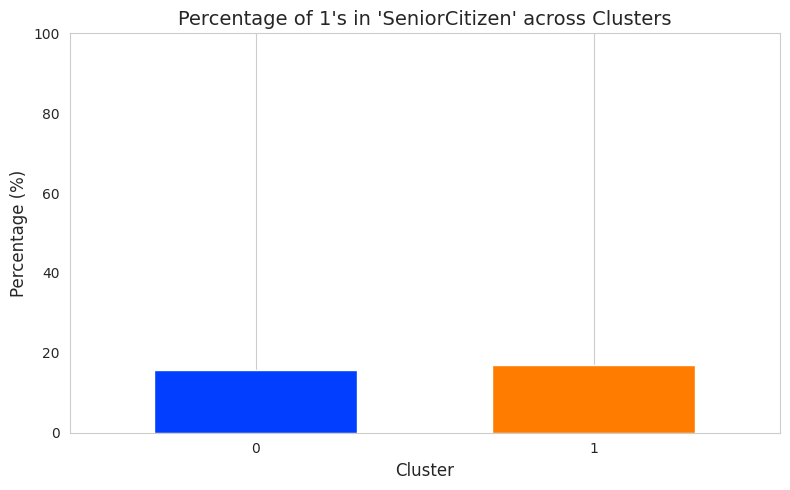

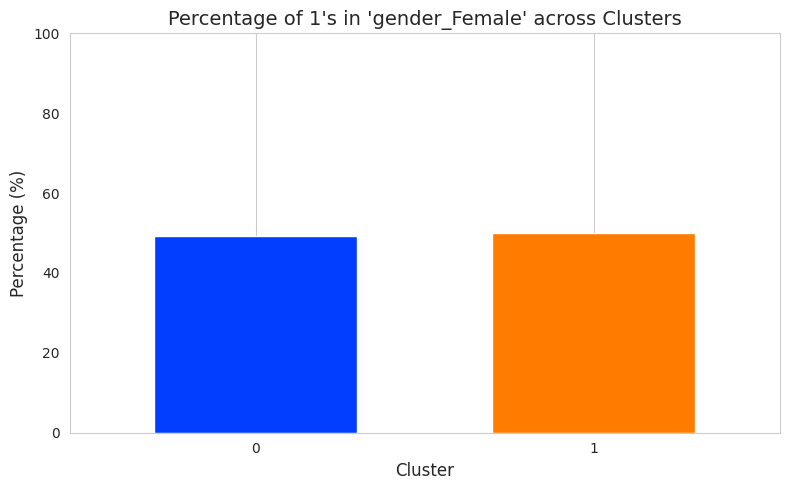

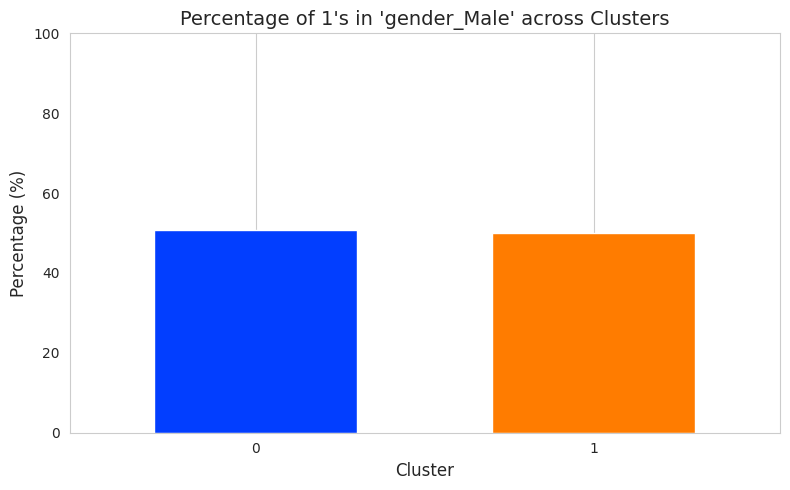

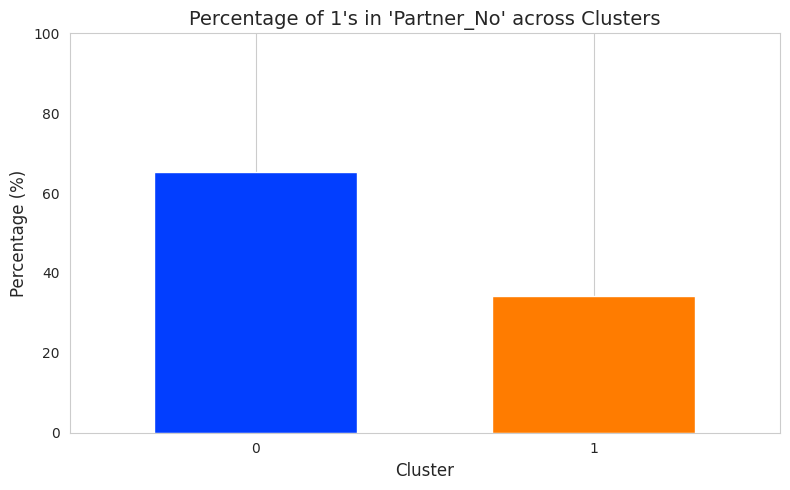

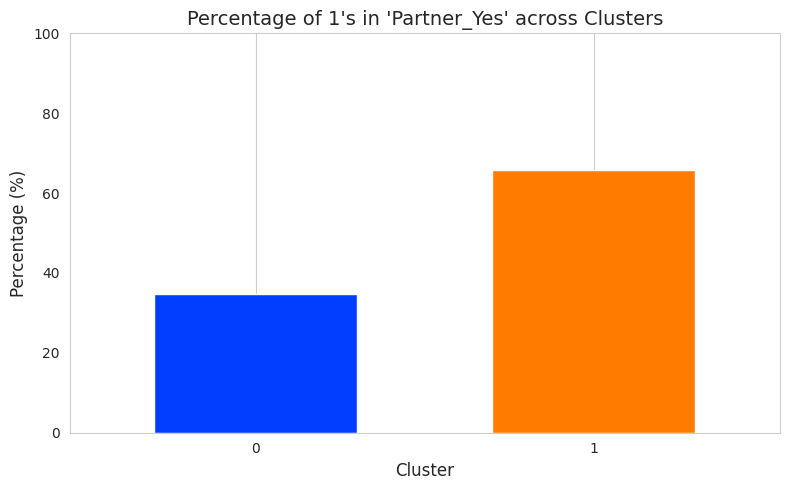

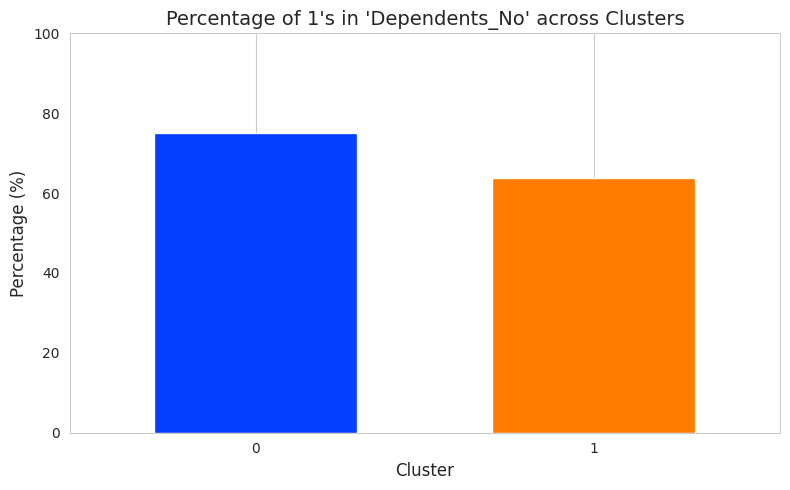

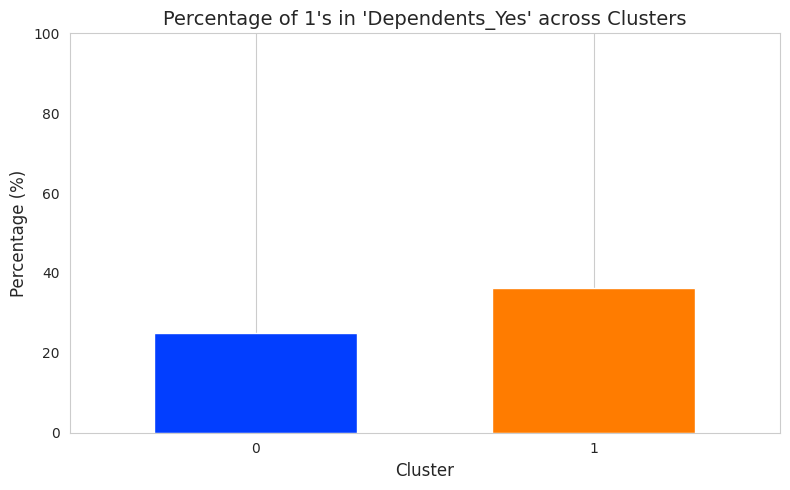

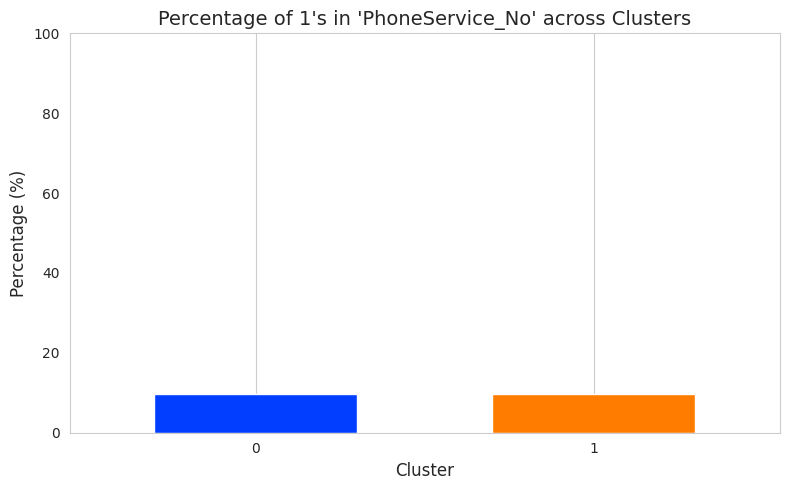

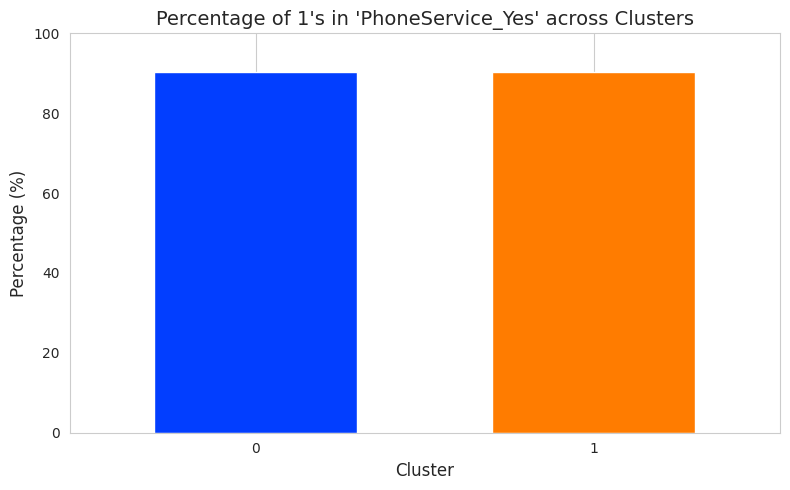

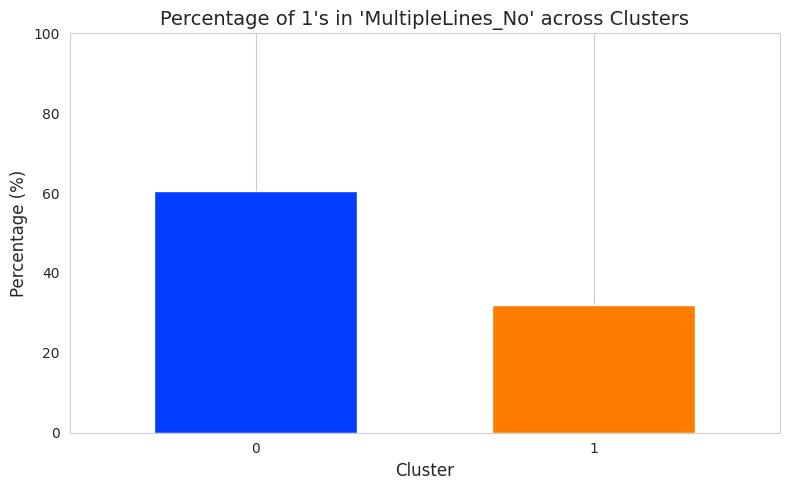

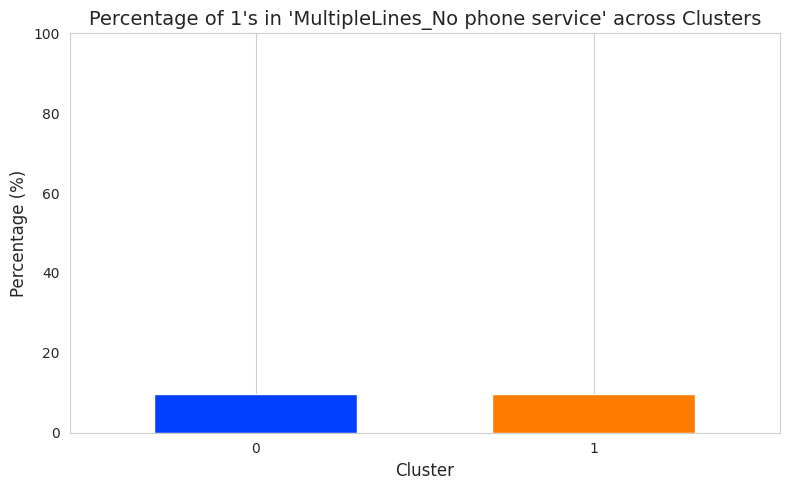

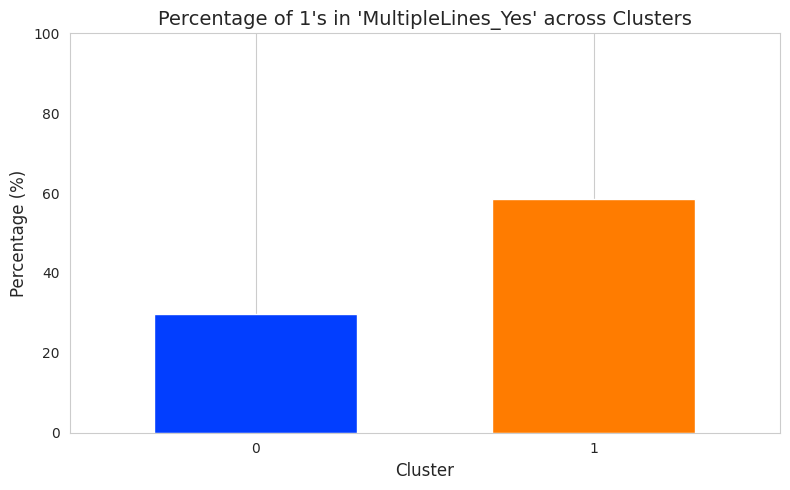

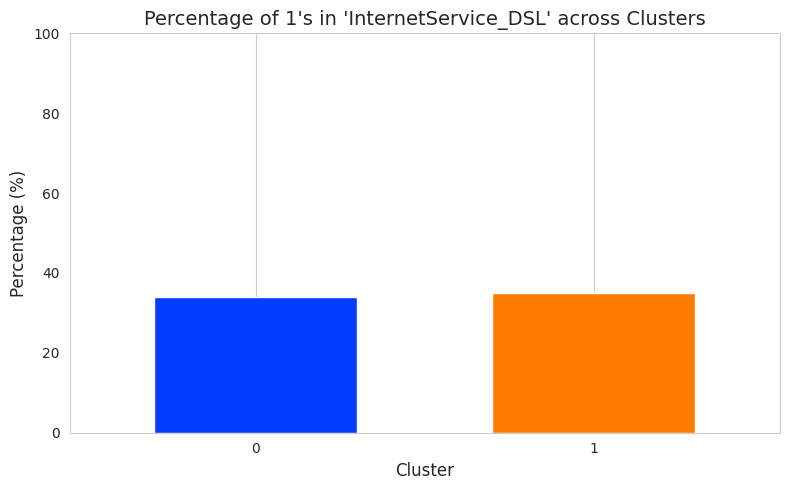

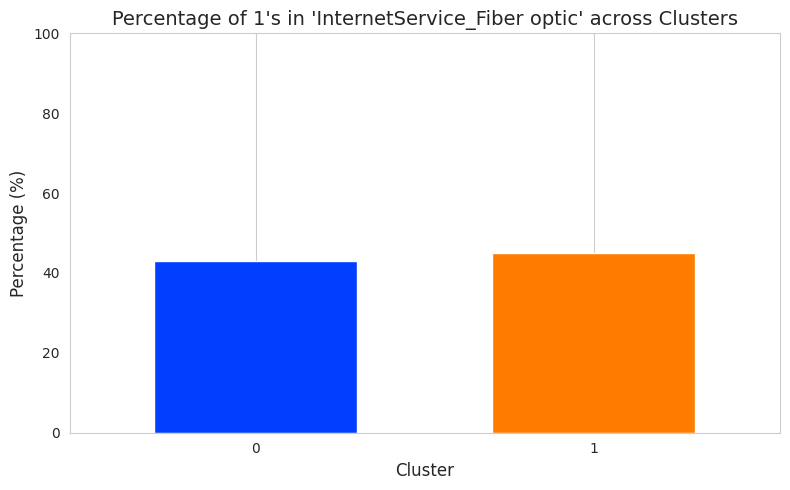

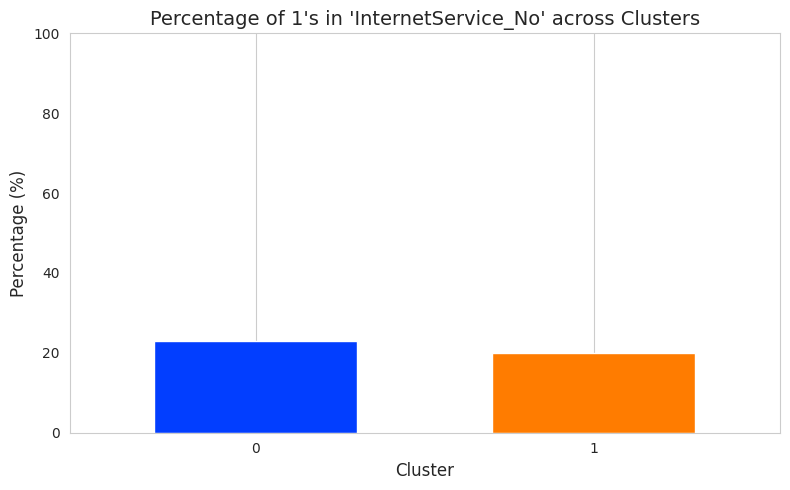

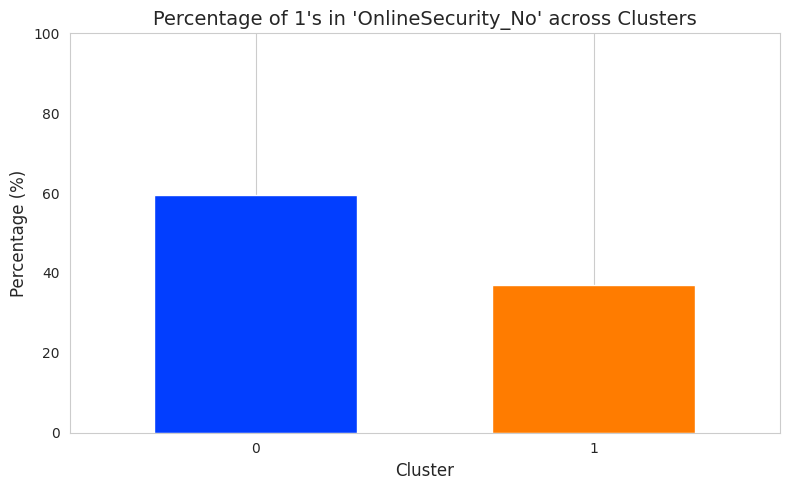

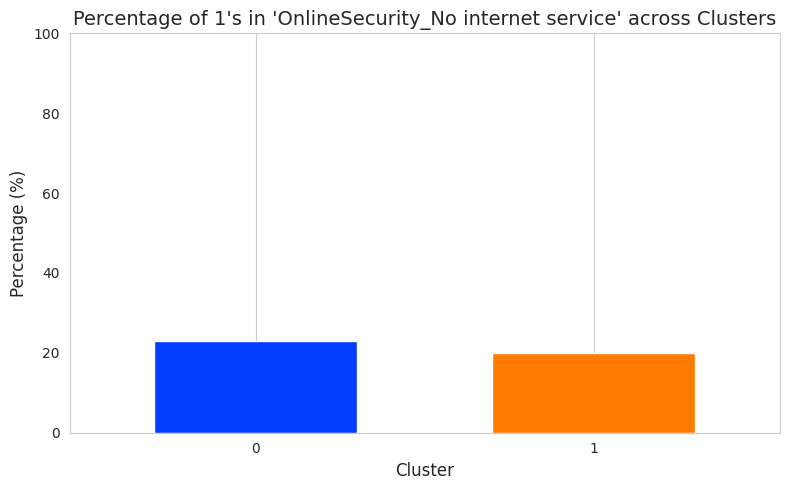

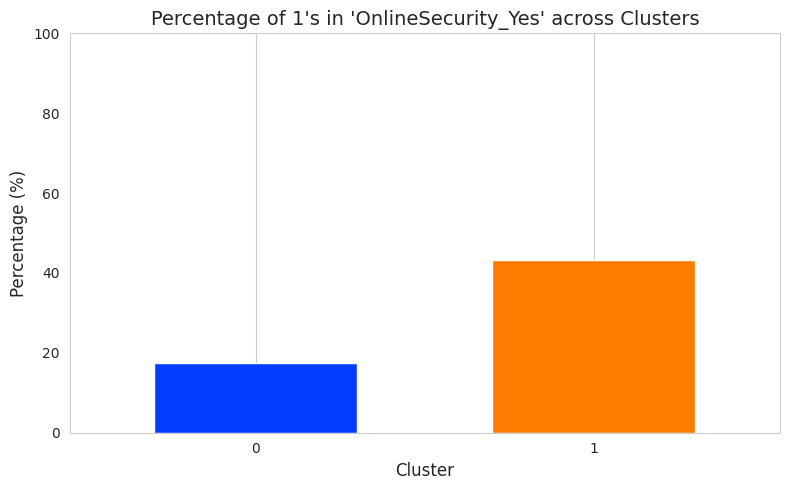

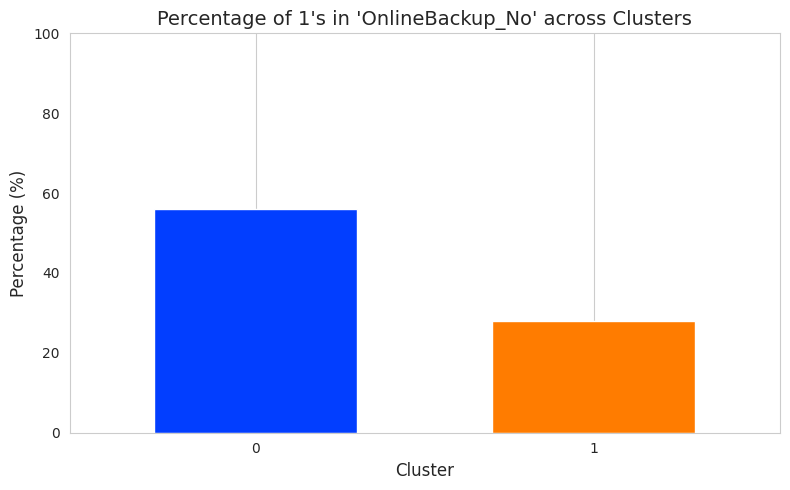

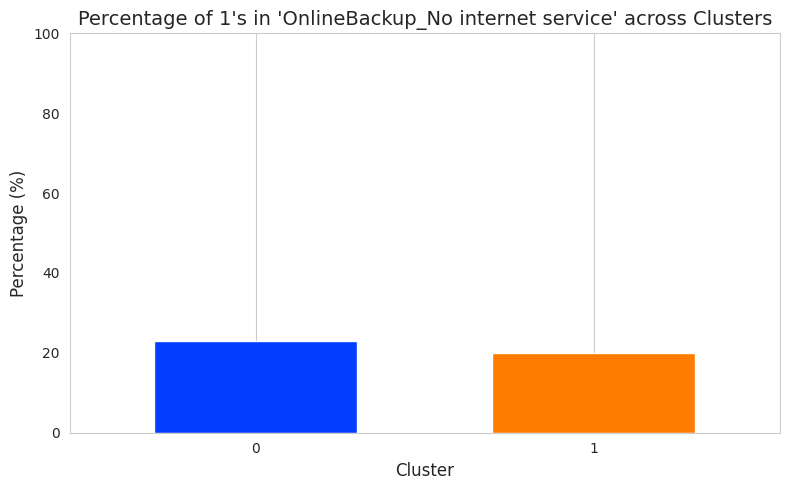

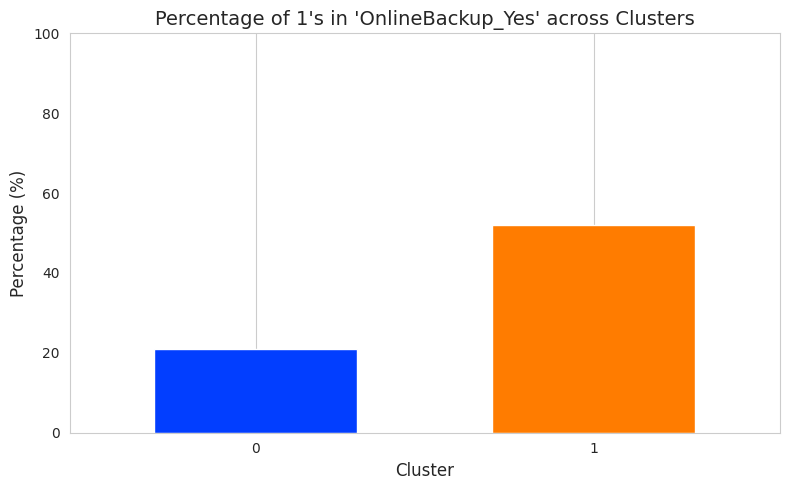

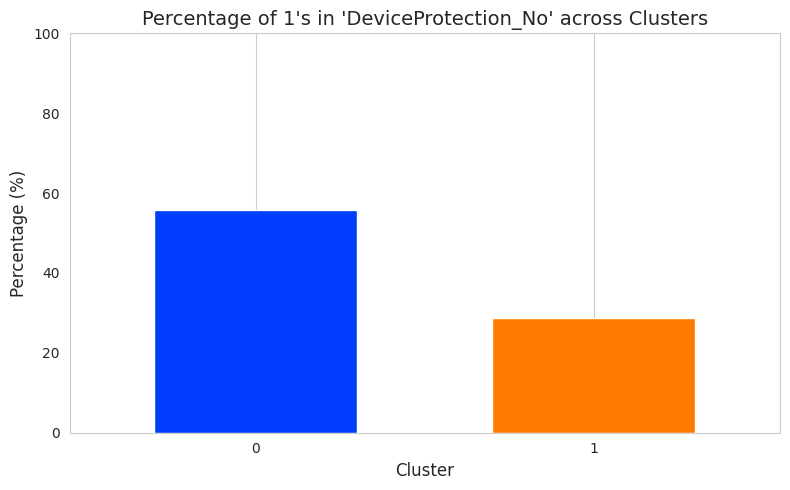

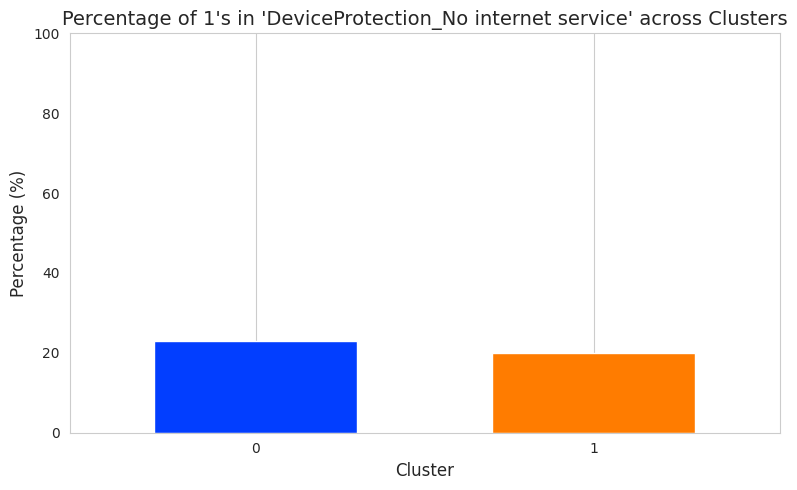

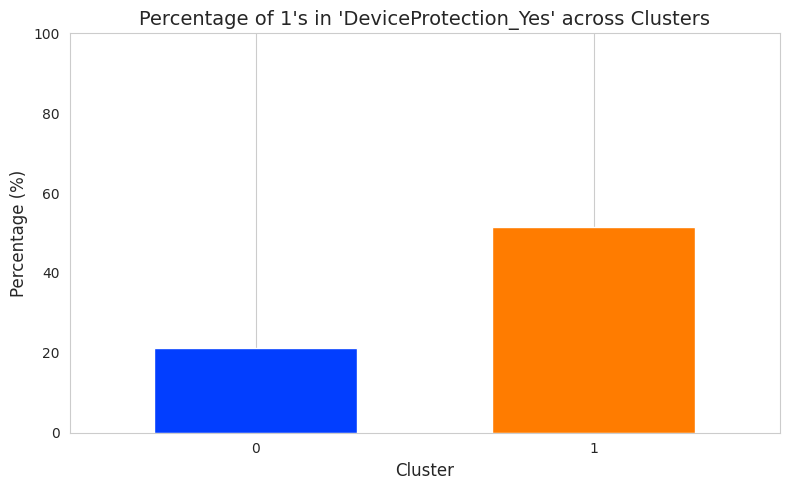

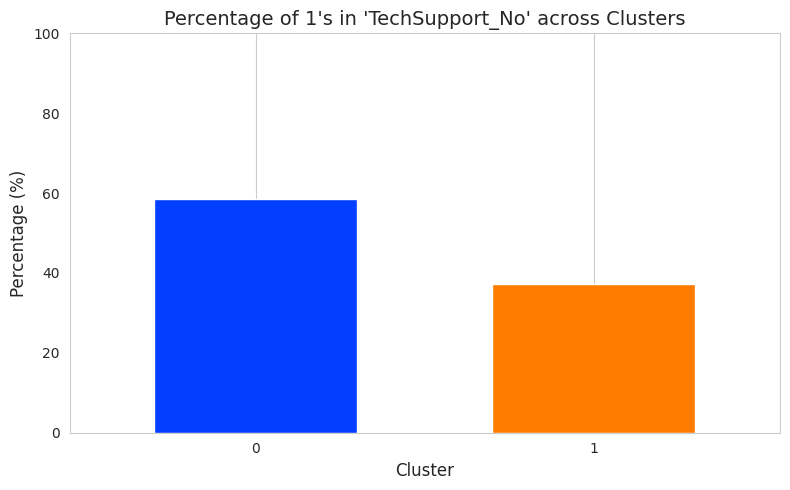

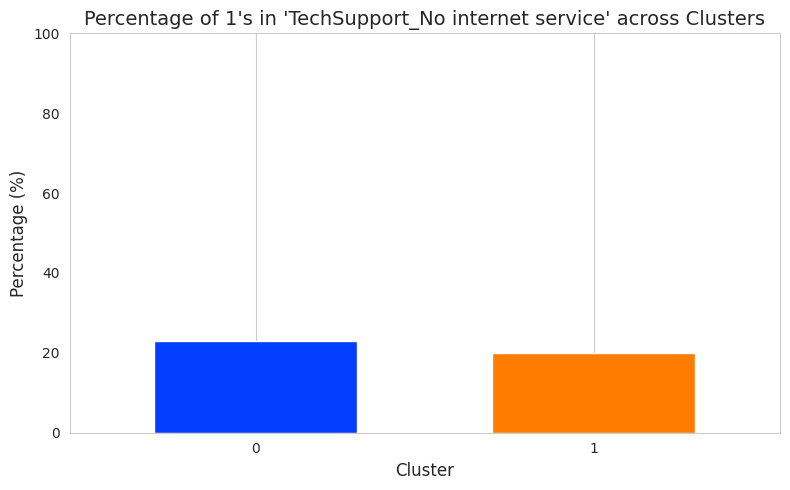

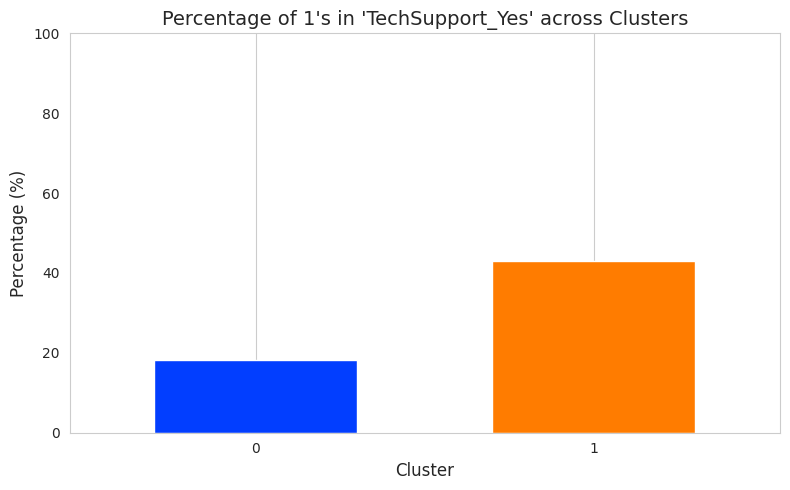

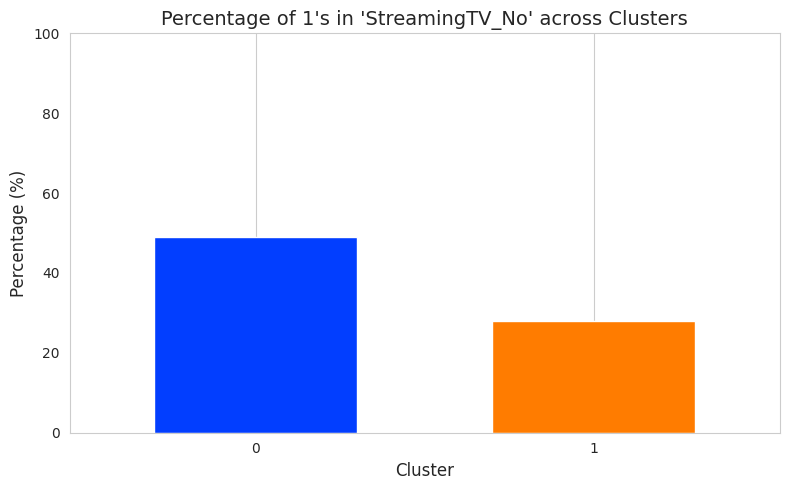

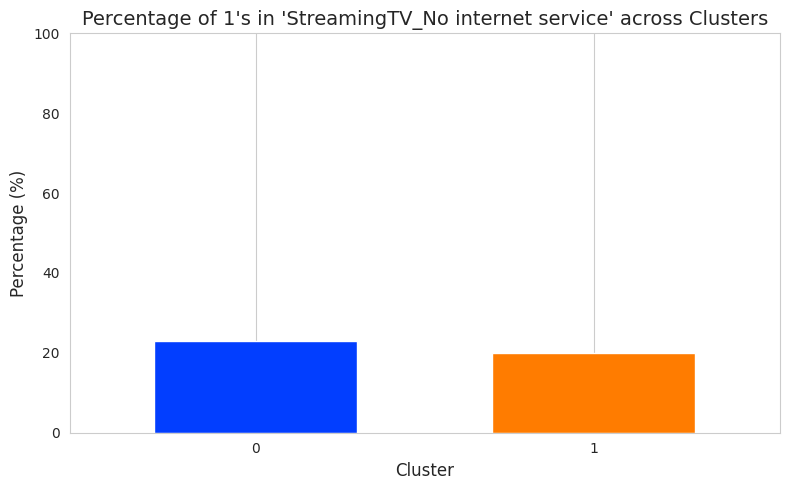

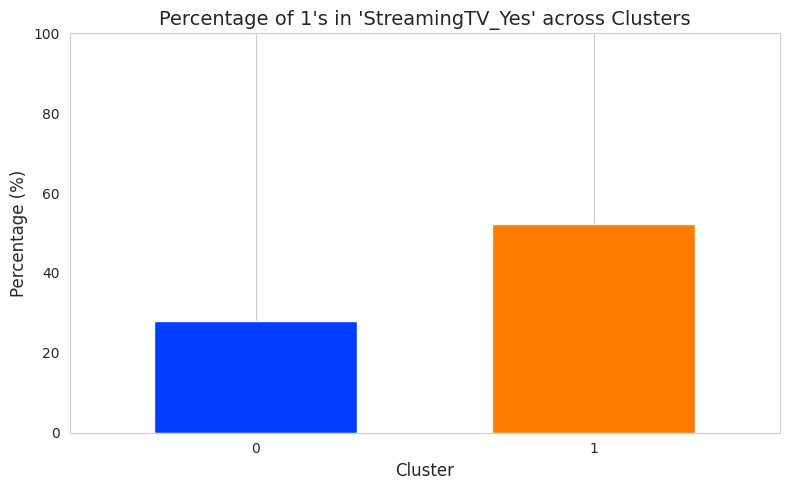

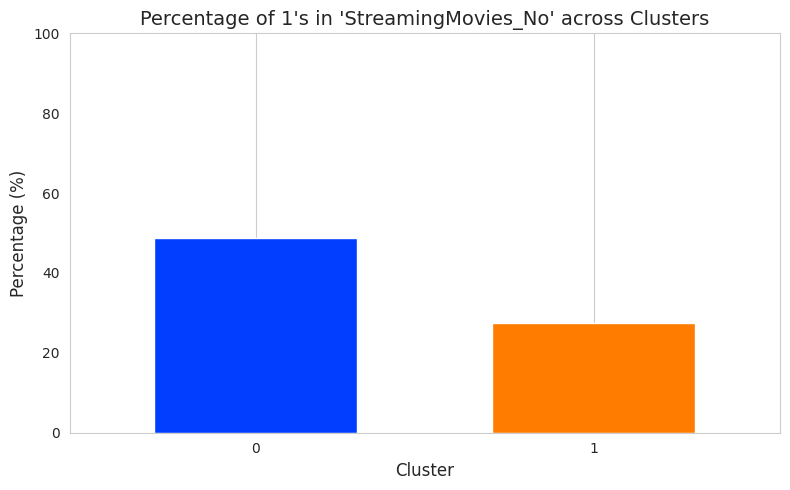

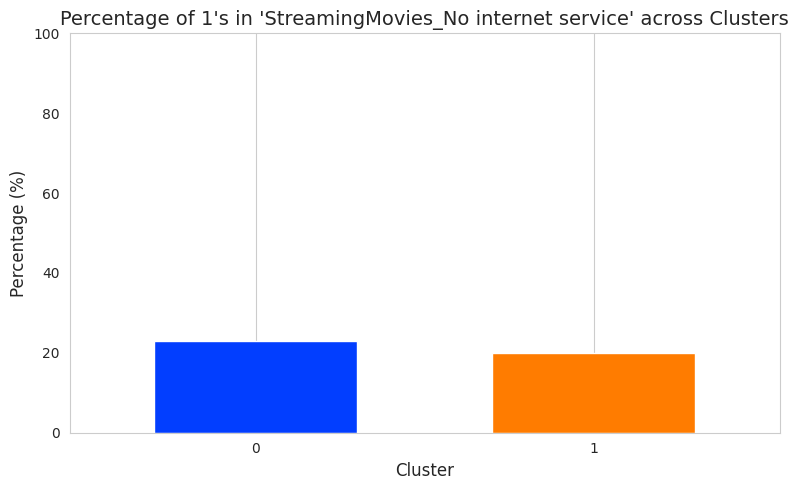

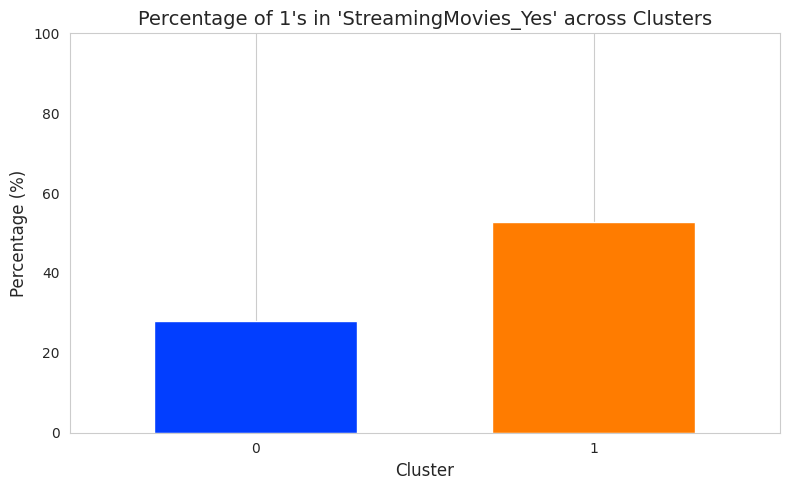

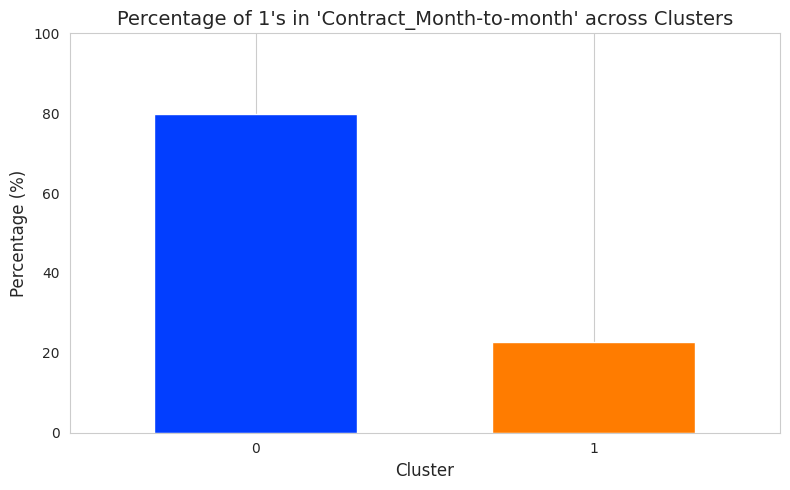

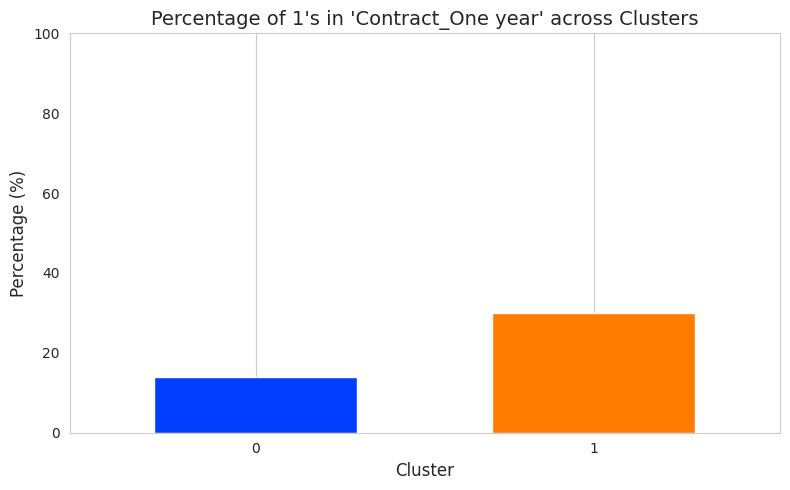

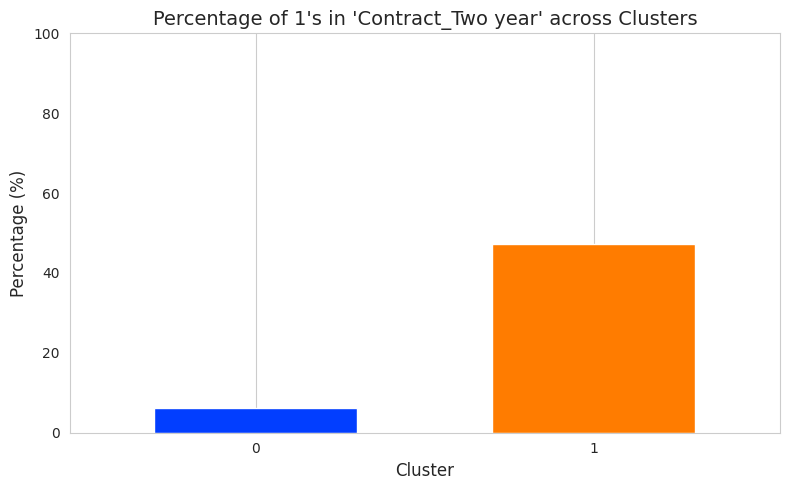

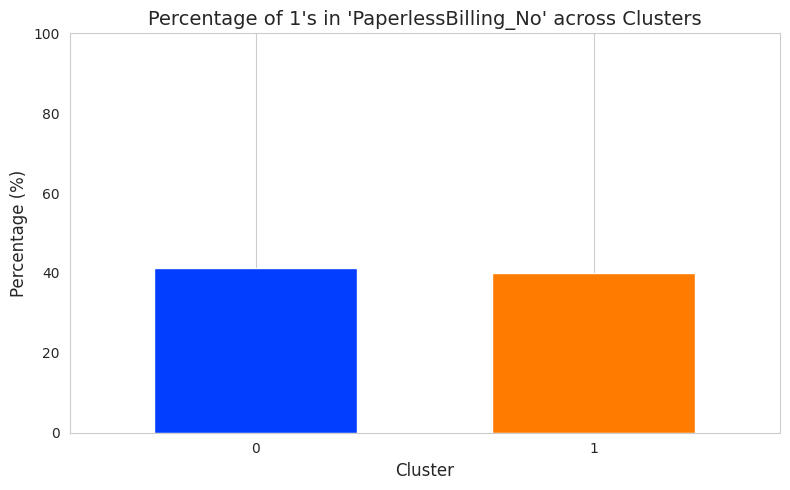

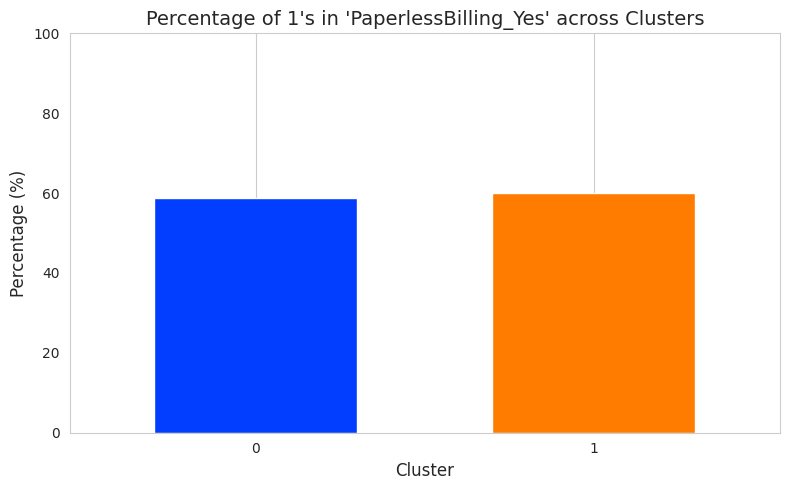

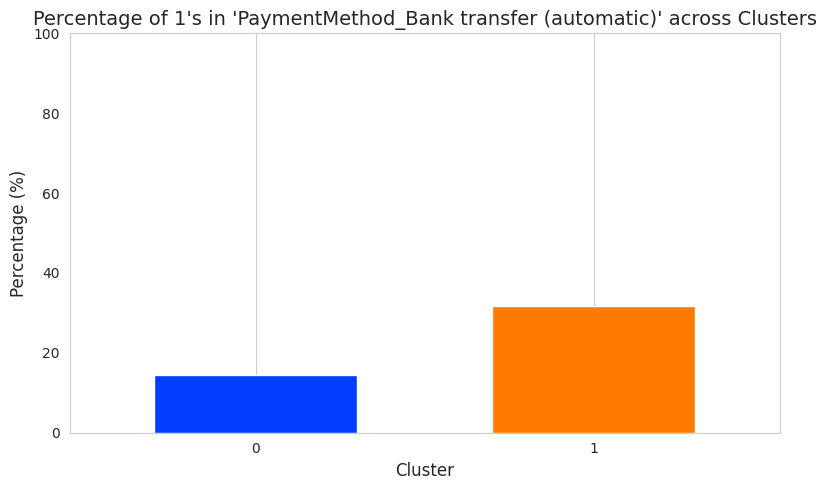

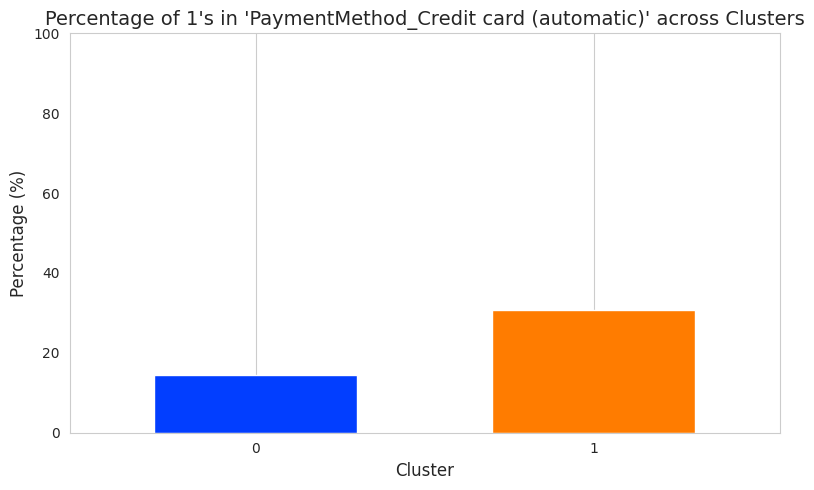

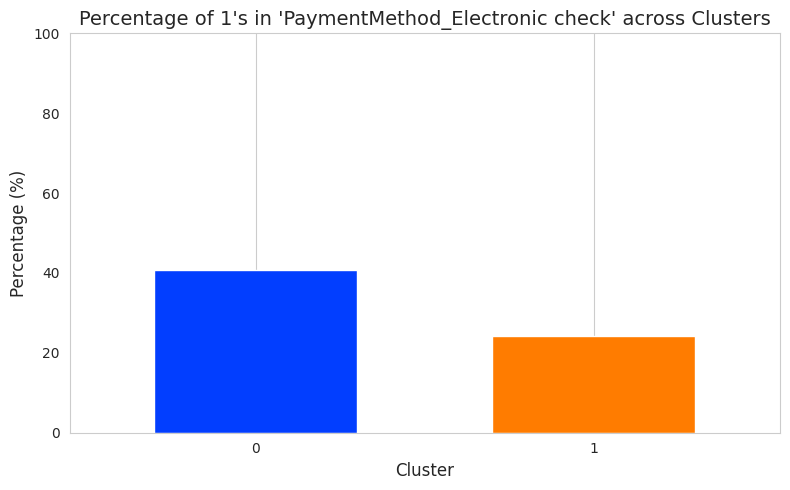

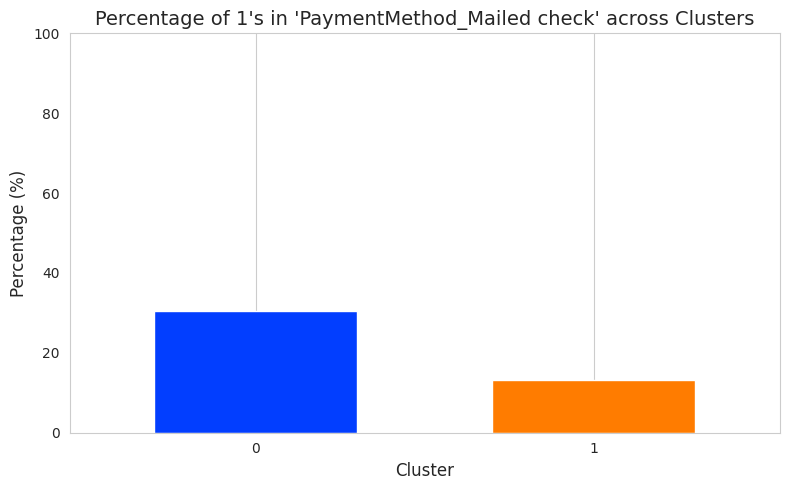

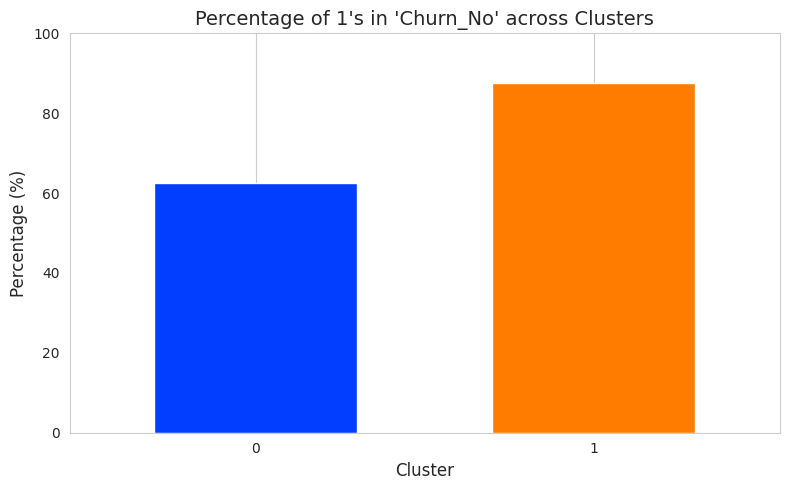

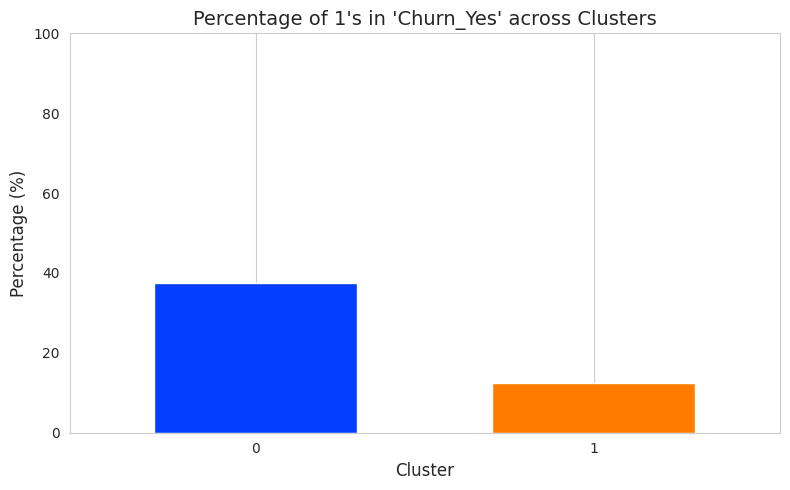

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe
df = pd.read_csv('Churn7043_clustered_data_K2.csv')

# Identify original categorical columns (excluding 'tenure' and numerical columns)
numerical_cols = ['MonthlyCharges', 'TotalCharges']
original_categorical_cols = [col for col in df.columns if col not in numerical_cols + ['tenure', 'Cluster']]

# One-hot encode the necessary columns
df_encoded = pd.get_dummies(df[original_categorical_cols], drop_first=False)

# Add 'Cluster' back to the dataframe
df_encoded['Cluster'] = df['Cluster']

# Now all columns are 0/1 except 'Cluster'

# Setup for plotting
sns.set_style('whitegrid')
cluster_colors = sns.color_palette('bright', len(df['Cluster'].unique()))

# Create graphs
for col in df_encoded.columns:
    if col == 'Cluster':
        continue

    plt.figure(figsize=(8, 5))

    # Group by cluster and compute percentage of 1s
    cluster_percents = df_encoded.groupby('Cluster')[col].mean() * 100

    # Plot
    cluster_percents.plot(kind='bar', color=cluster_colors, width=0.6)

    plt.title(f"Percentage of 1's in '{col}' across Clusters", fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [2]:
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Load Dataset ---
df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")
df = df.drop(columns=['customerID'])

# --- Separate Categorical and Numerical Columns ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Encode Categorical Columns ---
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# --- Prepare Data for k-Prototypes ---
X = df.values.astype(float)
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# --- Clustering Loop with Metrics ---
metrics = []
costs = []
min_cost = float('inf')
best_k = None
best_model = None
early_stop_patience = 3  # early stop after 3 low drops
low_drop_counter = 0
prev_cost = None

start_time = time.time()

for k in range(2, 101):
    print(f"\nTraining k-Prototypes with k = {k}")
    model = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = model.fit_predict(X, categorical=categorical_indices)
    cost = model.cost_
    costs.append(cost)

    # Track best
    if cost < min_cost:
        min_cost = cost
        best_k = k
        best_model = model

    # Relative drop
    if prev_cost is not None:
        drop = (prev_cost - cost) / prev_cost
    else:
        drop = np.nan
    prev_cost = cost

    # Cluster sizes
    _, counts = np.unique(clusters, return_counts=True)
    avg_size = np.mean(counts)
    min_size = np.min(counts)
    max_size = np.max(counts)

    # Store metrics
    metrics.append({
        'k': k,
        'cost': cost,
        'relative_cost_drop': round(drop * 100, 2) if not np.isnan(drop) else np.nan,
        'avg_cluster_size': int(avg_size),
        'min_cluster_size': int(min_size),
        'max_cluster_size': int(max_size)
    })

    print(f"Cost: {cost:.2f}, Relative Drop: {drop*100:.2f}%")

    # --- Early stopping check ---
    if drop < 0.02 and not np.isnan(drop):
        low_drop_counter += 1
        if low_drop_counter >= early_stop_patience:
            print(f"Early stopping at k = {k} (cost flattening)")
            break
    else:
        low_drop_counter = 0

total_time = time.time() - start_time
print(f"\nBest number of clusters: {best_k} with cost = {min_cost:.2f}")
print(f"Time taken: {total_time:.2f} seconds")

# --- Plot Cost vs k ---
plt.figure(figsize=(12, 6))
sns.lineplot(x=[m['k'] for m in metrics], y=[m['cost'] for m in metrics])
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method - k-Prototypes')
plt.grid(True)
plt.show()

# --- Final Cluster Assignments ---
df['Cluster'] = best_model.predict(X, categorical=categorical_indices)

# --- Cluster Summary ---
cluster_summary = df.groupby('Cluster').agg(['mean', 'count'])
pd.set_option('display.max_columns', None)
print("\nCluster Summary:")
print(cluster_summary)

# --- Save Metrics to CSV (Optional) ---
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("kprototypes_clustering_metrics.csv", index=False)
print("\nAll clustering metrics saved to 'kprototypes_clustering_metrics.csv'")



Training k-Prototypes with k = 2
Cost: 5970166.43, Relative Drop: nan%

Training k-Prototypes with k = 3
Cost: 3728085.87, Relative Drop: 37.55%

Training k-Prototypes with k = 4
Cost: 2594211.62, Relative Drop: 30.41%

Training k-Prototypes with k = 5
Cost: 2150068.94, Relative Drop: 17.12%

Training k-Prototypes with k = 6
Cost: 1739592.82, Relative Drop: 19.09%

Training k-Prototypes with k = 7
Cost: 1488588.93, Relative Drop: 14.43%

Training k-Prototypes with k = 8
Cost: 1346011.32, Relative Drop: 9.58%

Training k-Prototypes with k = 9
Cost: 1225191.37, Relative Drop: 8.98%

Training k-Prototypes with k = 10
Cost: 1109556.08, Relative Drop: 9.44%

Training k-Prototypes with k = 11
Cost: 1013135.92, Relative Drop: 8.69%

Training k-Prototypes with k = 12
Cost: 937426.36, Relative Drop: 7.47%

Training k-Prototypes with k = 13
Cost: 892221.71, Relative Drop: 4.82%

Training k-Prototypes with k = 14
Cost: 849654.37, Relative Drop: 4.77%

Training k-Prototypes with k = 15
Cost: 8133

In [ ]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Load Dataset ---
df = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")
df = df.drop(columns=['customerID'])

# --- Separate Categorical and Numerical Columns ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Encode Categorical Columns ---
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# --- Prepare Data for k-Prototypes ---
X = df.values.astype(float)
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# --- Clustering Loop with Metrics ---
metrics = []
costs = []
min_cost = float('inf')
best_k = None
best_model = None
early_stop_patience = 3  # early stop after 3 low drops
low_drop_counter = 0
prev_cost = None

start_time = time.time()

for k in range(20, 30):
    print(f"\nTraining k-Prototypes with k = {k}")
    model = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = model.fit_predict(X, categorical=categorical_indices)
    cost = model.cost_
    costs.append(cost)

    # Track best
    if cost < min_cost:
        min_cost = cost
        best_k = k
        best_model = model

    # Relative drop
    if prev_cost is not None:
        drop = (prev_cost - cost) / prev_cost
    else:
        drop = np.nan
    prev_cost = cost

    # Cluster sizes
    _, counts = np.unique(clusters, return_counts=True)
    avg_size = np.mean(counts)
    min_size = np.min(counts)
    max_size = np.max(counts)

    # Store metrics
    metrics.append({
        'k': k,
        'cost': cost,
        'relative_cost_drop': round(drop * 100, 2) if not np.isnan(drop) else np.nan,
        'avg_cluster_size': int(avg_size),
        'min_cluster_size': int(min_size),
        'max_cluster_size': int(max_size)
    })

    print(f"Cost: {cost:.2f}, Relative Drop: {drop*100:.2f}%")

    # --- Early stopping check ---
    if drop < 0.02 and not np.isnan(drop):
        low_drop_counter += 1
        if low_drop_counter >= early_stop_patience:
            print(f"Early stopping at k = {k} (cost flattening)")
            break
    else:
        low_drop_counter = 0

total_time = time.time() - start_time
print(f"\nBest number of clusters: {best_k} with cost = {min_cost:.2f}")
print(f"Time taken: {total_time:.2f} seconds")

# --- Plot Cost vs k ---
plt.figure(figsize=(12, 6))
sns.lineplot(x=[m['k'] for m in metrics], y=[m['cost'] for m in metrics])
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method - k-Prototypes')
plt.grid(True)
plt.show()

# --- Final Cluster Assignments ---
df['Cluster'] = best_model.predict(X, categorical=categorical_indices)

# --- Cluster Summary ---
cluster_summary = df.groupby('Cluster').agg(['mean', 'count'])
pd.set_option('display.max_columns', None)
print("\nCluster Summary:")
print(cluster_summary)

# --- Save Metrics to CSV (Optional) ---
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("kprototypes_clustering_metrics.csv", index=False)
print("\nAll clustering metrics saved to 'kprototypes_clustering_metrics.csv'")



Training k-Prototypes with k = 20
Cost: 691793.01, Relative Drop: nan%

Training k-Prototypes with k = 21
Cost: 671278.35, Relative Drop: 2.97%

Training k-Prototypes with k = 22
Cost: 658013.46, Relative Drop: 1.98%

Training k-Prototypes with k = 23
Cost: 641177.87, Relative Drop: 2.56%

Training k-Prototypes with k = 24
Cost: 627852.01, Relative Drop: 2.08%

Training k-Prototypes with k = 25
Cost: 609288.94, Relative Drop: 2.96%

Training k-Prototypes with k = 26
Cost: 598208.01, Relative Drop: 1.82%

Training k-Prototypes with k = 27


In [ ]:
### We chose 8 clusters since 

In [3]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder

# --- Load Dataset ---
df_original = pd.read_csv("/kaggle/input/customer-churn-openml-2-7043/dataset1_openml_7043x21.csv")
df_original = df_original.drop(columns=['customerID'])

# --- Separate Categorical and Numerical Columns ---
categorical_cols = df_original.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_original.select_dtypes(include=['int64', 'float64']).columns.tolist()

# --- Encode Categorical Columns ---
le_dict = {}
df = df_original.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# --- Prepare Data for k-Prototypes ---
X = df.values.astype(float)
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# --- Cluster Configurations ---
for k in [8, 20]:
    print(f"\nTraining k-Prototypes with k = {k}")
    model = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = model.fit_predict(X, categorical=categorical_indices)

    # Copy original encoded DataFrame and assign cluster labels
    df_clustered = df.copy()
    df_clustered['Cluster'] = clusters

    # Save the clustered dataset
    output_file = f"clustered_customer_data_k{k}.csv"
    df_clustered.to_csv(output_file, index=False)
    print(f"Clustered dataset for k = {k} saved to: {output_file}")

    # Print summary
    cluster_summary = df_clustered.groupby('Cluster').agg(['mean', 'count'])
    pd.set_option('display.max_columns', None)
    print(f"\nCluster Summary for k = {k}:")
    print(cluster_summary)



Training k-Prototypes with k = 8
Clustered dataset for k = 8 saved to: clustered_customer_data_k8.csv

Cluster Summary for k = 8:
           gender       SeniorCitizen         Partner       Dependents        \
             mean count          mean count      mean count       mean count   
Cluster                                                                        
0        0.525000   880      0.286364   880  0.510227   880   0.242045   880   
1        0.474922  1276      0.238245  1276  0.285266  1276   0.155172  1276   
2        0.524194   744      0.134409   744  0.717742   744   0.419355   744   
3        0.515072   763      0.060288   763  0.639581   763   0.463958   763   
4        0.492201   577      0.136915   577  0.476603   577   0.298094   577   
5        0.519284   726      0.101928   726  0.265840   726   0.242424   726   
6        0.488142  1012      0.231225  1012  0.721344  1012   0.310277  1012   
7        0.515493  1065      0.049765  1065  0.346479  1065   0.34835